# HW 2 - Разложение матриц градиентным методом

Цель задания: В ходе реализации [разложения Таккера](https://proceedings.neurips.cc/paper/2018/file/45a766fa266ea2ebeb6680fa139d2a3d-Paper.pdf) градиентным методом освоить pyTorch и реализовать подходы оптимизации параметров модели (в отсутствии готовых решений).

[Более-менее внятное описание алгоритма канонического разложения](https://www.alexejgossmann.com/tensor_decomposition_tucker/) - само аналитическое разложение вам реализовывать НЕ НУЖНО

_ПРИМ._ доп материал который юзал
1) https://www.youtube.com/playlist?list=PL4_hYwCyhAvZym27H5SU9BuCUYpbMq5AF (это must have чтобы хоть как то понять что вообще происходит)
2) https://www-users.cse.umn.edu/~saad/PDF/umsi-2006-132.pdf (отсюда дополнительно)

In [1]:
import random
import time
import torch
import pandas as pd
import numpy as np

import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from numpy.linalg import svd, matrix_rank, pinv, inv
from scipy.linalg import eigh, eig
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
from torch import nn

torch.manual_seed(0)

## 1 Создайте 3х мерный тензор
Размер тензора не меньше 100 по каждой из размерностей.

Заполните случайными целыми числами в диапазоне от 0 до 9.

Примечание: разложение будет корректно работать со случайным тензором, только если изначально создавать случайные ядро и матрицы, а потом по ним формировать тензор. Работайте с типом *torch.Tensor.double*.

In [40]:
# def k_mode(tensor, matrix, dim):
#     tensor_shapes = list(tensor.shape)
#     tensor_dim = list(len(tensor_shapes)).remove(dim)
#     tensor_shapes[dim] = matrix.shape[dim]
#     data = torch.zeros(tensor_shapes)
#     for dim_index in tensor_dim:
        
#     return data

## 2 Реализуйте метод для восстановления тензора по разложению

In [41]:
# Функция, восстанавливающая тензор по ядру и матрицам
def move_axis_to_end(data, index):
    data = torch.swapaxes(data, i, 2)
    
    return data

def repair_tensor(G_, U):
    # data - восстановленный тензор из матриц и ядра
    # U - список матриц, в порядке следования dimensions у тензора
    # G_ - ядро разложения
    data = G_.clone()

    # Топорное решение для 3-d тензора. В общем случае (или даже для трехмерного) надо 
    # реализовать смещение колонок чтобы заработало встроенное перемножение тензоров из pytorch - это можно сделать в более адекватном виде
    data = torch.swapaxes(data, 0, 1)
    data = torch.swapaxes(data, 1, 2)
    data = data @ U[0]
    data = torch.swapaxes(data, 1, 2)
    data = torch.swapaxes(data, 0, 1)

    data = torch.swapaxes(data, 0, 1)
    data = torch.swapaxes(data, 0, 2)
    data = data @ U[1]
    data = torch.swapaxes(data, 0, 2)
    data = torch.swapaxes(data, 0, 1)

    data = data @ U[2]
    
    return data

test

In [42]:
test_answer = torch.Tensor(
    [
        [[ 1.,  2.,  3.,  6.],
         [ 4.,  5.,  6., 15.],
         [ 7.,  8.,  9., 24.],
         [ 1.,  2.,  3.,  6.],
         [ 4.,  5.,  6., 15.]],

        [[10., 11., 12., 33.],
         [13., 14., 15., 42.],
         [16., 17., 18., 51.],
         [10., 11., 12., 33.],
         [13., 14., 15., 42.]],

        [[ 1.,  2.,  3.,  6.],
         [ 4.,  5.,  6., 15.],
         [ 7.,  8.,  9., 24.],
         [ 1.,  2.,  3.,  6.],
         [ 4.,  5.,  6., 15.]],

        [[10., 11., 12., 33.],
         [13., 14., 15., 42.],
         [16., 17., 18., 51.],
         [10., 11., 12., 33.],
         [13., 14., 15., 42.]]
    ])

In [43]:
test_g = torch.Tensor.double(torch.Tensor(
    [
        [[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]],
        
        [[10, 11, 12],
         [13, 14, 15],
         [16, 17, 18]]
    ]
))

test_U_0 = torch.Tensor.double(torch.Tensor(
    [[1, 0],
     [0, 1],
     [1, 0],
     [0, 1],]
))

test_U_1 = torch.Tensor.double(torch.Tensor(
    [[1, 0, 0],
     [0, 1 ,0],
     [0, 0, 1],
     [1, 0, 0],
     [0, 1, 0]]
))

test_U_2 = torch.Tensor.double(torch.Tensor(
    [[1, 0, 0],
     [0, 1 ,0],
     [0, 0, 1],
     [1, 1, 1]]
))

rep = repair_tensor(test_g, [test_U_0.t(), test_U_1.t(), test_U_2.t()])
rep

tensor([[[ 1.,  2.,  3.,  6.],
         [ 4.,  5.,  6., 15.],
         [ 7.,  8.,  9., 24.],
         [ 1.,  2.,  3.,  6.],
         [ 4.,  5.,  6., 15.]],

        [[10., 11., 12., 33.],
         [13., 14., 15., 42.],
         [16., 17., 18., 51.],
         [10., 11., 12., 33.],
         [13., 14., 15., 42.]],

        [[ 1.,  2.,  3.,  6.],
         [ 4.,  5.,  6., 15.],
         [ 7.,  8.,  9., 24.],
         [ 1.,  2.,  3.,  6.],
         [ 4.,  5.,  6., 15.]],

        [[10., 11., 12., 33.],
         [13., 14., 15., 42.],
         [16., 17., 18., 51.],
         [10., 11., 12., 33.],
         [13., 14., 15., 42.]]], dtype=torch.float64)

In [44]:
((test_answer.numpy() - rep.numpy())**2).mean()

0.0

Если mse 0 - не накосячил хотя бы в базовом примере

## 1.1 Continue creation

In [45]:
# Создадим тензор: размер тензора и r задаётся
def get_tensor(size: tuple[int]=(100,200,150), r: int | tuple[int] =10):
    # data - тензор с заданной размерностью
    # U - список матриц
    # G - ядро разложения
    if type(r).__name__ == "int":
        r = (r, r, r)
    G = torch.Tensor.double(torch.round(torch.rand(r)))
    U = [torch.Tensor.double(torch.round(torch.rand((r[i], size[i])))) for i in range(3)]
    data = repair_tensor(G, U)
    
    return data, U, G

Сгенерируйте тензор и добавьте к нему случайный шум с размерностью *1e-2*

In [46]:
data, U, G = get_tensor(r=(10, 20, 30))
data.shape, [u.shape for u in U], G.shape

(torch.Size([100, 200, 150]),
 [torch.Size([10, 100]), torch.Size([20, 200]), torch.Size([30, 150])],
 torch.Size([10, 20, 30]))

In [47]:
a = G @ U[2]
a.shape

torch.Size([10, 20, 150])

In [48]:
random_noise = torch.Tensor.double(torch.round(torch.rand(tuple(data.shape)) * 10) / 100)
data += random_noise

In [49]:
data

tensor([[[603.0400, 720.0200, 638.0100,  ..., 611.1000, 669.0400, 452.0300],
         [500.0200, 571.0400, 525.0500,  ..., 497.0700, 543.0900, 361.0600],
         [276.0500, 337.0700, 309.0200,  ..., 296.0900, 327.0200, 219.0700],
         ...,
         [321.0600, 390.0700, 342.0000,  ..., 327.0500, 358.0600, 241.0900],
         [657.0200, 778.0100, 688.0700,  ..., 655.0000, 718.0000, 491.0600],
         [758.0000, 912.0900, 826.0400,  ..., 786.0100, 864.0900, 561.0500]],

        [[439.0500, 525.0900, 465.0000,  ..., 447.0100, 490.0500, 310.0200],
         [361.0400, 425.0900, 381.0100,  ..., 345.0100, 383.0400, 256.0900],
         [189.0600, 244.0900, 213.0800,  ..., 199.0300, 221.0600, 142.0100],
         ...,
         [232.0500, 274.0500, 244.0500,  ..., 231.0000, 257.0900, 168.0500],
         [476.0500, 570.0000, 510.0500,  ..., 472.0700, 522.0400, 342.0900],
         [539.0900, 655.0700, 584.0900,  ..., 541.0800, 613.0300, 398.0100]],

        [[349.0900, 423.0500, 375.0500,  ...

Вопрос:
Почему задание не имеет смысла для полностью случайного тензора и зачем добавлять шум? *не отвечать нельзя*

Ответ: Если сначала создать тензор, то 1) не проверимся на сходимость 2) на случайном тензоре неизвестно какие сингулярные числа получим, там вообще может быть дичь (решение может быть с комплексными числами либо вообще может не существовать приближения либо просто не сойдемся, тк у ортогональных матриц Uk неквадратных есть k линейно-независимых строк а остальные линейно-зависимые, что повлияет на метод аппроксимации), а создавая ядро с сингулярными числами в приемлемом диапазоне гарантируем что там все норм

## 3 Сделайте разложение библиотечным методом
Пакет можете брать любой

In [50]:
from tensorly.decomposition import tucker

decomp = tucker(data.numpy(), (10, 20, 30))
decomp

Decomposed rank-(10, 20, 30) TuckerTensor of shape (100, 200, 150) 

In [51]:
decomp.core

array([[[ 7.44909192e+05,  1.05819102e+00,  2.48314821e+00, ...,
         -2.50970722e-01,  6.34038298e-01,  1.24920982e+00],
        [-1.54422079e+00, -3.17876813e+02,  1.48136511e+03, ...,
         -9.04578036e+01, -5.66316286e+01, -3.64311238e+01],
        [ 2.86760769e+00, -3.15898094e+02, -2.01711310e+03, ...,
          2.60243494e+01, -2.79126836e+01,  2.30695126e+01],
        ...,
        [ 8.81513830e-01, -2.84488074e+01, -1.44904997e+02, ...,
         -1.68815528e+02, -8.77243784e+01,  9.18201615e+01],
        [-1.28665805e+00, -7.43637990e+01,  7.16534714e+01, ...,
          1.75611539e+02,  5.41425298e+01,  2.09156089e+02],
        [ 1.24531735e+00,  7.19611202e+01,  5.32803079e+01, ...,
         -1.46524117e+02,  1.51738728e+02, -2.08409757e+01]],

       [[-7.73101031e-01, -3.91037840e+03,  1.49517071e+01, ...,
          1.38983782e+02,  5.97432447e+01,  1.39393500e+01],
        [ 3.55909096e+03, -1.83867125e+02,  6.66457458e+01, ...,
         -3.75139745e+01,  2.01222817e

In [52]:
decomp.core.shape

(10, 20, 30)

In [53]:
decomp.factors

[array([[ 1.29653870e-01, -1.26264905e-01,  6.50313366e-02,
          4.17343966e-02,  1.00351201e-01,  3.67072046e-02,
         -4.11265808e-03, -2.11008381e-01, -6.95047985e-02,
         -2.70159743e-02],
        [ 9.23582506e-02, -1.41068979e-01,  3.56086480e-02,
         -2.88135804e-02,  7.65099897e-03, -1.54249075e-02,
          2.04947904e-01,  2.14702082e-01, -1.17556267e-01,
         -3.05084445e-02],
        [ 7.49662083e-02,  4.16264736e-02, -1.35744546e-01,
         -8.87758618e-02,  5.38851505e-02,  2.86974803e-02,
          2.38156363e-01,  1.15893552e-01,  4.53112746e-02,
          7.31615856e-02],
        [ 1.30032589e-01, -8.02312712e-02,  1.52086315e-01,
          1.63561153e-01,  7.32584627e-02, -5.44247827e-02,
         -1.16859300e-01, -3.01221499e-02, -4.92423140e-02,
         -1.64973563e-02],
        [ 9.28037558e-02,  1.51127449e-01, -1.05014635e-01,
         -6.84437058e-02,  6.97763495e-03, -1.67581192e-01,
          1.55362766e-02, -2.18210652e-02, -2.112751

In [54]:
factors = []
for f in decomp.factors:
    print(f.shape)
    factors.append(torch.Tensor.double(torch.Tensor(f)))

(100, 10)
(200, 20)
(150, 30)


In [55]:
decomp.core.shape

(10, 20, 30)

In [56]:
g = torch.Tensor.double(torch.Tensor(decomp.core.copy()))

In [57]:
mod_data = torch.Tensor.double(torch.Tensor(decomp.core.copy()))
mod_data = torch.swapaxes(mod_data, 0, 1)
mod_data = torch.swapaxes(mod_data, 1, 2)
mod_data = mod_data @ decomp.factors[0].T
mod_data = torch.swapaxes(mod_data, 1, 2)
mod_data = torch.swapaxes(mod_data, 0, 1)

mod_data = torch.swapaxes(mod_data, 0, 1)
mod_data = torch.swapaxes(mod_data, 0, 2)
mod_data = mod_data @ decomp.factors[1].T
mod_data = torch.swapaxes(mod_data, 0, 2)
mod_data = torch.swapaxes(mod_data, 0, 1)


In [58]:
mod_data.shape

torch.Size([100, 200, 30])

In [59]:
decomp.factors[2].T.shape

(30, 150)

In [60]:
(mod_data @ decomp.factors[2].T).shape

torch.Size([100, 200, 150])

In [61]:
data.shape

torch.Size([100, 200, 150])

In [62]:
(((mod_data @ decomp.factors[2].T).numpy() - data.numpy()) ** 2).mean()

0.0008653238608458776

In [63]:
decomp.factors[2].shape

(150, 30)

In [64]:
comp = repair_tensor(torch.Tensor(decomp.core), [torch.Tensor(factor.T) for factor in decomp.factors])

Не забудьте померить ошибку разложения по метрике MSE

In [65]:
mse = ((data.numpy() - comp.numpy())**2).mean()
mse

0.000865331611072976

## 4 Реализуйте разложение градиентным методом

### 4.1 Реализуйте *optimizer*
Можно взять из исходников *PyTorch* и отнаследоваться от *torch.optim.optimizer*.
Используйте квадратичный *Loss*.

Идеи:
1) Сделать HOOI
2) Втупую обучить нейронку на это без функций активации, где линейные слои - это и есть факторы матрицы. Только надо подкрутить модель
   а именно - выходом будет ядро, вот только учится будем на минимизацию нормы (см пункт 3)
4) Обучить оптимайзер, а функцией сделать f(Ui, Gi) -> Ai, где Ui - i-й фактор матрицы, Gi - произведение всех факторов от i-1 до 3 и Ai - тензор как произвдение Ui * Gi. Ну и вместо векторов для оптимизации - матрицы, вместо матриц - тензора, вместо нормы вектора как loss - фробениусова норма матрицы. И видимо вместо градиента - матрица Якоби
5) Второй вариант - подобрать под svd ранги разложения. Берем алгоритм нахождения минимального разложения Таккера (см лекции с лектория ФИФТ) и нагло коверкаем. Идея та же - брать факторы, делать SVD, а оптимайзером 

In [66]:
import math
import torch
from torch.optim.optimizer import Optimizer
import torch.optim as optim
from sklearn.decomposition import TruncatedSVD


class Opt(Optimizer):

    def __init__(self, params, lr=1e-3, momentum=0.9):
        defaults={'lr': lr}
        super().__init__(params, defaults)
        self.momentum = momentum 
        self.state = dict() 
        for group in self.param_groups: 
            for p in group['params']: 
                self.state[p] = dict(mom=torch.zeros_like(p.data)) 
    
    def step(self):
        for group in self.param_groups: 
            for p in group['params']: 
                if p not in self.state: 
                    self.state[p] = dict(mom=torch.zeros_like(p.data)) 
                mom = self.state[p]['mom'] 
                mom = self.momentum * mom - group['lr'] * p.grad.data 
                p.data += mom

        # return loss

In [67]:
import matplotlib.pyplot as plt

In [68]:
def optimize_factor(modified_tensor, rank: int, device=None, iter_num = 10, eps = 0.5, U=None, G=None):
    # Модифицированный тензор - это исходный тензор, у которого циклической перестановкой размерность, которая в данной функции будет
    # понижаться - поставлена в конец. Второй параметр - ранг матрицы Uk
    tensor_shape = list(modified_tensor.shape)
    modified_size = tensor_shape[-1]
    core_shape = tensor_shape[:-1] + [rank]

    if U is not None and G is not None:
        U_k = torch.Tensor.double(torch.round(torch.rand((rank, modified_size))))
        G_k = torch.Tensor.double(torch.round(torch.zeros(core_shape)))
        G_k = modified_tensor @ U_k.t()
    U_k = torch.Tensor.double(torch.Tensor(U))
    G_k = torch.Tensor.double(torch.Tensor(G))

    if device is None:
        device = torch.device('cpu')

    tensor = modified_tensor.clone()

    tensor.to(device)
    tensor.requires_grad_()
    U_k.to(device)
    U_k.requires_grad_()
    G_k.to(device)
    G_k.requires_grad_()

    params = [U_k, G_k]
    frobenius = torch.nn.MSELoss()
    optimizer = Opt(params, lr=1e-5, momentum=0.9)
    # optimizer = optim.Adam(params, lr=0.0001)

    losses = []
    current_loss = eps + 1
    iter_count = 0
    while current_loss > eps:
        optimizer.zero_grad()
        tensor_predict = G_k @ U_k
        loss = frobenius(tensor_predict, tensor)
        
        current_loss = loss.clone().detach()
        losses.append(current_loss.item())
        iter_count += 1
        if iter_num is not None:
            if iter_count > iter_num:
                break
        loss.backward()
        optimizer.step()
    
    # plt.plot(len(losses), losses)
    # plt.show()
    print(f"final loss {current_loss}")
    return U_k, G_k

device = torch.device("cuda")
U0, G0 = optimize_factor(data, 30, device, iter_num = 100, U=decomp.factors[2].T, G=mod_data)

final loss 0.0008653239853066747


In [69]:
((decomp.factors[2].T - U0.detach().numpy()) ** 2).mean()

5.457147132581417e-18

In [70]:
U0.t().detach().numpy() - decomp.factors[2]

array([[ 5.90543076e-09, -4.77023122e-10, -1.64210934e-09, ...,
        -1.05838382e-09,  2.56402993e-10,  1.81491554e-11],
       [ 1.20232579e-08,  4.43839362e-09,  2.74861266e-09, ...,
        -1.83982107e-10, -3.46411774e-09,  2.46995371e-09],
       [ 7.32949725e-09, -1.42566162e-09,  5.54678889e-09, ...,
        -2.81179995e-09, -1.54900698e-09,  1.68597108e-09],
       ...,
       [ 1.15330933e-08, -1.54648205e-09,  7.33489679e-10, ...,
        -1.23704557e-10,  5.96567722e-10,  3.23861560e-09],
       [ 7.58211599e-09,  4.97095545e-10, -1.65044145e-10, ...,
         1.19429142e-09,  1.30247202e-09,  4.23604299e-10],
       [ 5.93306091e-09,  1.27127770e-09,  2.26094999e-10, ...,
         3.03917624e-09, -2.69576367e-09,  2.90715053e-09]])

In [71]:
def custom_tucker(tensor, r: int | tuple[int] =10, device=None, iter_num = 10, eps = 0.5, U=None, G=None, opt=Opt, opt_params=None):
    if type(r).__name__ == "int":
        r = (r, r, r)

    if device is None:
        device = torch.device('cpu')
    
    _, U_train, G_train = get_tensor(r=(10, 20, 30))
    for u in U_train:
        u.to(device)
        u.requires_grad_()
    G_train.to(device)
    G_train.requires_grad_()

    params = U_train + [G_train]
    frobenius = torch.nn.MSELoss()
    if opt_params is None:
        # opt_params={'lr': 1e-4, 'momentum': 0.9}
        optimizer = opt(params)
    # optimizer = Opt(params, opt_params['lr'], opt_params['momentum'])
    optimizer = opt(params, **opt_params)

    losses = []
    current_loss = eps + 1
    iter_count = 0
    
    while current_loss > eps:
        optimizer.zero_grad()
        tensor_predict = repair_tensor(G_train, U_train)
        loss = frobenius(tensor_predict, tensor)

        current_loss = loss.clone().detach()
        losses.append(current_loss.item())
        iter_count += 1
        if iter_num is not None:
            if iter_count % (iter_num // 10) == 0:
                print(f"iter {iter_count} loss {losses[-1]}")
            if iter_count > iter_num:
                break
        else:
            if iter_count % 500 == 0:
                print(f"iter {iter_count} loss {losses[-1]}")
        
        loss.backward()
        optimizer.step()

    plt.plot(range(len(losses)), losses)
    plt.title("loss")
    plt.show()
    print(f"final loss {current_loss}")

    half_losses = losses[len(losses) // 5:]
    
    plt.plot([iter_count // 5 + i for i in range(len(half_losses))], half_losses)
    plt.title("non-exp part of loss")
    plt.show()

    return G_train, U_train

iter 10000 loss 29.07259223797716


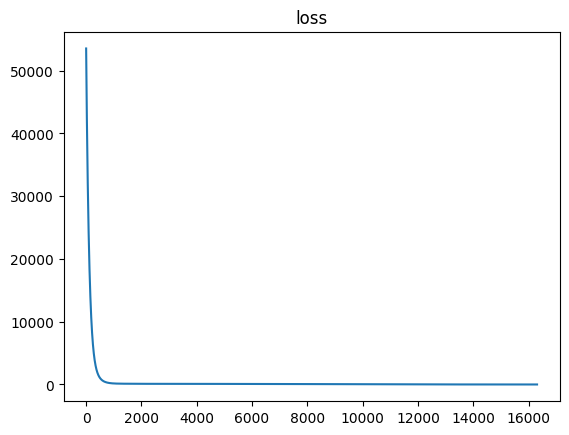

final loss 0.49950630189413964


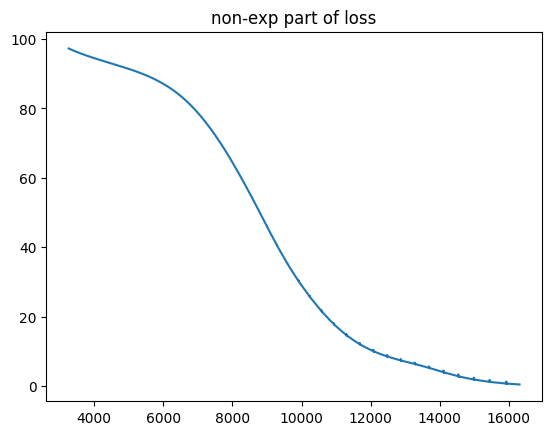

Function custom_tucker time:  0:02:44.839521


In [73]:
from datetime import datetime
start_time = datetime.now()
G_t, U_t = custom_tucker(data, r=(10, 20, 30), iter_num = 100000, device=device, opt=optim.Adam, opt_params={'lr': 1e-3})
print("Function {} time: ".format(custom_tucker.__name__), datetime.now() - start_time)

In [74]:
for i in range(3):
    print(f"factor {i} mse: {((decomp.factors[i].T - U_t[i].detach().numpy()) ** 2).mean()}")

factor 0 mse: 0.5765491467706023
factor 1 mse: 0.5457657138191601
factor 2 mse: 0.5180551395324566


In [75]:
G_t

tensor([[[ 0.5410,  1.0870,  0.1767,  ...,  0.8774,  1.2703,  1.4336],
         [ 0.2429,  0.4758,  1.2176,  ...,  0.5619,  0.8269,  0.2900],
         [ 1.8522,  0.0024, -0.4689,  ...,  0.6813,  1.1396,  0.6188],
         ...,
         [ 1.1137,  0.4460,  0.2495,  ...,  1.0510,  0.9067, -0.4842],
         [ 0.2919,  0.7616,  0.5141,  ...,  0.8151,  0.5777,  0.2422],
         [-0.1193,  0.1390,  0.7491,  ...,  0.4919,  0.2446,  0.5626]],

        [[ 0.0886,  0.5761,  0.5946,  ...,  0.4946, -0.2064, -0.3392],
         [ 0.3720, -0.3735, -0.3865,  ...,  0.5477,  0.7494,  0.3354],
         [ 0.1000, -0.0124, -0.1034,  ..., -0.3934,  0.6414, -0.7168],
         ...,
         [ 0.6929, -0.2375,  1.1625,  ..., -0.0126,  0.1561,  0.7208],
         [ 0.4012, -0.1460, -0.0192,  ...,  0.1158,  0.1658, -0.0082],
         [ 0.1700,  0.9773, -0.4378,  ...,  0.1965,  0.2502,  0.1765]],

        [[ 0.0701, -0.1635, -0.3430,  ..., -0.4062, -0.4209,  0.7113],
         [-0.1922, -0.3535,  0.3279,  ...,  0

In [76]:
decomp.core

array([[[ 7.44909192e+05,  1.05819102e+00,  2.48314821e+00, ...,
         -2.50970722e-01,  6.34038298e-01,  1.24920982e+00],
        [-1.54422079e+00, -3.17876813e+02,  1.48136511e+03, ...,
         -9.04578036e+01, -5.66316286e+01, -3.64311238e+01],
        [ 2.86760769e+00, -3.15898094e+02, -2.01711310e+03, ...,
          2.60243494e+01, -2.79126836e+01,  2.30695126e+01],
        ...,
        [ 8.81513830e-01, -2.84488074e+01, -1.44904997e+02, ...,
         -1.68815528e+02, -8.77243784e+01,  9.18201615e+01],
        [-1.28665805e+00, -7.43637990e+01,  7.16534714e+01, ...,
          1.75611539e+02,  5.41425298e+01,  2.09156089e+02],
        [ 1.24531735e+00,  7.19611202e+01,  5.32803079e+01, ...,
         -1.46524117e+02,  1.51738728e+02, -2.08409757e+01]],

       [[-7.73101031e-01, -3.91037840e+03,  1.49517071e+01, ...,
          1.38983782e+02,  5.97432447e+01,  1.39393500e+01],
        [ 3.55909096e+03, -1.83867125e+02,  6.66457458e+01, ...,
         -3.75139745e+01,  2.01222817e

In [77]:
print(f"core mse: {((decomp.core - G_t.detach().numpy()) ** 2).mean()}")

core mse: 92526500.94806471


разница ядер большая, а mse тот же - получил другое разложение

In [78]:
print(f"decomp mse: {((data.numpy() - repair_tensor(G_t, U_t).detach().numpy()) ** 2).mean()}")

decomp mse: 0.49890202305443143


### 4.2 Реализуйте цикл оптимизации параметров

Стоит параметры оптимизировать сразу на GPU

In [87]:
from itertools import product

In [88]:
iterations = [10000 * (i+1) for i in range(5)]
l_rates = [1e-3, 5e-4, 1e-4]
b1 = [0.3, 0.6, 0.9]
b2 = [0.3, 0.6, 0.9]
bet = list(product(b1, b2))
eps_list = [1e-09]
weights = [0]

params = list(product(iterations, l_rates, bet, eps_list, weights))

In [89]:
len(params)

135

iter0, params: (10000, 0.001, (0.3, 0.3), 1e-09, 0)
iter 1000 loss 98.71062524819847
iter 2000 loss 93.12712046528182
iter 3000 loss 90.78892905672014
iter 4000 loss 82.27444445827955
iter 5000 loss 73.65633575866272
iter 6000 loss 67.33353931241494
iter 7000 loss 59.989725406341485
iter 8000 loss 52.974962948933225
iter 9000 loss 49.49848622108338
iter 10000 loss 45.70640007873589


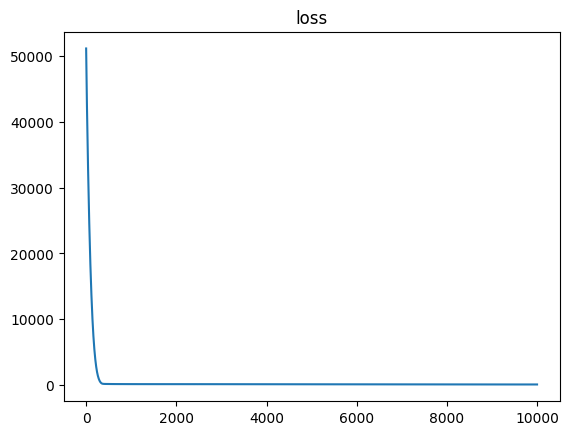

final loss 46.3564992372485


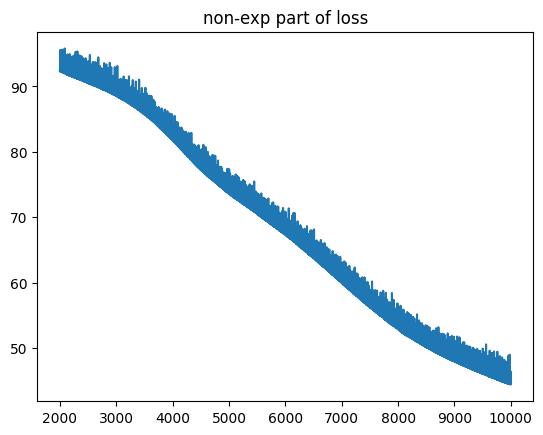

Function custom_tucker time:  0:01:35.875789
score: 46.35649923724852

iter1, params: (10000, 0.001, (0.3, 0.6), 1e-09, 0)
iter 1000 loss 99.81239282006426
iter 2000 loss 90.8804891118933
iter 3000 loss 85.76915076500391
iter 4000 loss 79.26179633422927
iter 5000 loss 74.39479454549038
iter 6000 loss 69.41111820188104
iter 7000 loss 63.056691215203244
iter 8000 loss 57.12126164851919
iter 9000 loss 53.52732237555178
iter 10000 loss 49.7866108841483


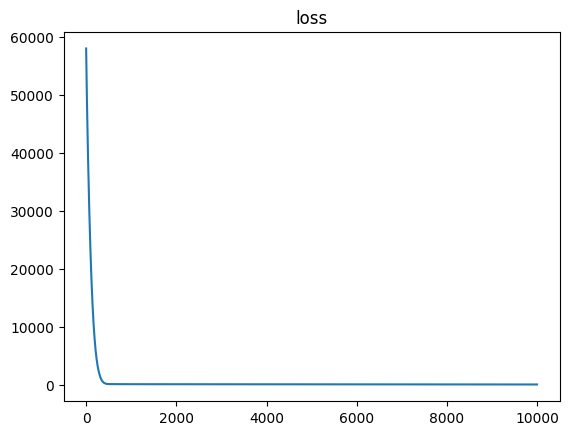

final loss 48.59727118075323


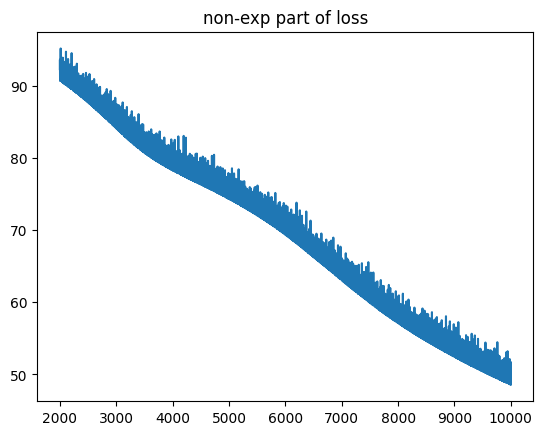

Function custom_tucker time:  0:01:34.934409
score: 48.59727118075321

iter2, params: (10000, 0.001, (0.3, 0.9), 1e-09, 0)
iter 1000 loss 99.23359006099838
iter 2000 loss 90.96496548882504
iter 3000 loss 84.08203226653112
iter 4000 loss 75.62256119736945
iter 5000 loss 68.85074203462017
iter 6000 loss 63.50444696209899
iter 7000 loss 58.5792869013168
iter 8000 loss 54.05570036181209
iter 9000 loss 50.40440351269601
iter 10000 loss 47.230660589203495


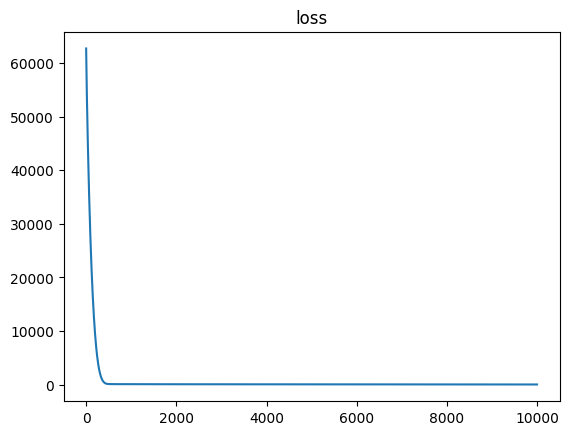

final loss 46.83466385076159


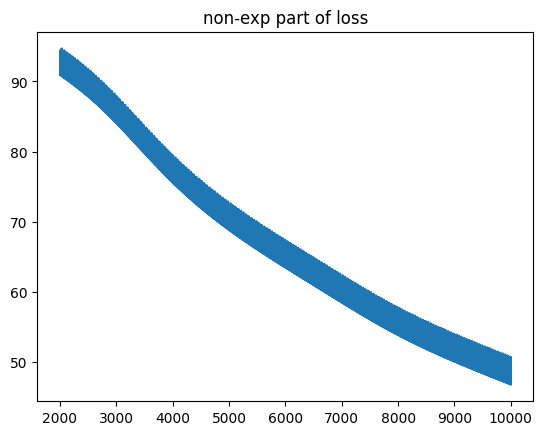

Function custom_tucker time:  0:01:42.559386
score: 46.83466385076158

iter3, params: (10000, 0.001, (0.6, 0.3), 1e-09, 0)
iter 1000 loss 94.22636125028497
iter 2000 loss 87.43647987177384
iter 3000 loss 76.41729971671718
iter 4000 loss 66.93084987304655
iter 5000 loss 57.68362534493243
iter 6000 loss 50.323930989797184
iter 7000 loss 43.07026290586233
iter 8000 loss 38.745119282729775
iter 9000 loss 35.81002916007895
iter 10000 loss 32.60717587989044


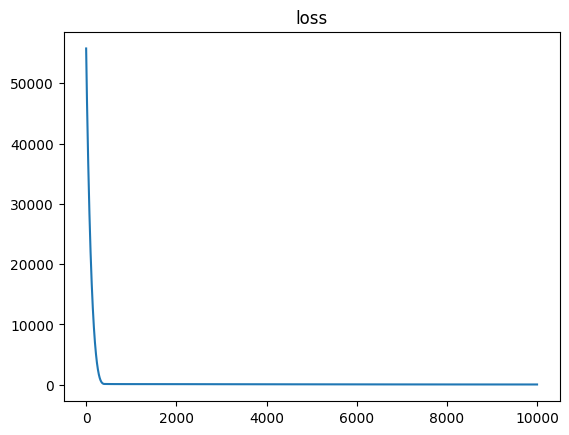

final loss 32.77786316619675


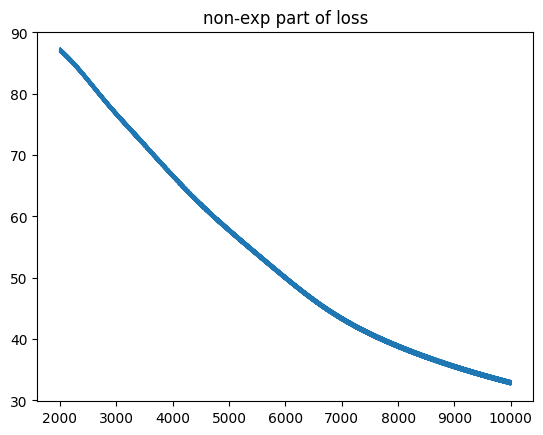

Function custom_tucker time:  0:01:34.679786
score: 32.77786316619674

iter4, params: (10000, 0.001, (0.6, 0.6), 1e-09, 0)
iter 1000 loss 92.38202591201933
iter 2000 loss 76.40240755848328
iter 3000 loss 64.76346189477161
iter 4000 loss 55.24424488216584
iter 5000 loss 49.24116173890227
iter 6000 loss 44.15515538673498
iter 7000 loss 39.691976961260615
iter 8000 loss 35.27107132702534
iter 9000 loss 31.307448858259757
iter 10000 loss 28.53152385268887


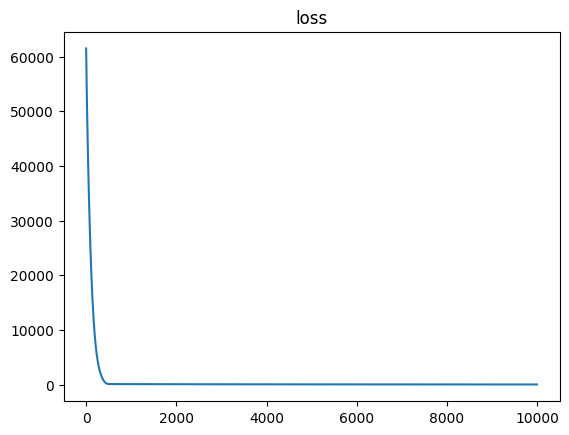

final loss 28.822217076570592


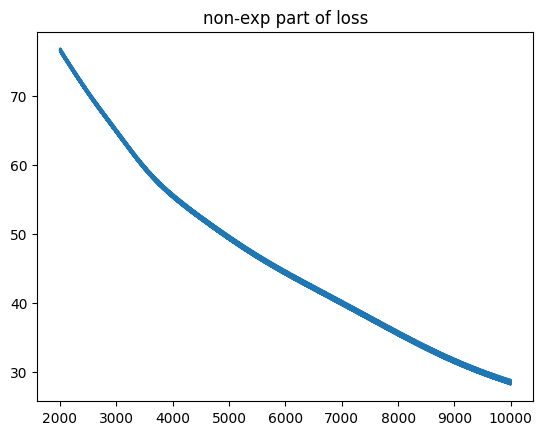

Function custom_tucker time:  0:01:34.821898
score: 28.8222170765706

iter5, params: (10000, 0.001, (0.6, 0.9), 1e-09, 0)
iter 1000 loss 92.73057721594594
iter 2000 loss 79.99389922443287
iter 3000 loss 59.9223169052581
iter 4000 loss 47.67972580226996
iter 5000 loss 42.34059958422838
iter 6000 loss 36.59148987546772
iter 7000 loss 32.270957498280474
iter 8000 loss 29.39706728706149
iter 9000 loss 26.6420574572185
iter 10000 loss 24.389932045523604


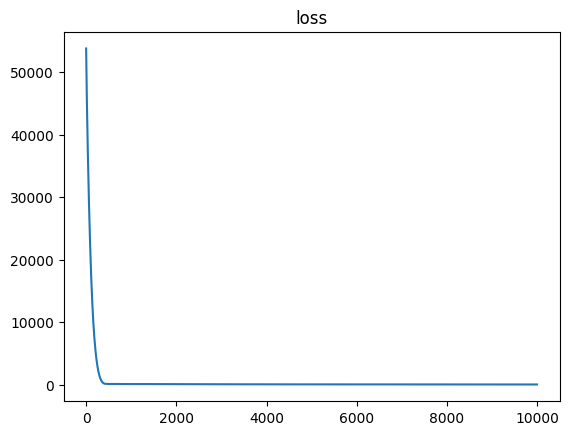

final loss 24.375527237812157


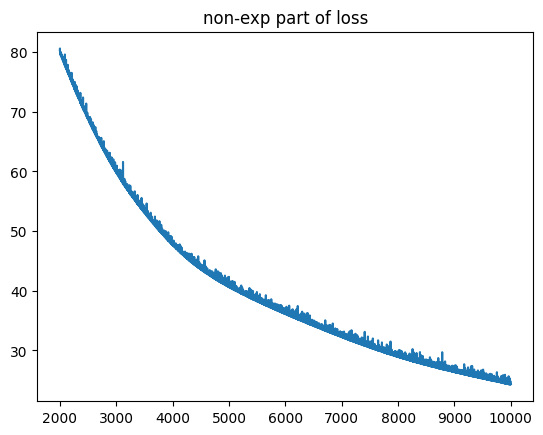

Function custom_tucker time:  0:01:34.673527
score: 24.375527237812147

iter6, params: (10000, 0.001, (0.9, 0.3), 1e-09, 0)
iter 1000 loss 112.80539549652835
iter 2000 loss 104.06285359528242
iter 3000 loss 96.8131646571695
iter 4000 loss 98.05700654256292
iter 5000 loss 95.24097911605304
iter 6000 loss 89.21381395065012
iter 7000 loss 90.5437814976532
iter 8000 loss 82.86522580950775
iter 9000 loss 82.18760263746414
iter 10000 loss 76.99221927659744


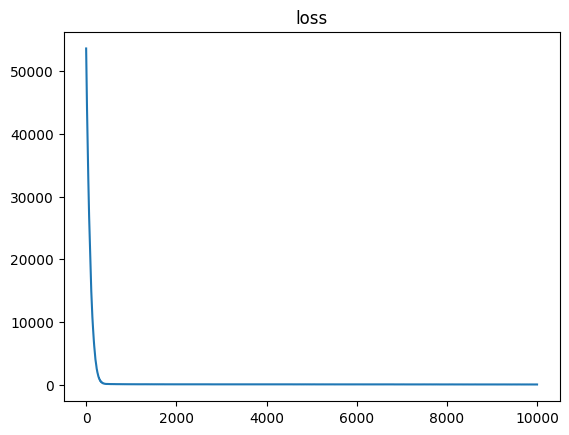

final loss 75.14121936290624


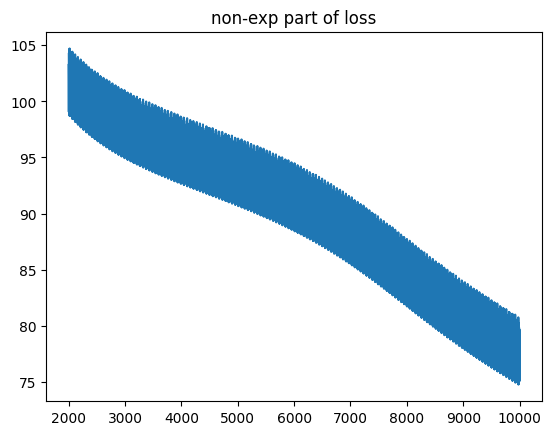

Function custom_tucker time:  0:01:34.469737
score: 75.14121936290624

iter7, params: (10000, 0.001, (0.9, 0.6), 1e-09, 0)
iter 1000 loss 94.8868254493221
iter 2000 loss 59.723066439218115
iter 3000 loss 35.073802205644725
iter 4000 loss 23.59904923017462
iter 5000 loss 16.254725619331932
iter 6000 loss 7.942530861091301
iter 7000 loss 3.661051166881841
iter 8000 loss 2.2040103194178897
iter 9000 loss 1.6523235471913775
iter 10000 loss 1.4023780314862535


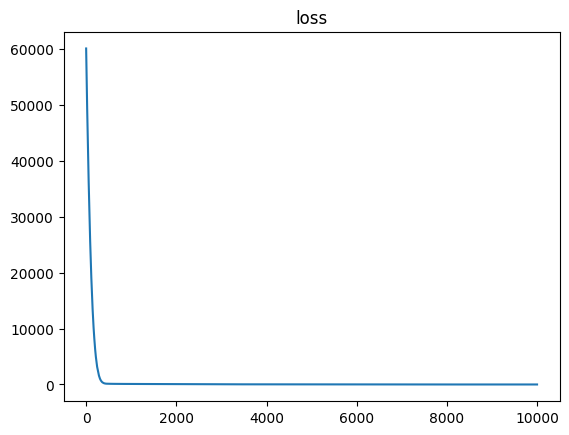

final loss 1.398111443265736


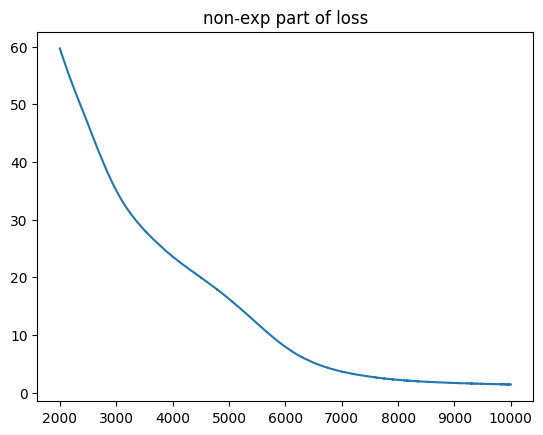

Function custom_tucker time:  0:01:34.404159
score: 1.3981114432657364

iter8, params: (10000, 0.001, (0.9, 0.9), 1e-09, 0)
iter 1000 loss 63.499031437957285
iter 2000 loss 31.058107840324595
iter 3000 loss 20.252707959987035
iter 4000 loss 13.087848730931933
iter 5000 loss 7.97158042094024
iter 6000 loss 4.738942987811907
iter 7000 loss 2.767839058441405
iter 8000 loss 1.6274824077676215
iter 9000 loss 0.9800782582470557
iter 10000 loss 0.6261385741275232


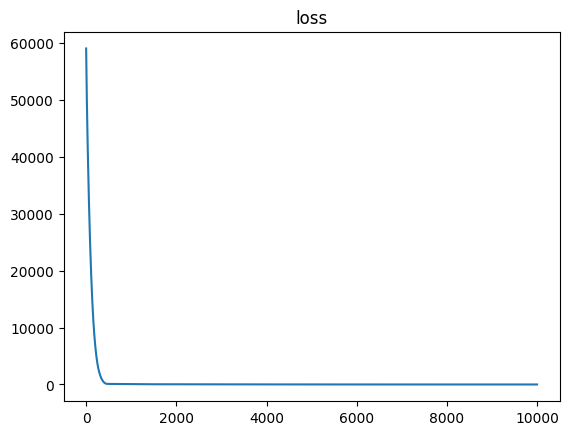

final loss 0.6373121550908749


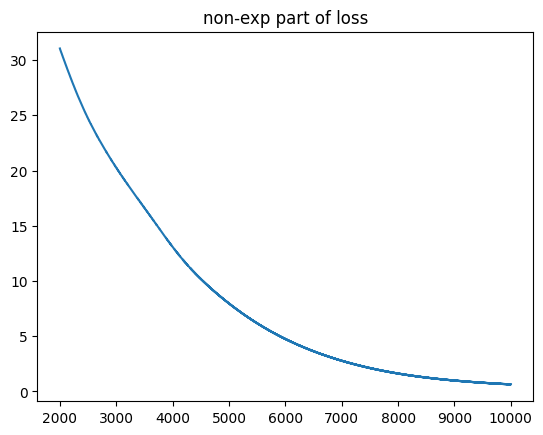

Function custom_tucker time:  0:01:31.931307
score: 0.6373121550908748

iter9, params: (10000, 0.0005, (0.3, 0.3), 1e-09, 0)
iter 1000 loss 114.94592921029691
iter 2000 loss 91.44558616237065
iter 3000 loss 84.76719636311036
iter 4000 loss 74.39505095832297
iter 5000 loss 65.46659750937933
iter 6000 loss 58.11390633353722
iter 7000 loss 53.0694938704453
iter 8000 loss 47.077376095828626
iter 9000 loss 42.90455594691366
iter 10000 loss 40.08862840723128


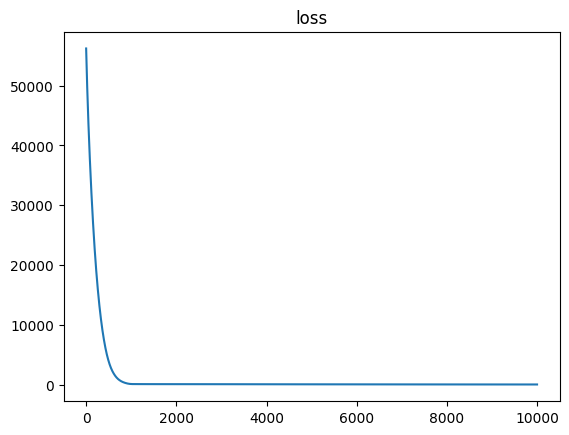

final loss 39.55812464301017


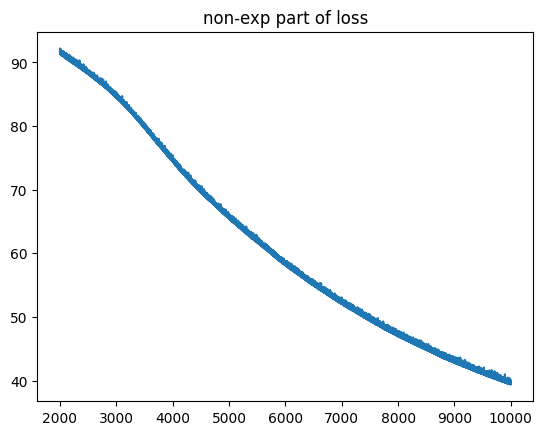

Function custom_tucker time:  0:01:37.954292
score: 39.55812464301015

iter10, params: (10000, 0.0005, (0.3, 0.6), 1e-09, 0)
iter 1000 loss 111.18581065427296
iter 2000 loss 92.26738494875316
iter 3000 loss 84.64770660184126
iter 4000 loss 73.49906558135037
iter 5000 loss 66.67577899887176
iter 6000 loss 61.011924590476035
iter 7000 loss 55.26840224687044
iter 8000 loss 50.90035345429474
iter 9000 loss 47.6520621090102
iter 10000 loss 45.06258664614753


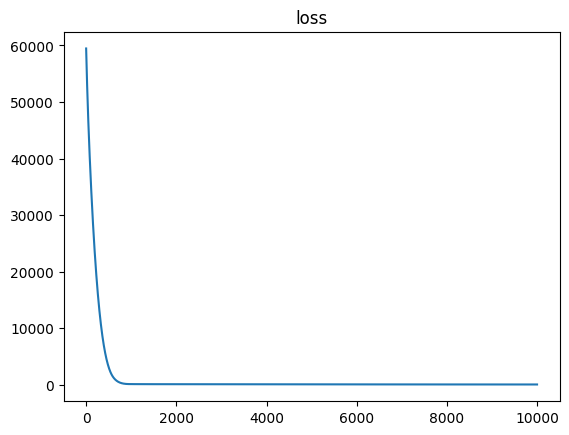

final loss 44.71112258037217


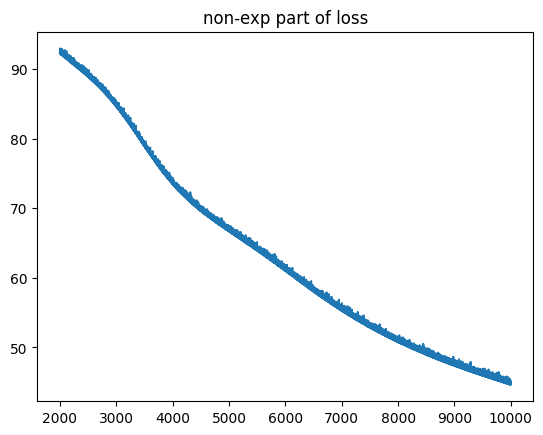

Function custom_tucker time:  0:01:31.947790
score: 44.71112258037216

iter11, params: (10000, 0.0005, (0.3, 0.9), 1e-09, 0)
iter 1000 loss 108.34288886336235
iter 2000 loss 92.69888478830612
iter 3000 loss 83.61663426922792
iter 4000 loss 73.10260161119184
iter 5000 loss 65.82531487693232
iter 6000 loss 60.78232460541703
iter 7000 loss 55.43482303396352
iter 8000 loss 50.50324293858992
iter 9000 loss 46.63254831268521
iter 10000 loss 43.39333325047222


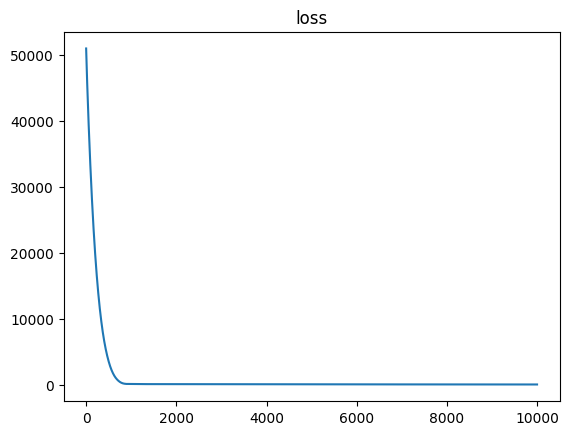

final loss 43.39654912174459


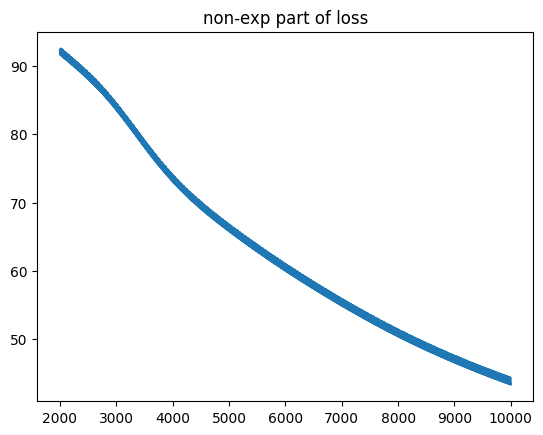

Function custom_tucker time:  0:01:32.860102
score: 43.39654912174457

iter12, params: (10000, 0.0005, (0.6, 0.3), 1e-09, 0)
iter 1000 loss 100.67752020896033
iter 2000 loss 87.4877203379654
iter 3000 loss 73.29957587194316
iter 4000 loss 62.93655248463859
iter 5000 loss 55.64918812832129
iter 6000 loss 48.866400976106064
iter 7000 loss 43.78113272138732
iter 8000 loss 39.92007820789113
iter 9000 loss 36.412369285630035
iter 10000 loss 33.44708457874216


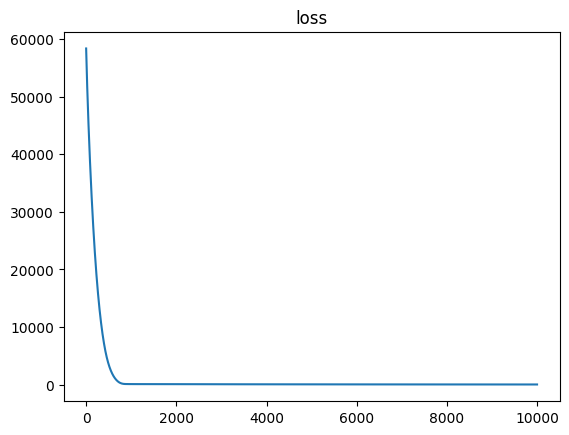

final loss 33.53481986501347


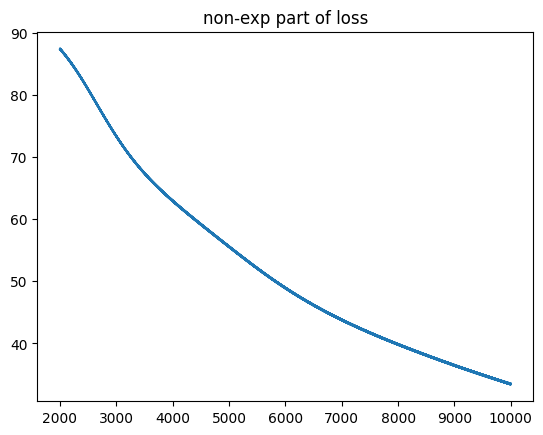

Function custom_tucker time:  0:01:34.845256
score: 33.53481986501346

iter13, params: (10000, 0.0005, (0.6, 0.6), 1e-09, 0)
iter 1000 loss 100.773279432556
iter 2000 loss 83.74995757046014
iter 3000 loss 67.66218410091906
iter 4000 loss 57.7945130748776
iter 5000 loss 50.03866108715733
iter 6000 loss 43.72444975550125
iter 7000 loss 38.65646887614948
iter 8000 loss 34.91335110062213
iter 9000 loss 31.895074454073498
iter 10000 loss 29.348791812819936


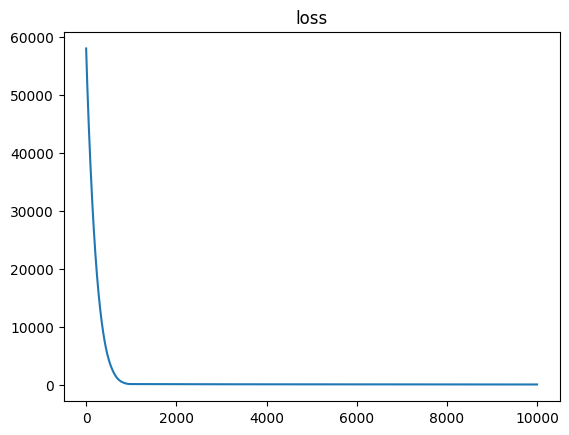

final loss 29.247043387990104


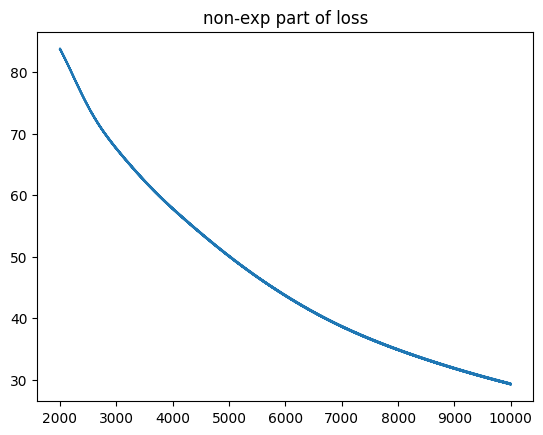

Function custom_tucker time:  0:01:36.570646
score: 29.247043387990093

iter14, params: (10000, 0.0005, (0.6, 0.9), 1e-09, 0)
iter 1000 loss 101.97138827232023
iter 2000 loss 85.90407157491296
iter 3000 loss 67.94757460366496
iter 4000 loss 53.98453674984667
iter 5000 loss 46.538388124265204
iter 6000 loss 41.193724347019426
iter 7000 loss 36.86241266163411
iter 8000 loss 33.41044095464998
iter 9000 loss 30.240126476715606
iter 10000 loss 27.44634250570482


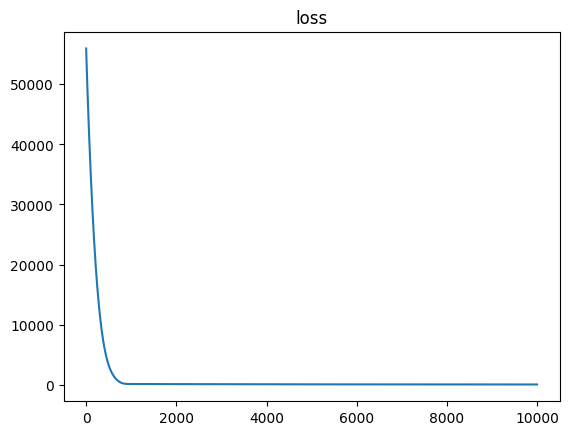

final loss 27.442939163230427


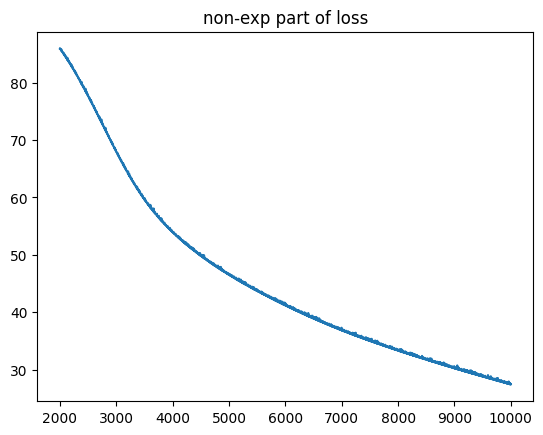

Function custom_tucker time:  0:01:35.974878
score: 27.442939163230452

iter15, params: (10000, 0.0005, (0.9, 0.3), 1e-09, 0)
iter 1000 loss 133.50390741177387
iter 2000 loss 102.83762092713982
iter 3000 loss 97.44311580814927
iter 4000 loss 92.91120759940003
iter 5000 loss 90.92660968320894
iter 6000 loss 86.8778261140741
iter 7000 loss 84.61017102572568
iter 8000 loss 82.87036979683252
iter 9000 loss 80.86254185500161
iter 10000 loss 78.96006373303548


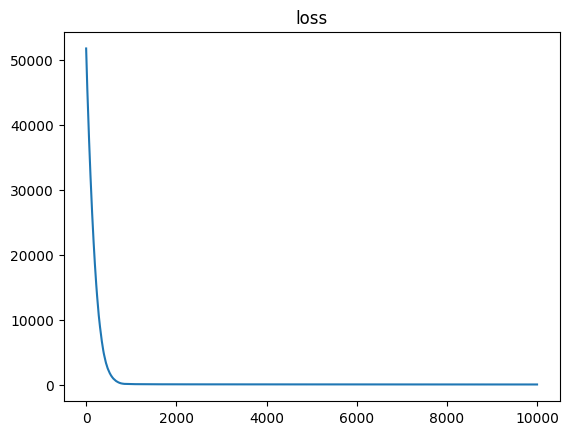

final loss 78.49496486587367


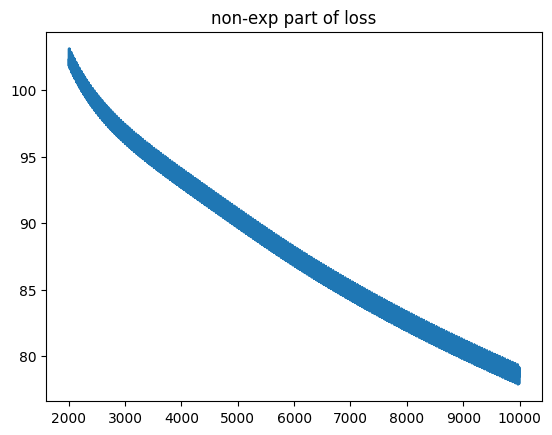

Function custom_tucker time:  0:01:34.585149
score: 78.49496486587367

iter16, params: (10000, 0.0005, (0.9, 0.6), 1e-09, 0)
iter 1000 loss 522.0041114143426
iter 2000 loss 94.85860092021576
iter 3000 loss 76.90209296273144
iter 4000 loss 57.30470109611836
iter 5000 loss 42.445443779492145
iter 6000 loss 31.146180020778992
iter 7000 loss 20.95028945423048
iter 8000 loss 13.048097322547655
iter 9000 loss 7.503368137591912
iter 10000 loss 4.061193822072853


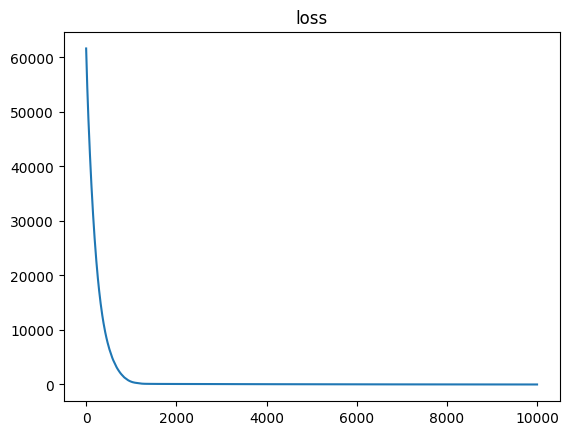

final loss 4.056703259372111


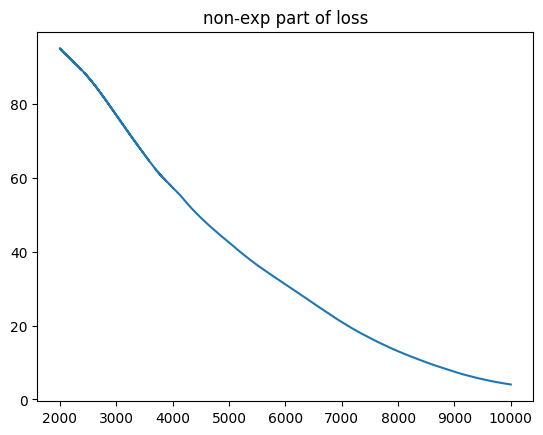

Function custom_tucker time:  0:01:37.501965
score: 4.056703259372112

iter17, params: (10000, 0.0005, (0.9, 0.9), 1e-09, 0)
iter 1000 loss 88.62090306223024
iter 2000 loss 39.48593020726698
iter 3000 loss 24.414586683107
iter 4000 loss 14.764729485184048
iter 5000 loss 9.153319044243835
iter 6000 loss 5.434100214305594
iter 7000 loss 3.3092295228685464
iter 8000 loss 2.209997735406114
iter 9000 loss 1.5505602403815042
iter 10000 loss 1.05557034699799


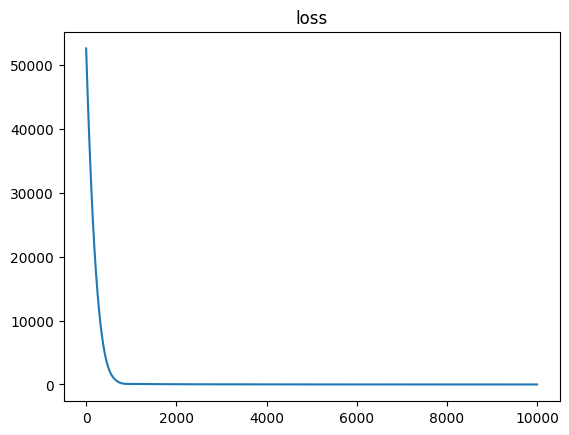

final loss 1.0535441452582444


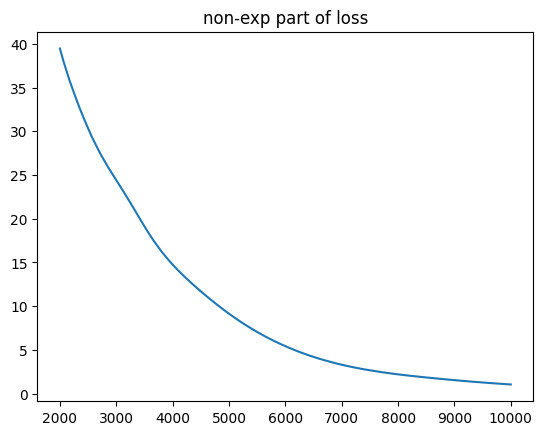

Function custom_tucker time:  0:01:40.907844
score: 1.0535441452582448

iter18, params: (10000, 0.0001, (0.3, 0.3), 1e-09, 0)
iter 1000 loss 19086.146981605158
iter 2000 loss 5479.956947663915
iter 3000 loss 1313.8199775827866
iter 4000 loss 240.31276720076505
iter 5000 loss 92.69549242853431
iter 6000 loss 85.43968462213742
iter 7000 loss 75.48138075212158
iter 8000 loss 64.95921178507092
iter 9000 loss 57.50006689534284
iter 10000 loss 52.14067138375174


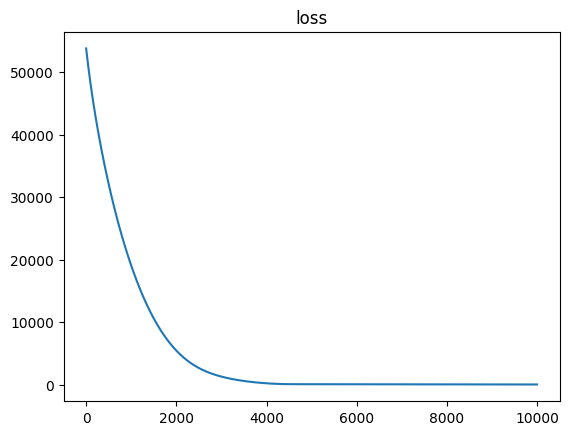

final loss 52.14507818533268


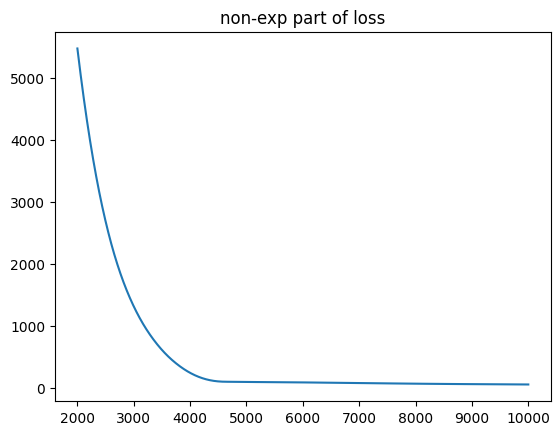

Function custom_tucker time:  0:01:36.903998
score: 52.14507818533264

iter19, params: (10000, 0.0001, (0.3, 0.6), 1e-09, 0)
iter 1000 loss 22439.23911967928
iter 2000 loss 7613.964749153488
iter 3000 loss 2014.8831535608738
iter 4000 loss 306.66686072882175
iter 5000 loss 92.15972520227639
iter 6000 loss 86.1069791205727
iter 7000 loss 79.78050673040987
iter 8000 loss 73.32090626757346
iter 9000 loss 66.35845750498342
iter 10000 loss 59.04646429103245


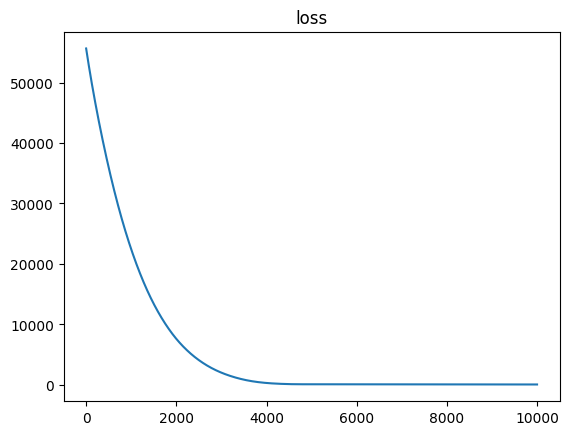

final loss 59.05782471981562


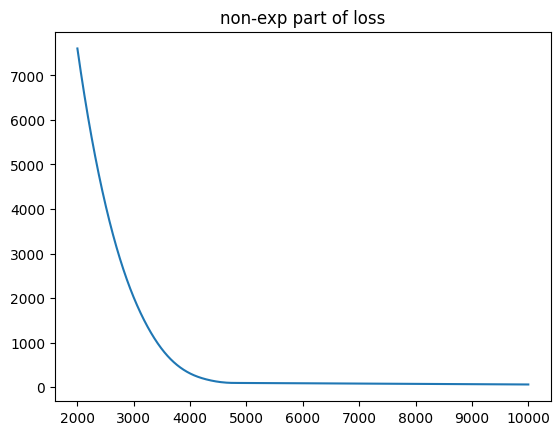

Function custom_tucker time:  0:01:34.334837
score: 59.0578247198157

iter20, params: (10000, 0.0001, (0.3, 0.9), 1e-09, 0)
iter 1000 loss 23658.82998641124
iter 2000 loss 8841.83889308427
iter 3000 loss 3183.609206904178
iter 4000 loss 1085.0767770067248
iter 5000 loss 315.59626469945596
iter 6000 loss 99.47960773547469
iter 7000 loss 79.17592546117793
iter 8000 loss 69.55087294840119
iter 9000 loss 60.750409050159156
iter 10000 loss 53.15098687400642


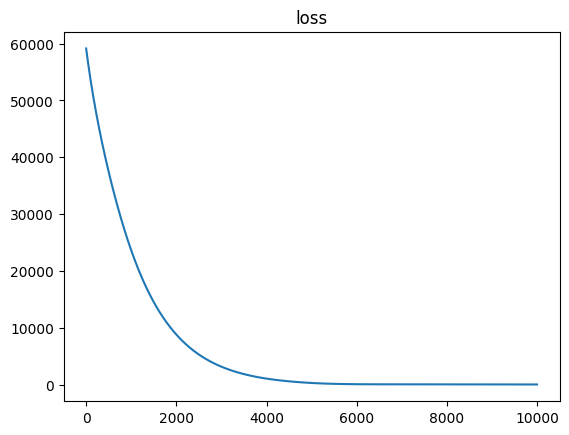

final loss 53.14513240050873


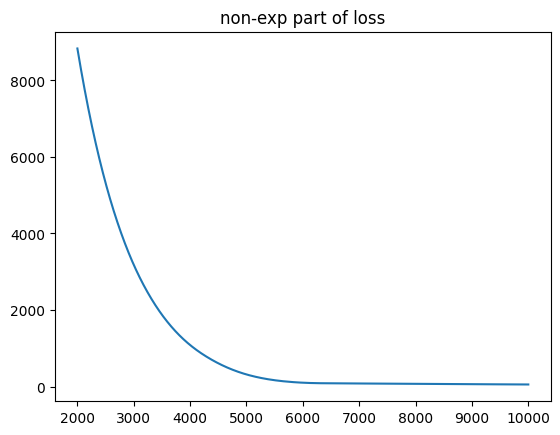

Function custom_tucker time:  0:01:40.770750
score: 53.14513240050867

iter21, params: (10000, 0.0001, (0.6, 0.3), 1e-09, 0)
iter 1000 loss 20834.725248603012
iter 2000 loss 7263.4075649226625
iter 3000 loss 2123.991501549174
iter 4000 loss 340.47968958752267
iter 5000 loss 95.1481563182798
iter 6000 loss 86.02117049244319
iter 7000 loss 75.44092628757646
iter 8000 loss 63.54406527764885
iter 9000 loss 54.643314545634546
iter 10000 loss 48.11459700577048


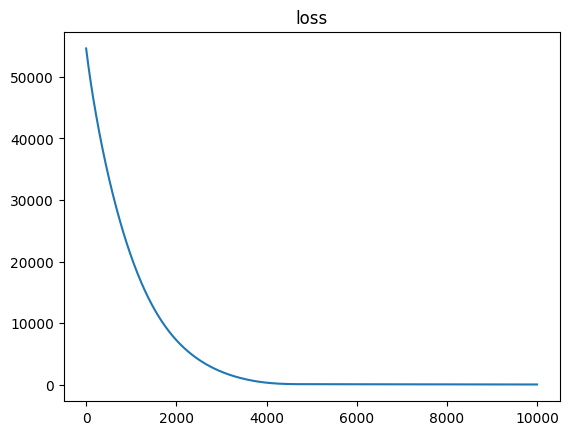

final loss 48.100080793367624


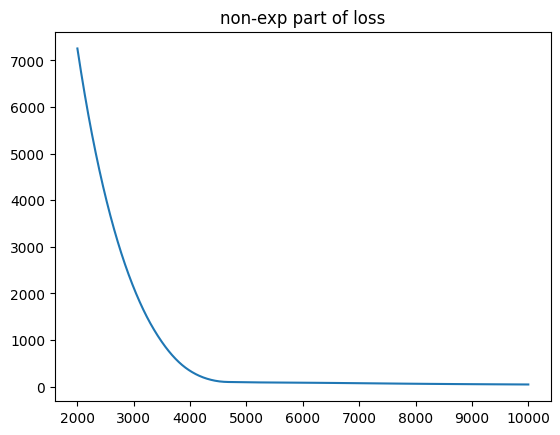

Function custom_tucker time:  0:01:36.944488
score: 48.1000807933676

iter22, params: (10000, 0.0001, (0.6, 0.6), 1e-09, 0)
iter 1000 loss 23929.570713045538
iter 2000 loss 8471.413656913308
iter 3000 loss 2991.0830251802195
iter 4000 loss 811.7842070708841
iter 5000 loss 123.05565327348495
iter 6000 loss 82.63636493047763
iter 7000 loss 65.86072118160982
iter 8000 loss 52.15680571509111
iter 9000 loss 42.76264673150538
iter 10000 loss 36.654865130449636


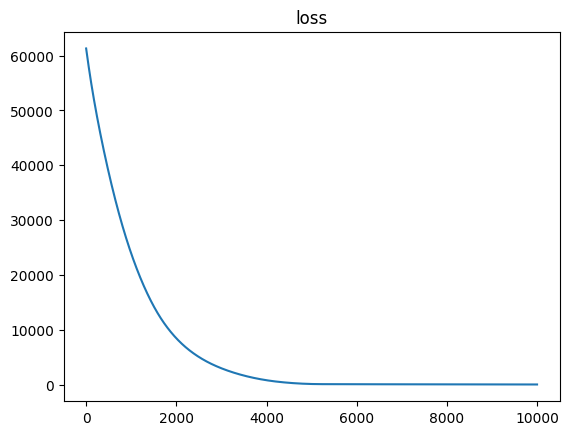

final loss 36.65027094416833


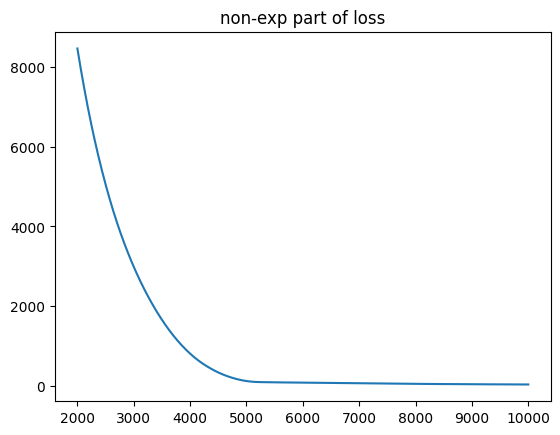

Function custom_tucker time:  0:01:35.913901
score: 36.65027094416834

iter23, params: (10000, 0.0001, (0.6, 0.9), 1e-09, 0)
iter 1000 loss 17054.758758836313
iter 2000 loss 5205.9166289370705
iter 3000 loss 1480.4121620289463
iter 4000 loss 291.56993044425593
iter 5000 loss 90.27185377750439
iter 6000 loss 78.92053888242748
iter 7000 loss 65.17141246334509
iter 8000 loss 54.0225640916568
iter 9000 loss 46.32424863066839
iter 10000 loss 40.817844122402484


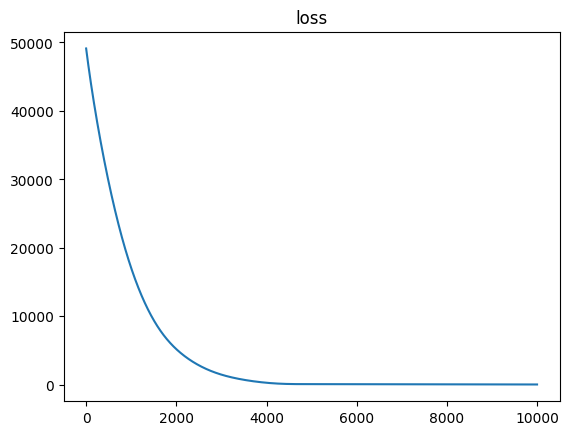

final loss 40.81075008050224


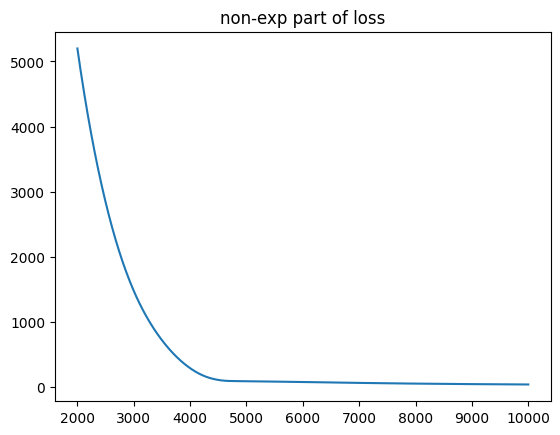

Function custom_tucker time:  0:01:35.639795
score: 40.810750080502224

iter24, params: (10000, 0.0001, (0.9, 0.3), 1e-09, 0)
iter 1000 loss 22080.10361555863
iter 2000 loss 6178.077633095257
iter 3000 loss 1032.2727928837614
iter 4000 loss 154.76068745545257
iter 5000 loss 110.68320657183686
iter 6000 loss 101.08120919888626
iter 7000 loss 96.38826546267478
iter 8000 loss 93.42800958278833
iter 9000 loss 91.23255451770355
iter 10000 loss 89.09558600803408


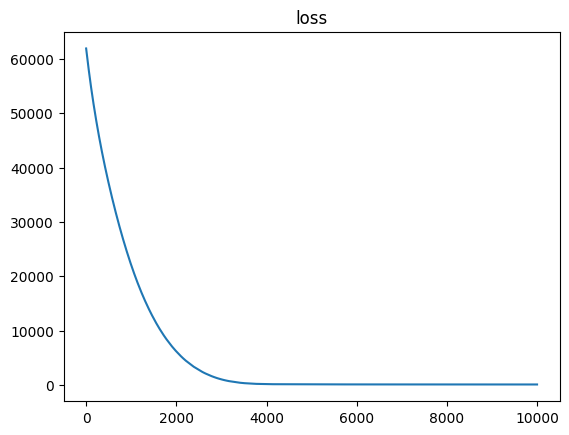

final loss 89.06077852345678


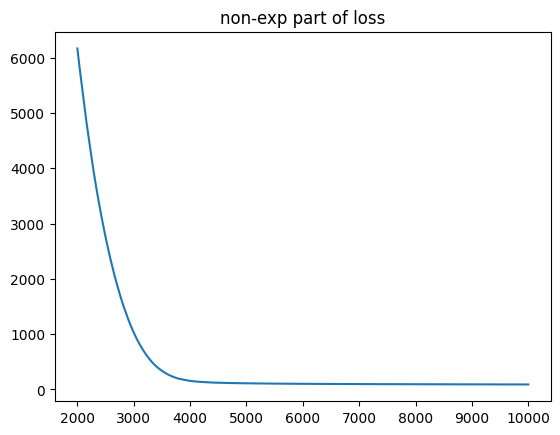

Function custom_tucker time:  0:01:34.380713
score: 89.06077852345676

iter25, params: (10000, 0.0001, (0.9, 0.6), 1e-09, 0)
iter 1000 loss 28621.567134275443
iter 2000 loss 11275.151754666054
iter 3000 loss 4083.043613293139
iter 4000 loss 1455.5082364150185
iter 5000 loss 502.10967052979765
iter 6000 loss 142.26669680950255
iter 7000 loss 100.56854168672629
iter 8000 loss 93.20795386603596
iter 9000 loss 87.65024005822762
iter 10000 loss 81.4924861229966


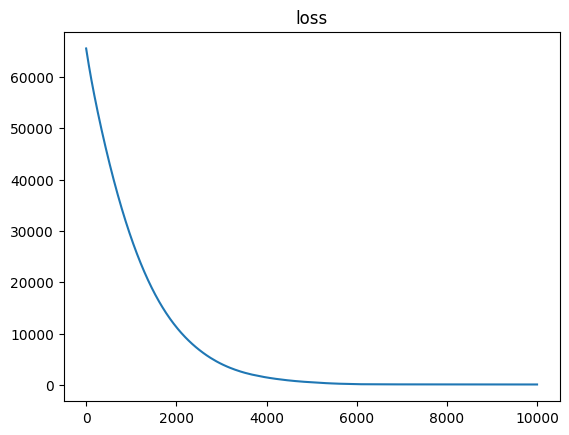

final loss 81.49128637466978


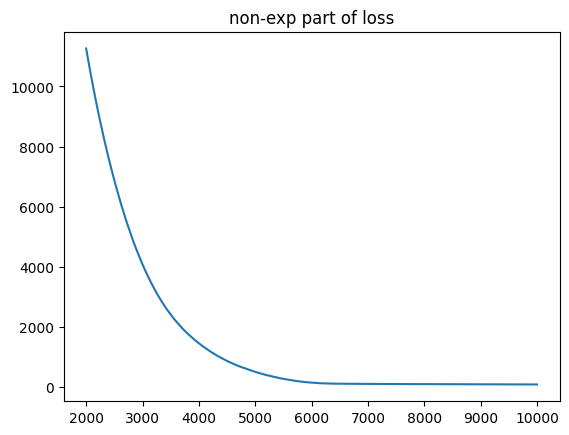

Function custom_tucker time:  0:01:35.854870
score: 81.49128637466978

iter26, params: (10000, 0.0001, (0.9, 0.9), 1e-09, 0)
iter 1000 loss 22422.137505478604
iter 2000 loss 7635.139222237702
iter 3000 loss 2143.377670735037
iter 4000 loss 511.8907839851547
iter 5000 loss 101.27847245561259
iter 6000 loss 76.3504979431713
iter 7000 loss 59.52229254374494
iter 8000 loss 46.25395293120251
iter 9000 loss 36.460760045968115
iter 10000 loss 28.948028881943117


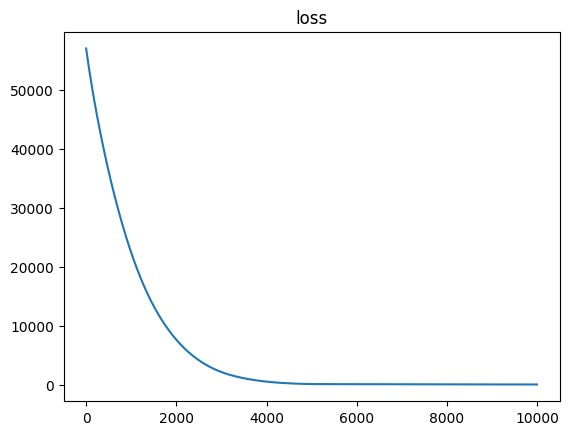

final loss 28.941336328650156


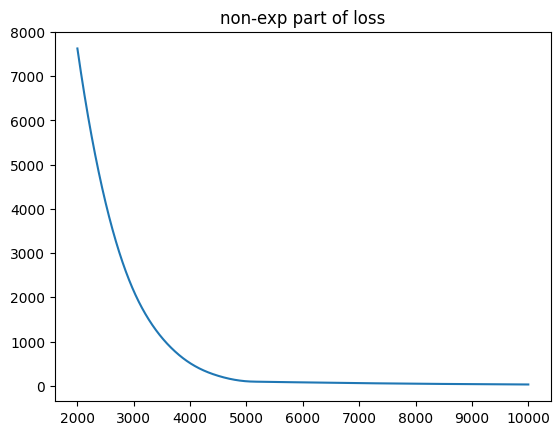

Function custom_tucker time:  0:01:40.423462
score: 28.941336328650138

iter27, params: (20000, 0.001, (0.3, 0.3), 1e-09, 0)
iter 2000 loss 88.01196279253192
iter 4000 loss 72.00984933849458
iter 6000 loss 56.223139219869175
iter 8000 loss 45.29298199098964
iter 10000 loss 40.65208907666732
iter 12000 loss 38.1599693609202
iter 14000 loss 33.12728270398402
iter 16000 loss 29.534079414883255
iter 18000 loss 26.33702865073556
iter 20000 loss 23.96117874576566


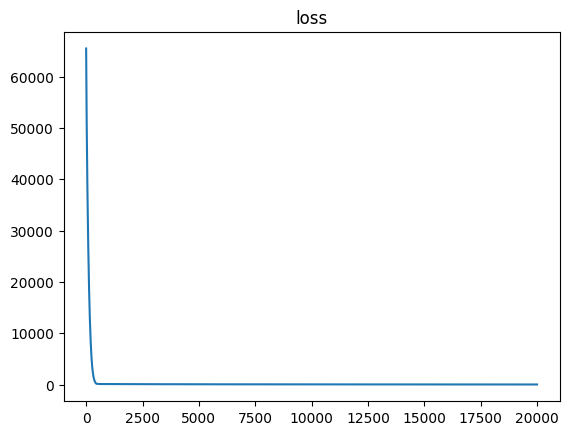

final loss 23.375879100698352


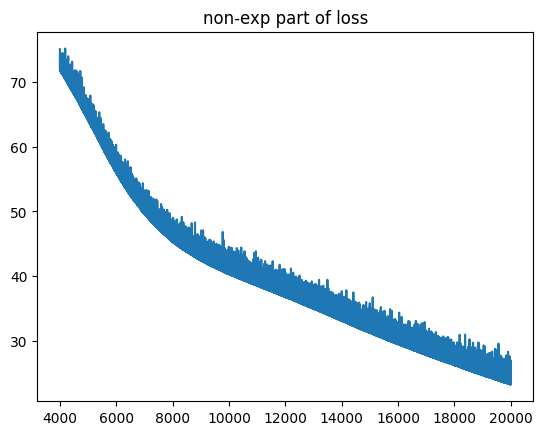

Function custom_tucker time:  0:03:09.683918
score: 23.37587910069835

iter28, params: (20000, 0.001, (0.3, 0.6), 1e-09, 0)
iter 2000 loss 89.65613016073016
iter 4000 loss 72.25718195431261
iter 6000 loss 60.47369636601048
iter 8000 loss 50.72898868195615
iter 10000 loss 44.87663772675419
iter 12000 loss 40.89210251794961
iter 14000 loss 33.64866314662992
iter 16000 loss 30.366802963332518
iter 18000 loss 29.144089847097387
iter 20000 loss 25.81241150387708


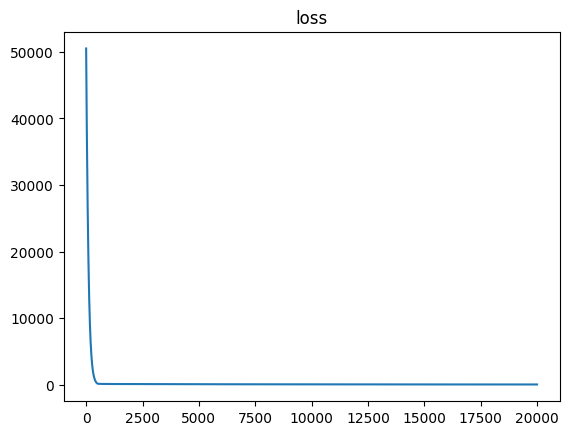

final loss 26.253909993263285


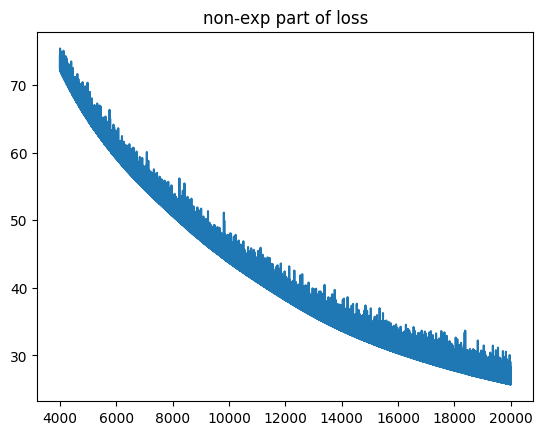

Function custom_tucker time:  0:03:04.219237
score: 26.253909993263264

iter29, params: (20000, 0.001, (0.3, 0.9), 1e-09, 0)
iter 2000 loss 93.04667097506278
iter 4000 loss 85.24978254312252
iter 6000 loss 68.82879839669147
iter 8000 loss 59.15010557680842
iter 10000 loss 51.243868875661384
iter 12000 loss 44.180880356315654
iter 14000 loss 38.49129256563323
iter 16000 loss 34.26554855125201
iter 18000 loss 31.08783623295934
iter 20000 loss 28.388441032786265


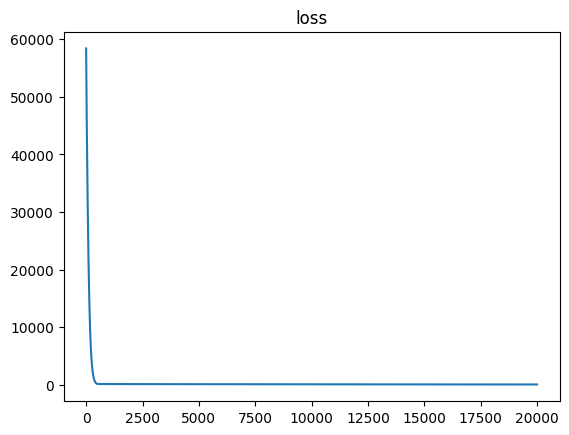

final loss 28.388698015777678


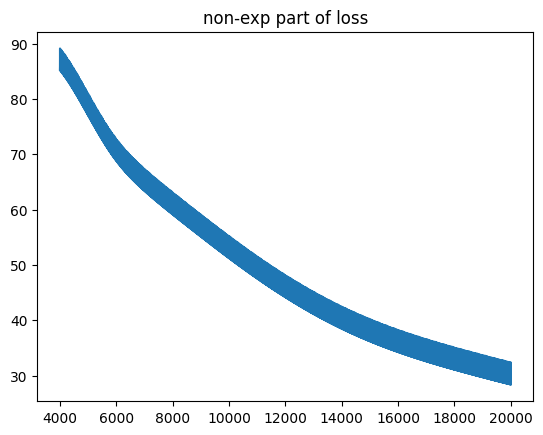

Function custom_tucker time:  0:03:06.082371
score: 28.38869801577769

iter30, params: (20000, 0.001, (0.6, 0.3), 1e-09, 0)
iter 2000 loss 81.54136341516859
iter 4000 loss 60.91152996838992
iter 6000 loss 48.98358640707927
iter 8000 loss 40.12863252350157
iter 10000 loss 34.65983590026173
iter 12000 loss 30.41169139168489
iter 14000 loss 25.60088790378047
iter 16000 loss 21.356587270332778
iter 18000 loss 18.247344165591795
iter 20000 loss 14.832650566073273


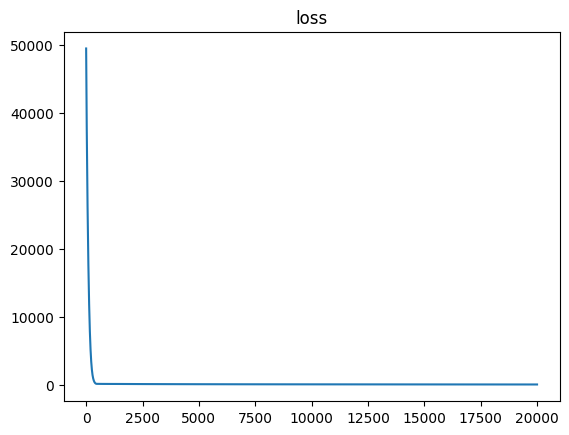

final loss 15.17305948527315


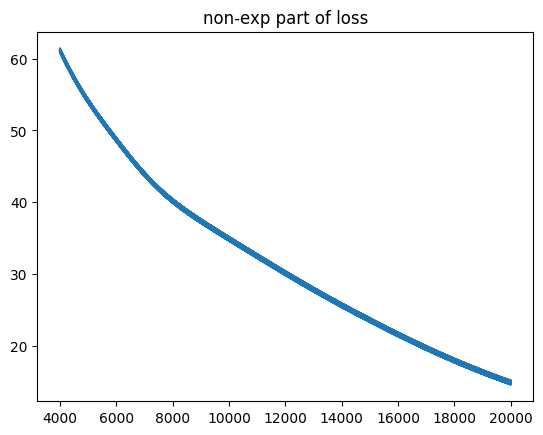

Function custom_tucker time:  0:03:04.281310
score: 15.173059485273145

iter31, params: (20000, 0.001, (0.6, 0.6), 1e-09, 0)
iter 2000 loss 80.79371074869927
iter 4000 loss 54.54252741383616
iter 6000 loss 41.67586158939623
iter 8000 loss 34.31501184638063
iter 10000 loss 29.402162232063166
iter 12000 loss 24.396056322901348
iter 14000 loss 19.96455761465669
iter 16000 loss 16.843629520506052
iter 18000 loss 14.644052803485678
iter 20000 loss 12.889617173369658


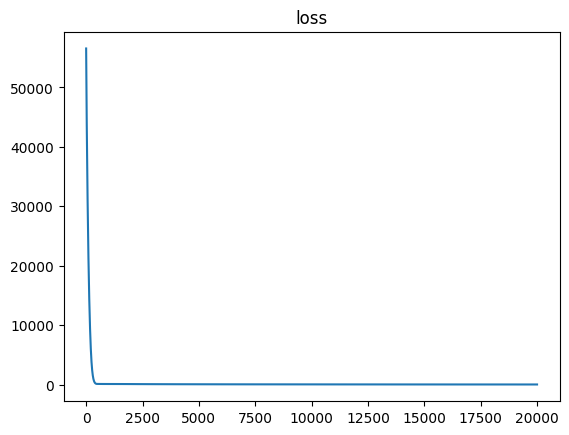

final loss 13.0364706097076


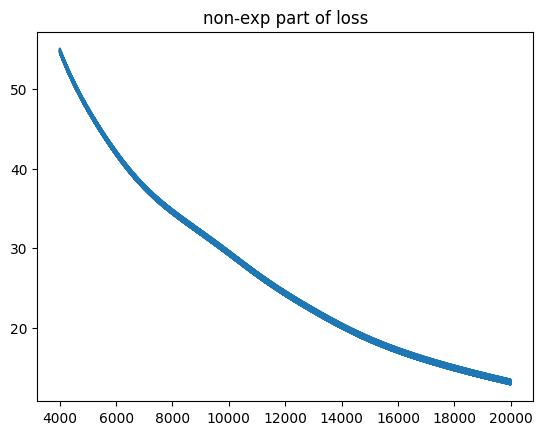

Function custom_tucker time:  0:03:04.912835
score: 13.036470609707596

iter32, params: (20000, 0.001, (0.6, 0.9), 1e-09, 0)
iter 2000 loss 74.98751153816669
iter 4000 loss 51.2231494749648
iter 6000 loss 35.70165934868272
iter 8000 loss 27.418398560543565
iter 10000 loss 21.76961100074545
iter 12000 loss 18.477139706752286
iter 14000 loss 15.385326690975425
iter 16000 loss 12.968297882404004
iter 18000 loss 10.367602142531943
iter 20000 loss 8.101180069285407


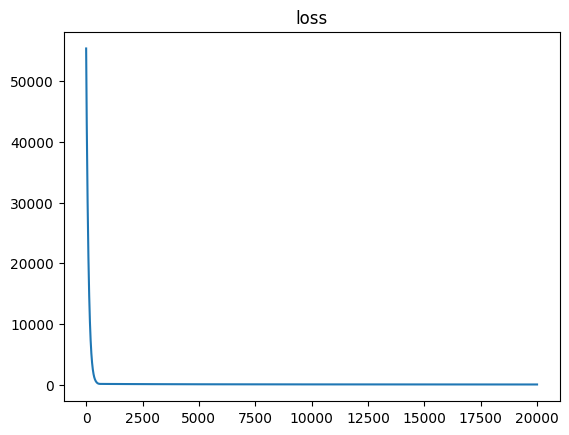

final loss 8.110611758386531


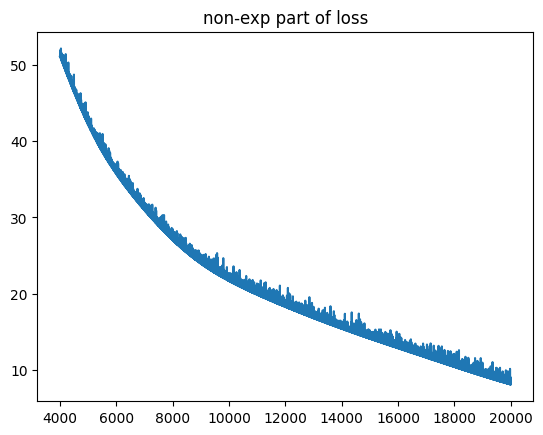

Function custom_tucker time:  0:03:04.848504
score: 8.110611758386533

iter33, params: (20000, 0.001, (0.9, 0.3), 1e-09, 0)
iter 2000 loss 102.85950926512609
iter 4000 loss 95.37646362733987
iter 6000 loss 92.77316088041965
iter 8000 loss 86.7368913643856
iter 10000 loss 75.01005348427128
iter 12000 loss 69.93275559538024
iter 14000 loss 62.693225618627764
iter 16000 loss 54.43509989483549
iter 18000 loss 55.24808952421591
iter 20000 loss 46.96022702783416


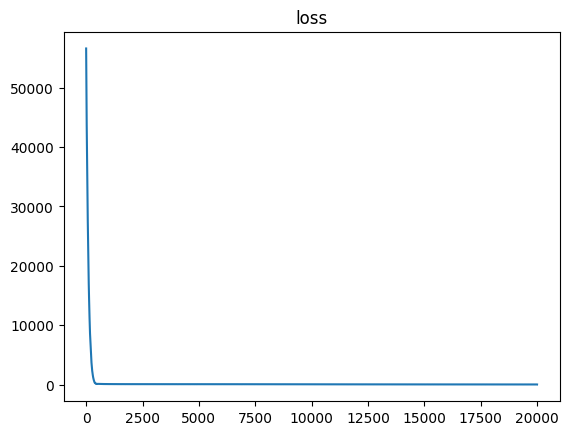

final loss 47.00595567926727


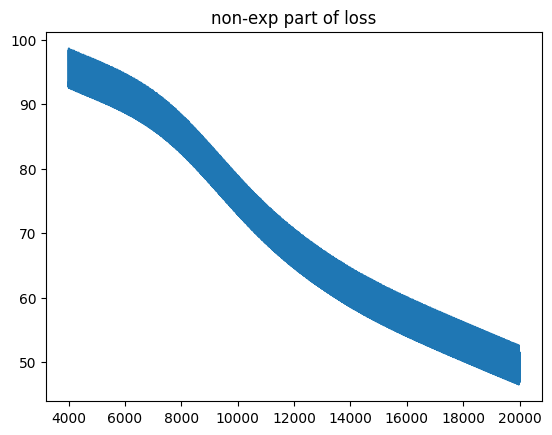

Function custom_tucker time:  0:03:03.821548
score: 47.00595567926722

iter34, params: (20000, 0.001, (0.9, 0.6), 1e-09, 0)
iter 2000 loss 59.22063509379203
iter 4000 loss 23.47825238751843
iter 6000 loss 7.80017044494682
iter 8000 loss 2.461944517701375
iter 10000 loss 1.1412392807721976
iter 12000 loss 0.5184069753795055


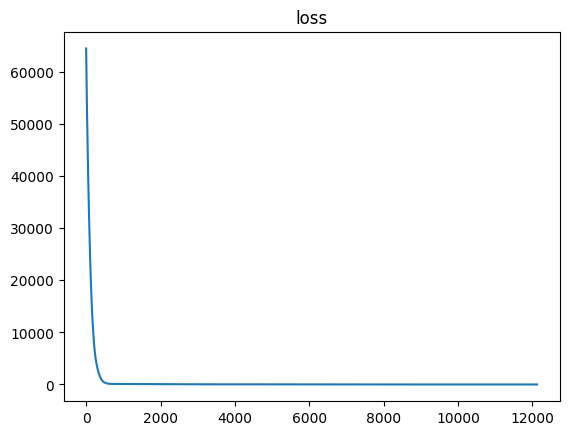

final loss 0.49703996293650876


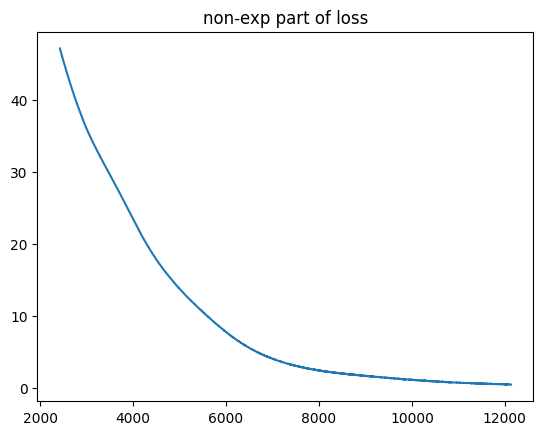

Function custom_tucker time:  0:01:51.908094
score: 0.5111267579375611

iter35, params: (20000, 0.001, (0.9, 0.9), 1e-09, 0)
iter 2000 loss 27.926424937652627
iter 4000 loss 10.460695654798668
iter 6000 loss 4.07890164037516
iter 8000 loss 1.7328731828878217
iter 10000 loss 0.5344319475217287


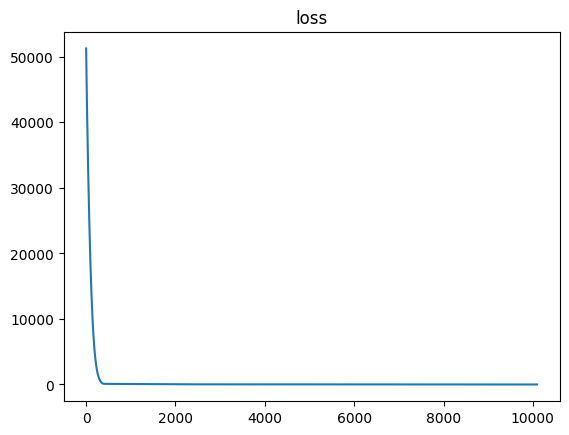

final loss 0.499262775699878


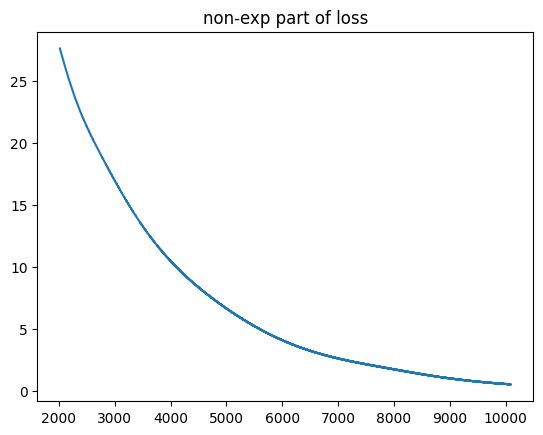

Function custom_tucker time:  0:01:32.793993
score: 0.5084007475990663

iter36, params: (20000, 0.0005, (0.3, 0.3), 1e-09, 0)
iter 2000 loss 91.97913589175675
iter 4000 loss 77.36898044264326
iter 6000 loss 58.009542019044765
iter 8000 loss 49.348518457718235
iter 10000 loss 42.21973767953306
iter 12000 loss 37.6055229288537
iter 14000 loss 33.92560291864414
iter 16000 loss 30.03870536986845
iter 18000 loss 26.34088582046588
iter 20000 loss 24.174321473015794


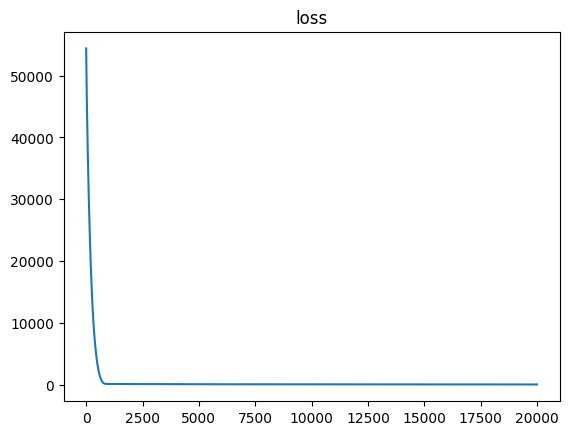

final loss 23.81718611105499


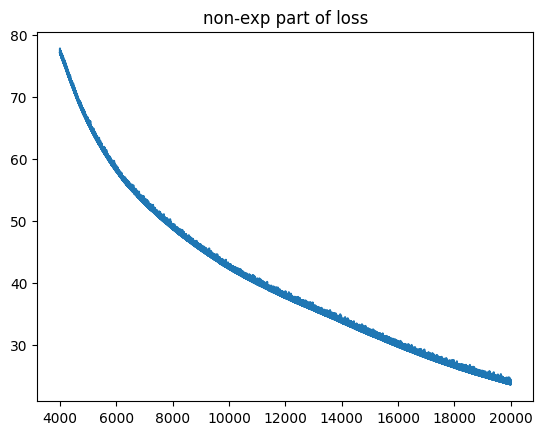

Function custom_tucker time:  0:03:04.550791
score: 23.817186111054976

iter37, params: (20000, 0.0005, (0.3, 0.6), 1e-09, 0)
iter 2000 loss 93.86520375266052
iter 4000 loss 86.53770977999454
iter 6000 loss 72.9611182819678
iter 8000 loss 56.89784144455199
iter 10000 loss 47.01610968272557
iter 12000 loss 39.663244440179994
iter 14000 loss 33.71769255069073
iter 16000 loss 29.8340474777153
iter 18000 loss 26.52910636408793
iter 20000 loss 24.055761389064084


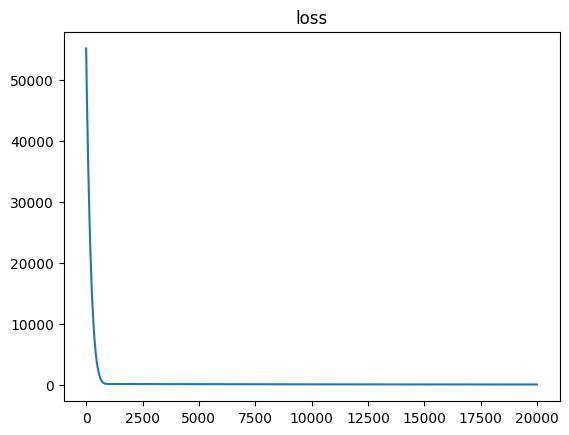

final loss 24.00509752043153


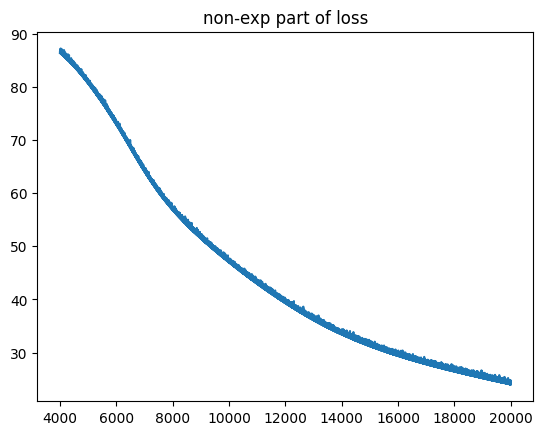

Function custom_tucker time:  0:03:07.136712
score: 24.005097520431537

iter38, params: (20000, 0.0005, (0.3, 0.9), 1e-09, 0)
iter 2000 loss 92.37406284295706
iter 4000 loss 74.66107576130716
iter 6000 loss 62.54553272559786
iter 8000 loss 54.02198699020703
iter 10000 loss 46.32684012143089
iter 12000 loss 39.79852943329426
iter 14000 loss 35.75000293172433
iter 16000 loss 32.63261427229629
iter 18000 loss 29.628293843474914
iter 20000 loss 26.665195598312486


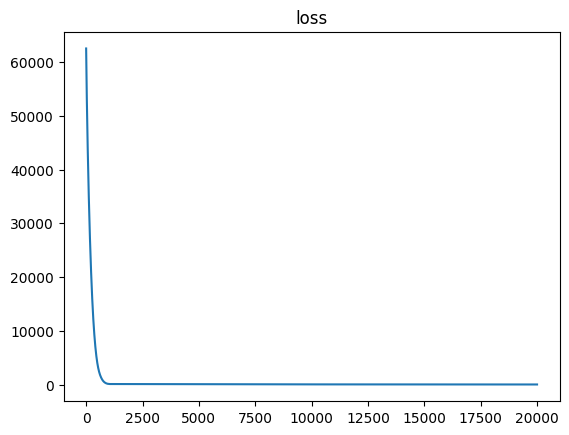

final loss 26.66635940749842


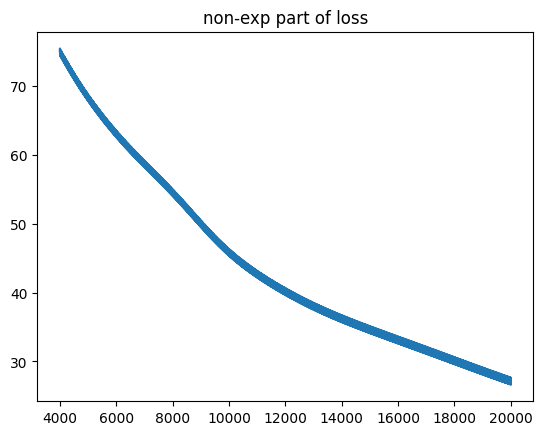

Function custom_tucker time:  0:03:03.338447
score: 26.666359407498415

iter39, params: (20000, 0.0005, (0.6, 0.3), 1e-09, 0)
iter 2000 loss 85.80852711738686
iter 4000 loss 57.57393499189654
iter 6000 loss 45.91504798213015
iter 8000 loss 38.861849469259106
iter 10000 loss 33.55244349445864
iter 12000 loss 29.46756895712573
iter 14000 loss 25.337904774119764
iter 16000 loss 21.551062139507703
iter 18000 loss 18.09215093575968
iter 20000 loss 15.279932329733725


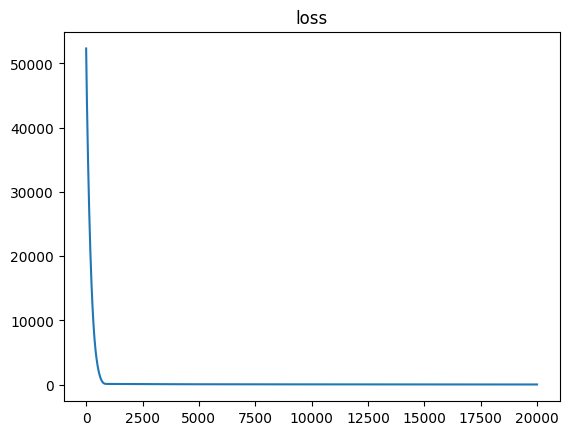

final loss 15.324452936585567


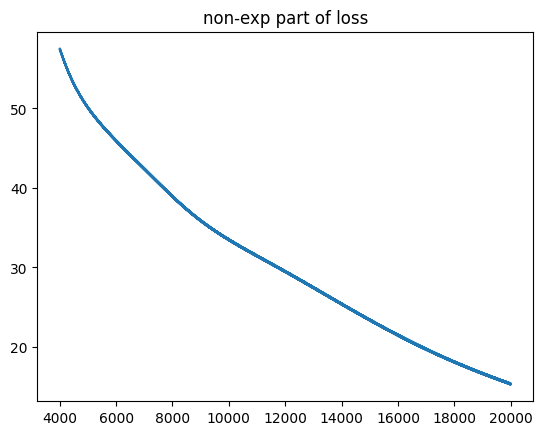

Function custom_tucker time:  0:03:03.098648
score: 15.32445293658558

iter40, params: (20000, 0.0005, (0.6, 0.6), 1e-09, 0)
iter 2000 loss 83.27744202476072
iter 4000 loss 54.12121804213629
iter 6000 loss 39.12214702827638
iter 8000 loss 30.973952272514513
iter 10000 loss 25.238409912042126
iter 12000 loss 20.84910413549538
iter 14000 loss 17.82199148943816
iter 16000 loss 15.480803309131614
iter 18000 loss 13.382281869965851
iter 20000 loss 11.182957217334321


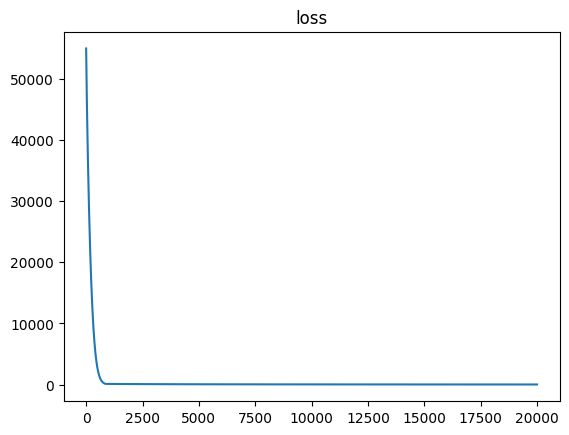

final loss 11.146490150048175


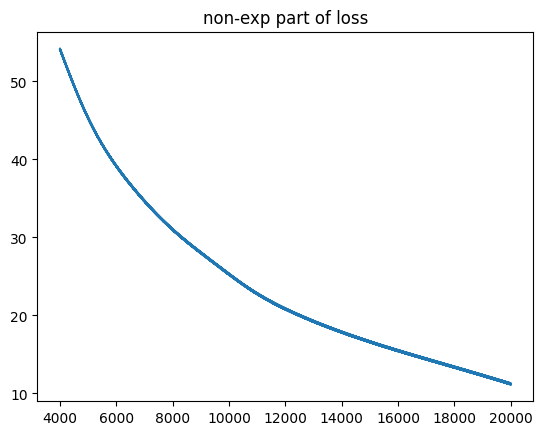

Function custom_tucker time:  0:03:05.932926
score: 11.14649015004818

iter41, params: (20000, 0.0005, (0.6, 0.9), 1e-09, 0)
iter 2000 loss 85.35469726743094
iter 4000 loss 51.9997867240654
iter 6000 loss 42.03163347407347
iter 8000 loss 33.584773674202864
iter 10000 loss 28.17508877102998
iter 12000 loss 24.11434485715893
iter 14000 loss 20.294476112468505
iter 16000 loss 17.119957334942942
iter 18000 loss 14.466287176319504
iter 20000 loss 11.904222542799046


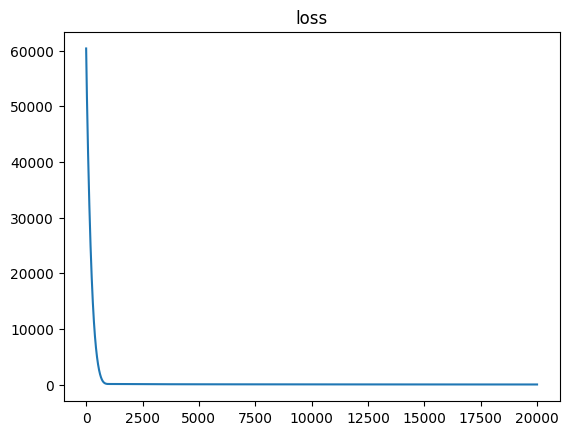

final loss 11.902790611407696


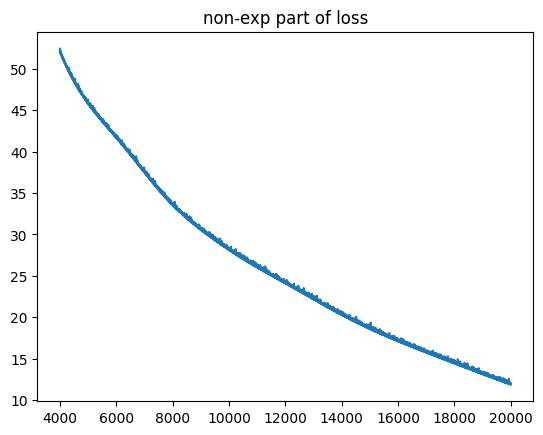

Function custom_tucker time:  0:03:03.495868
score: 11.902790611407696

iter42, params: (20000, 0.0005, (0.9, 0.3), 1e-09, 0)
iter 2000 loss 104.00156966129445
iter 4000 loss 94.06205094401643
iter 6000 loss 90.26033728155899
iter 8000 loss 82.44188313642256
iter 10000 loss 76.6174692553268
iter 12000 loss 70.89931025223352
iter 14000 loss 65.8009509357024
iter 16000 loss 59.23862690513054
iter 18000 loss 55.08472723045834
iter 20000 loss 51.21708333685509


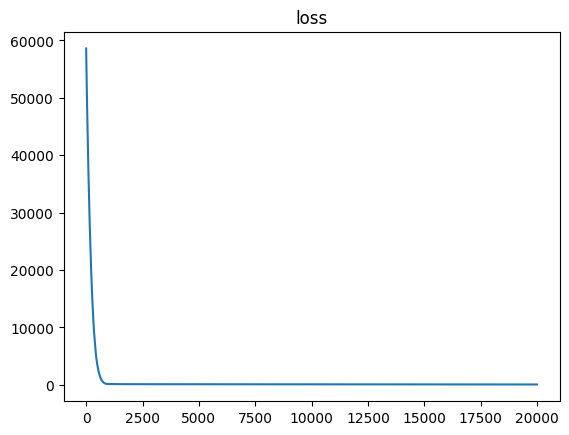

final loss 50.684128231147774


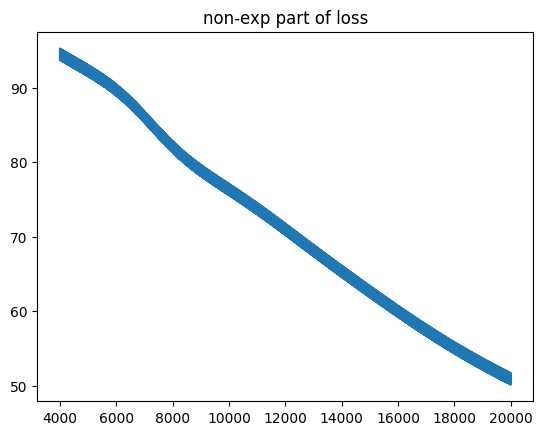

Function custom_tucker time:  0:03:05.789106
score: 50.68412823114779

iter43, params: (20000, 0.0005, (0.9, 0.6), 1e-09, 0)
iter 2000 loss 92.79281146239137
iter 4000 loss 51.49459969067478
iter 6000 loss 27.690045780751994
iter 8000 loss 11.848364378479518
iter 10000 loss 3.6901620880002475
iter 12000 loss 0.8471586377098131


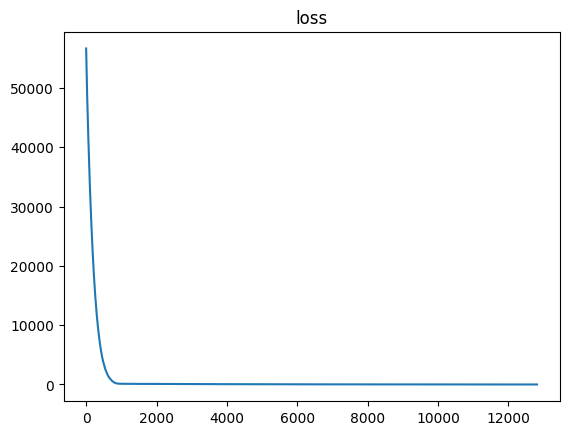

final loss 0.49914470233340574


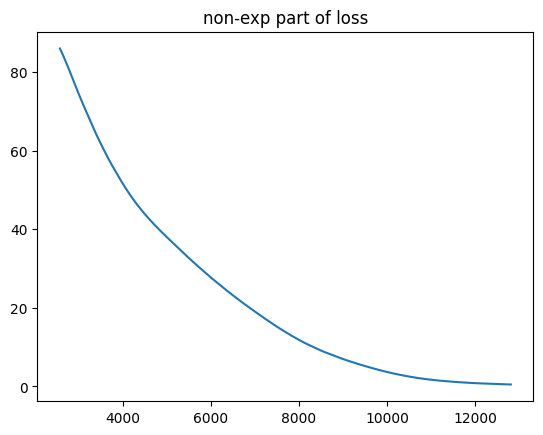

Function custom_tucker time:  0:01:58.631998
score: 0.49933551941852133

iter44, params: (20000, 0.0005, (0.9, 0.9), 1e-09, 0)
iter 2000 loss 42.981903825473
iter 4000 loss 15.881723938538324
iter 6000 loss 6.74115472965614
iter 8000 loss 2.1356797317107827
iter 10000 loss 0.7635219542413556


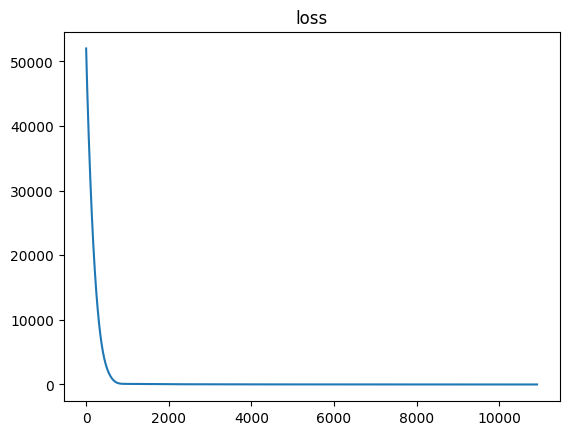

final loss 0.49999141343650844


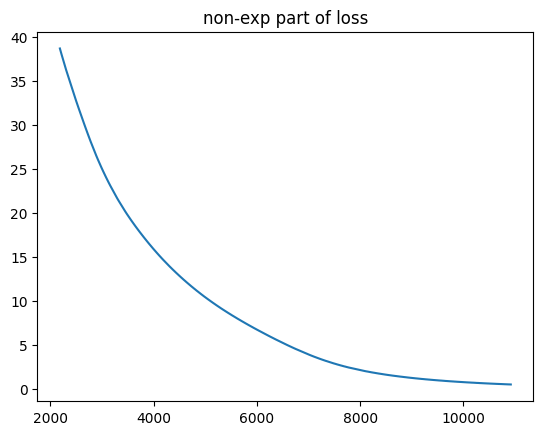

Function custom_tucker time:  0:01:40.983637
score: 0.4995938001903892

iter45, params: (20000, 0.0001, (0.3, 0.3), 1e-09, 0)
iter 2000 loss 10435.672813618798
iter 4000 loss 570.257760860066
iter 6000 loss 89.67460370819104
iter 8000 loss 72.45651783115075
iter 10000 loss 56.73228619088381
iter 12000 loss 46.83465947904824
iter 14000 loss 39.3746874653397
iter 16000 loss 33.83208133646279
iter 18000 loss 29.593080108611893
iter 20000 loss 26.37264640537725


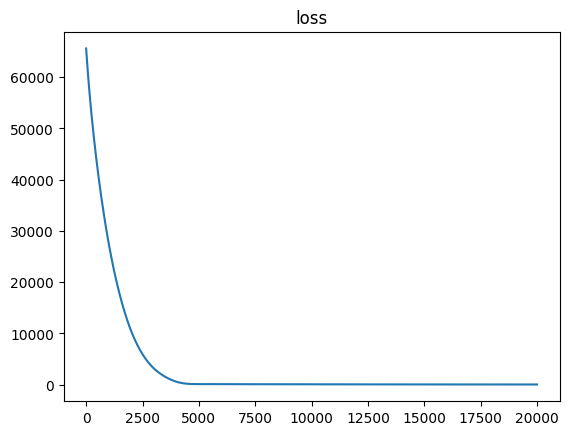

final loss 26.370545804581052


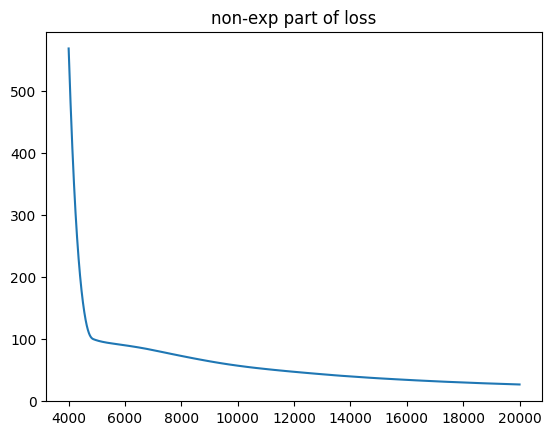

Function custom_tucker time:  0:03:02.988929
score: 26.370545804581056

iter46, params: (20000, 0.0001, (0.3, 0.6), 1e-09, 0)
iter 2000 loss 7636.425356270627
iter 4000 loss 340.6819247968161
iter 6000 loss 88.23543075633366
iter 8000 loss 73.33807731899506
iter 10000 loss 54.18714135328507
iter 12000 loss 43.44635522873757
iter 14000 loss 37.318385190054954
iter 16000 loss 32.910828639669326
iter 18000 loss 29.52648557614201
iter 20000 loss 26.81761751929032


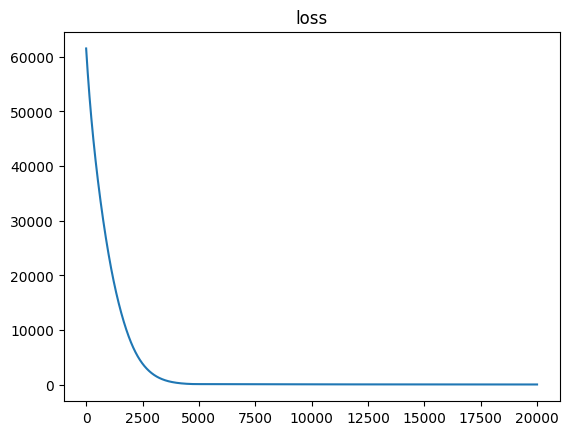

final loss 26.81663274237729


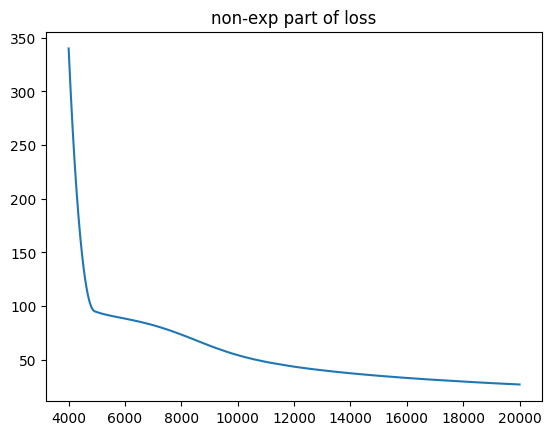

Function custom_tucker time:  0:03:02.931171
score: 26.8166327423773

iter47, params: (20000, 0.0001, (0.3, 0.9), 1e-09, 0)
iter 2000 loss 7657.0393079179685
iter 4000 loss 181.47876253909357
iter 6000 loss 86.80195863808058
iter 8000 loss 72.32837398651435
iter 10000 loss 58.26019180760298
iter 12000 loss 47.82107264794688
iter 14000 loss 40.602051633267905
iter 16000 loss 35.66871258935675
iter 18000 loss 31.82523375055603
iter 20000 loss 28.20458033046788


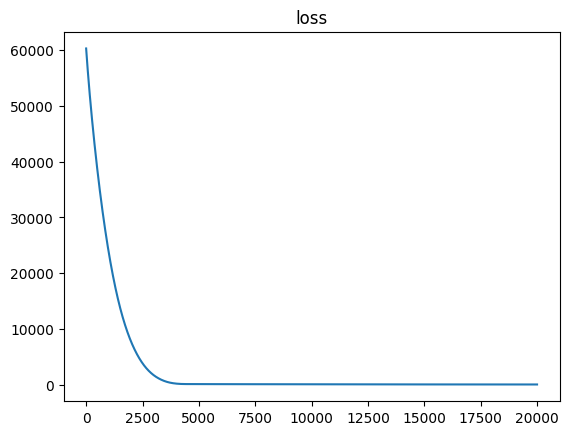

final loss 28.197942276080436


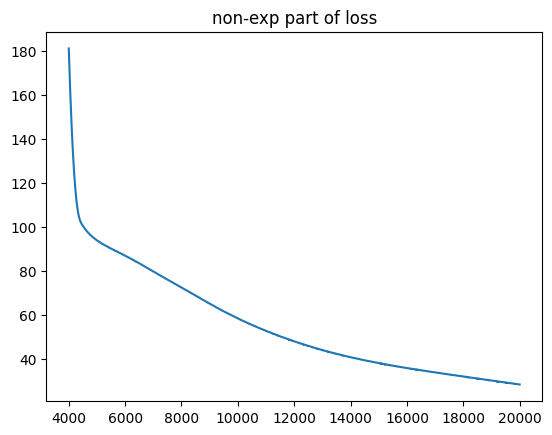

Function custom_tucker time:  0:03:04.747407
score: 28.19794227608044

iter48, params: (20000, 0.0001, (0.6, 0.3), 1e-09, 0)
iter 2000 loss 8672.243205388755
iter 4000 loss 611.8903216353693
iter 6000 loss 88.69988709659414
iter 8000 loss 70.80997507801818
iter 10000 loss 54.8296607786452
iter 12000 loss 45.77754797919545
iter 14000 loss 40.13205946046282
iter 16000 loss 35.81713153151648
iter 18000 loss 32.376747873270574
iter 20000 loss 29.716052169988746


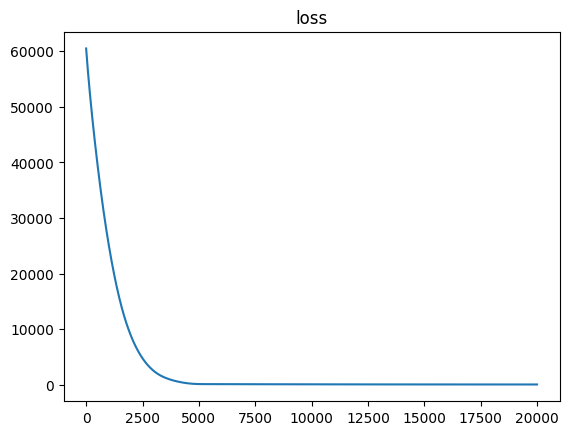

final loss 29.700662828018704


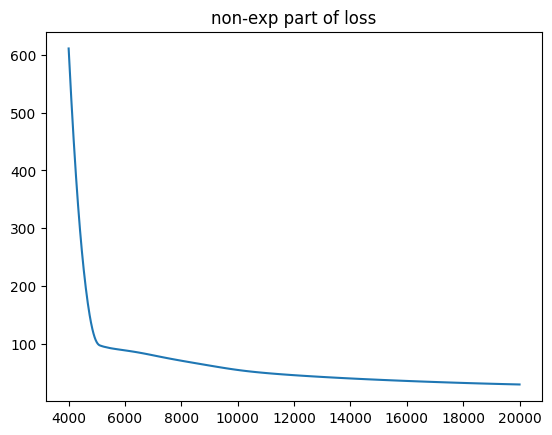

Function custom_tucker time:  0:03:20.358829
score: 29.7006628280187

iter49, params: (20000, 0.0001, (0.6, 0.6), 1e-09, 0)
iter 2000 loss 5432.205913155302
iter 4000 loss 133.05721991679192
iter 6000 loss 76.99515264174507
iter 8000 loss 55.8286515516332
iter 10000 loss 40.19277512668312
iter 12000 loss 29.914344326718304
iter 14000 loss 23.174936863704012
iter 16000 loss 18.87721280576399
iter 18000 loss 15.620881967313077
iter 20000 loss 12.890959348005842


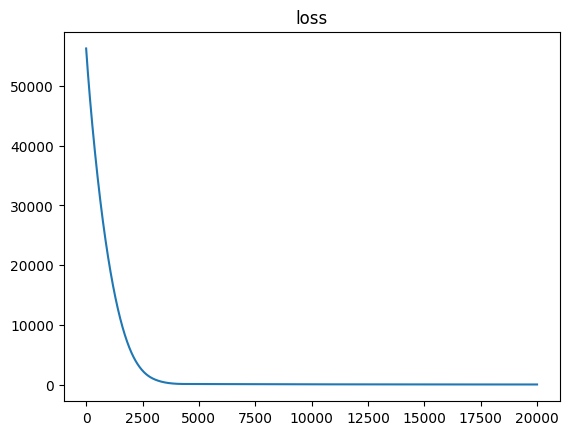

final loss 12.89037358924227


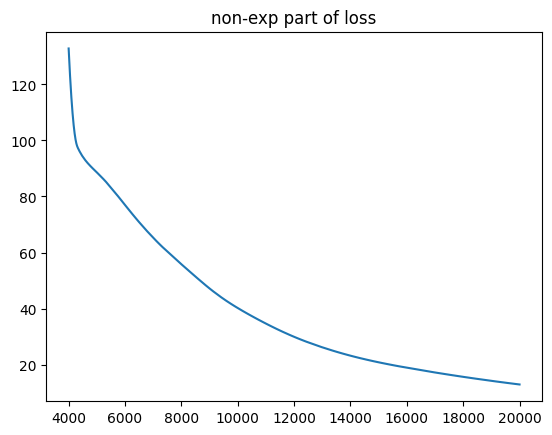

Function custom_tucker time:  0:03:07.652281
score: 12.89037358924228

iter50, params: (20000, 0.0001, (0.6, 0.9), 1e-09, 0)
iter 2000 loss 7802.217132169019
iter 4000 loss 298.2545789444201
iter 6000 loss 80.43531894054554
iter 8000 loss 61.78309239998607
iter 10000 loss 48.93942728607718
iter 12000 loss 39.06095436643755
iter 14000 loss 32.27278927311431
iter 16000 loss 25.91435493519311
iter 18000 loss 20.478199506791757
iter 20000 loss 16.631054433378843


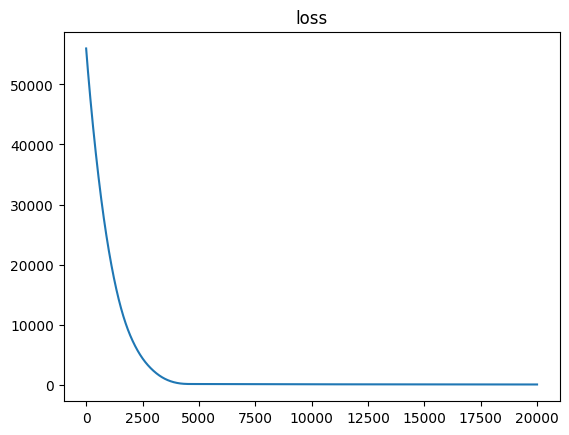

final loss 16.629206841533804


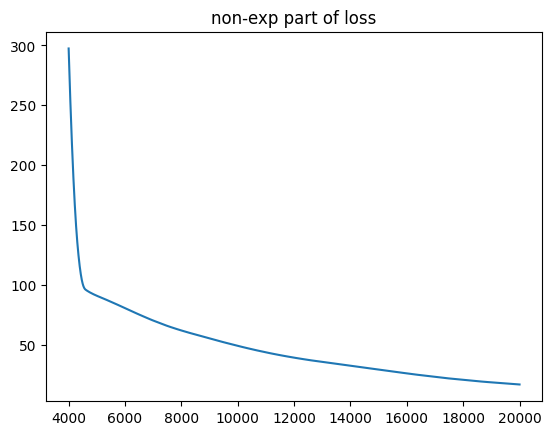

Function custom_tucker time:  0:03:04.158885
score: 16.6292068415338

iter51, params: (20000, 0.0001, (0.9, 0.3), 1e-09, 0)
iter 2000 loss 4507.786311647146
iter 4000 loss 128.22969418763373
iter 6000 loss 99.8494377582163
iter 8000 loss 93.80962520705295
iter 10000 loss 90.75869388447147
iter 12000 loss 87.35803151558493
iter 14000 loss 82.19860007633491
iter 16000 loss 76.1861928223608
iter 18000 loss 70.49364852894286
iter 20000 loss 65.8055274871813


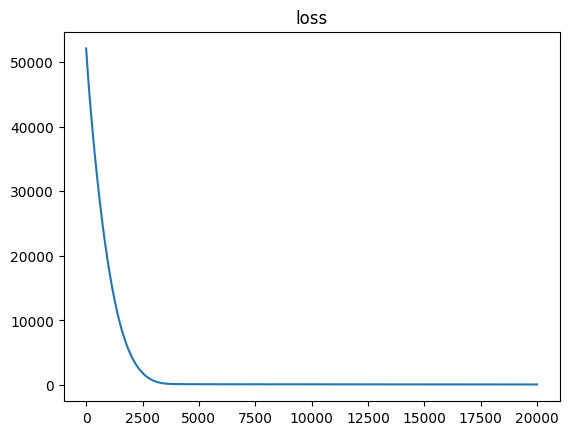

final loss 65.85322901299304


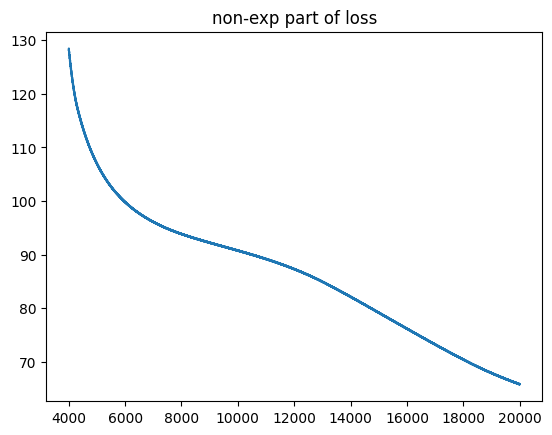

Function custom_tucker time:  0:03:05.896021
score: 65.85322901299308

iter52, params: (20000, 0.0001, (0.9, 0.6), 1e-09, 0)
iter 2000 loss 8369.310298981149
iter 4000 loss 186.48000592006895
iter 6000 loss 97.05301011412234
iter 8000 loss 89.94145908665315
iter 10000 loss 82.32178361905466
iter 12000 loss 71.9734814739899
iter 14000 loss 62.952995905377335
iter 16000 loss 53.97980946493729
iter 18000 loss 46.08253655835315
iter 20000 loss 39.973503889888725


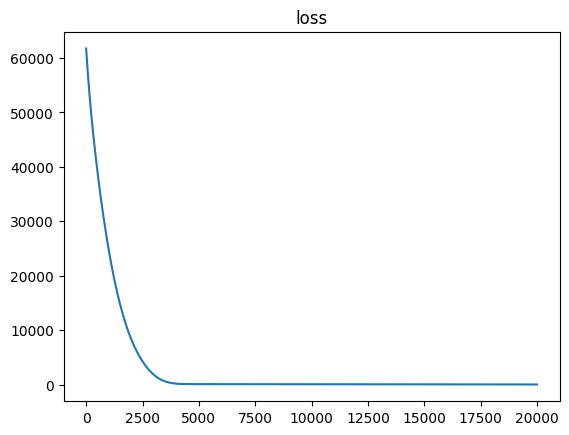

final loss 39.96985036370523


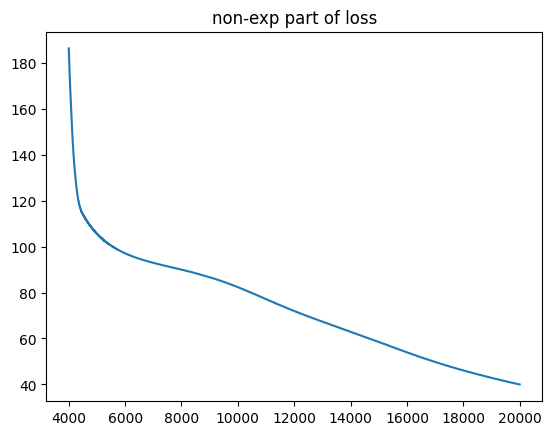

Function custom_tucker time:  0:03:04.204503
score: 39.96985036370524

iter53, params: (20000, 0.0001, (0.9, 0.9), 1e-09, 0)
iter 2000 loss 8154.677503931121
iter 4000 loss 642.2904679091431
iter 6000 loss 79.87238075905847
iter 8000 loss 48.29095716916136
iter 10000 loss 29.682041181276926
iter 12000 loss 18.47343665069548
iter 14000 loss 11.360937555261577
iter 16000 loss 6.4859852578892525
iter 18000 loss 3.408677869884655
iter 20000 loss 1.7704208605997778


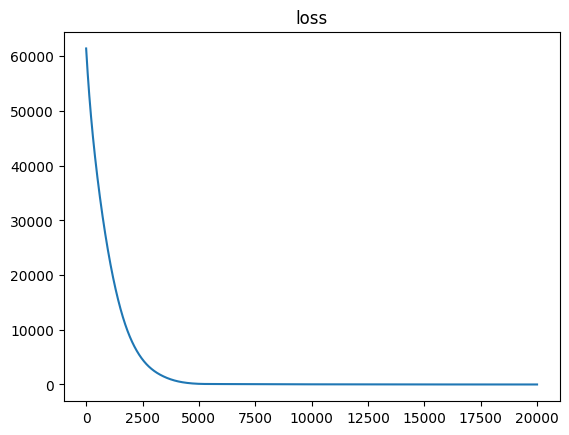

final loss 1.769942091302281


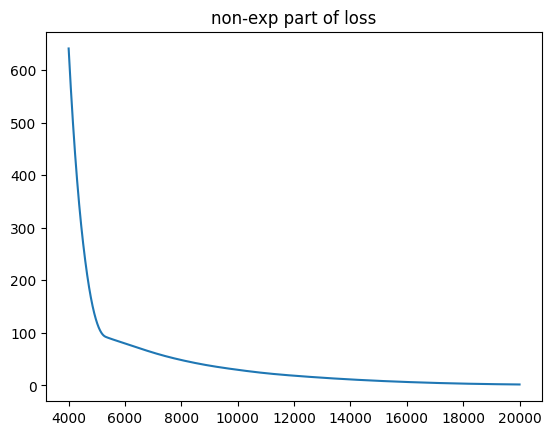

Function custom_tucker time:  0:03:01.940026
score: 1.769942091302282

iter54, params: (30000, 0.001, (0.3, 0.3), 1e-09, 0)
iter 3000 loss 85.6881609446633
iter 6000 loss 59.012439047903975
iter 9000 loss 44.55215677179725
iter 12000 loss 39.23357584757323
iter 15000 loss 32.82180741146237
iter 18000 loss 29.493065750673104
iter 21000 loss 24.280697565946856
iter 24000 loss 20.14204803069693
iter 27000 loss 17.985770289150597
iter 30000 loss 13.605014324073332


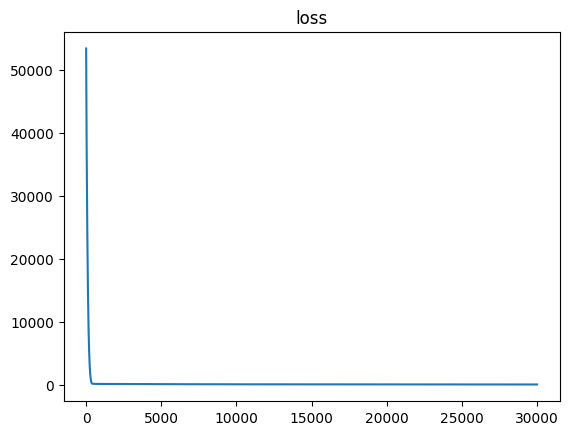

final loss 14.079564420392945


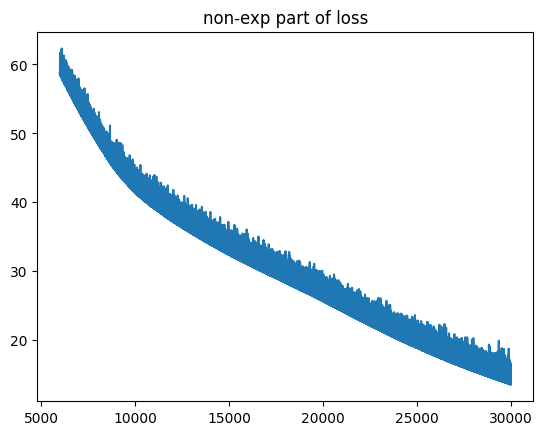

Function custom_tucker time:  0:04:32.634425
score: 14.079564420392941

iter55, params: (30000, 0.001, (0.3, 0.6), 1e-09, 0)
iter 3000 loss 83.13615913994191
iter 6000 loss 59.40153645200504
iter 9000 loss 45.426366008163356
iter 12000 loss 38.6658896517536
iter 15000 loss 33.24092919597246
iter 18000 loss 29.041108805643056
iter 21000 loss 26.57389170037752
iter 24000 loss 22.30488811920782
iter 27000 loss 18.997494784177647
iter 30000 loss 15.788772141256814


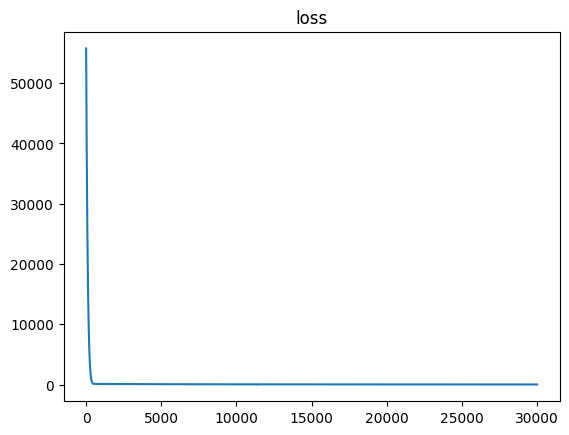

final loss 15.849939172046538


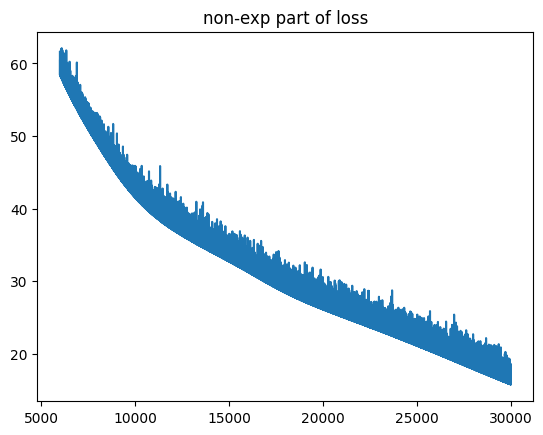

Function custom_tucker time:  0:04:38.333647
score: 15.849939172046533

iter56, params: (30000, 0.001, (0.3, 0.9), 1e-09, 0)
iter 3000 loss 88.74142974907585
iter 6000 loss 66.2960948310218
iter 9000 loss 53.40012601445183
iter 12000 loss 44.28012972830155
iter 15000 loss 37.101637620334635
iter 18000 loss 30.68704108878012
iter 21000 loss 25.130226384721816
iter 24000 loss 20.62034128278571
iter 27000 loss 17.267173094638235
iter 30000 loss 14.359948100225873


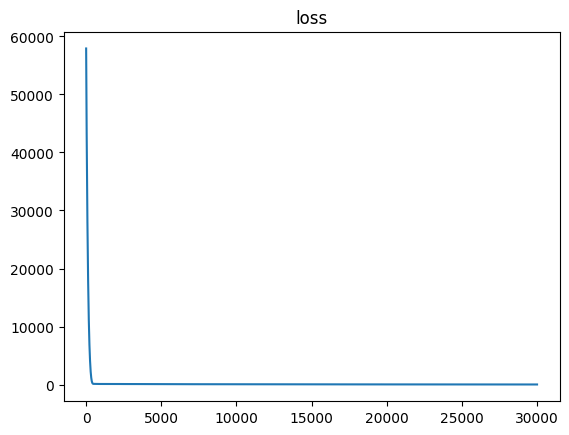

final loss 14.413853384857985


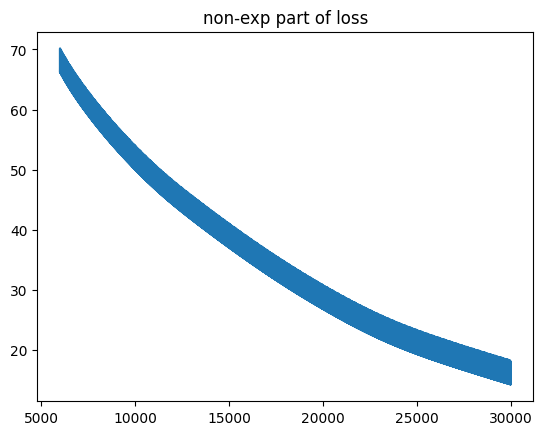

Function custom_tucker time:  0:04:38.320563
score: 14.413853384857994

iter57, params: (30000, 0.001, (0.6, 0.3), 1e-09, 0)
iter 3000 loss 69.12121561690388
iter 6000 loss 47.99343205786931
iter 9000 loss 36.759996600133334
iter 12000 loss 28.051488720547315
iter 15000 loss 20.32303038107787
iter 18000 loss 15.491443653018381
iter 21000 loss 12.048856592680306
iter 24000 loss 9.333534824535674
iter 27000 loss 7.258414575831083
iter 30000 loss 5.646580119850928


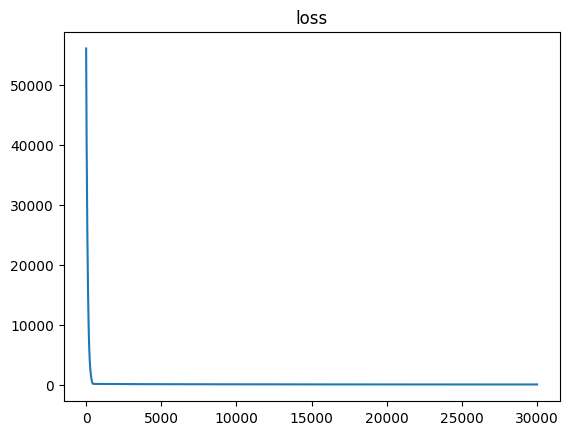

final loss 5.996948539227828


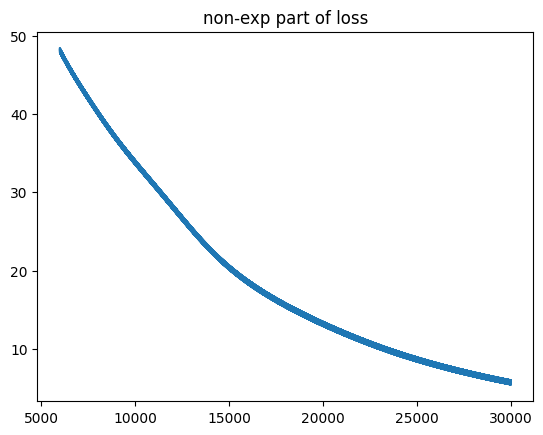

Function custom_tucker time:  0:04:35.268444
score: 5.996948539227828

iter58, params: (30000, 0.001, (0.6, 0.6), 1e-09, 0)
iter 3000 loss 59.04342019505483
iter 6000 loss 39.016053404485476
iter 9000 loss 27.690879392388574
iter 12000 loss 21.593425358894223
iter 15000 loss 17.250154017829594
iter 18000 loss 13.777721246075357
iter 21000 loss 11.182297114948039
iter 24000 loss 8.16372840782836
iter 27000 loss 5.491729505954297
iter 30000 loss 3.932733507433651


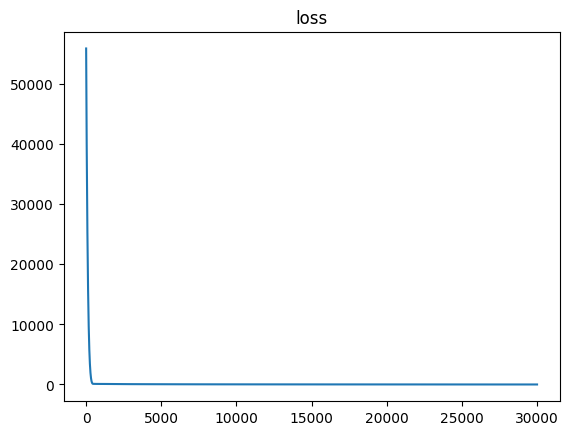

final loss 4.202162748097837


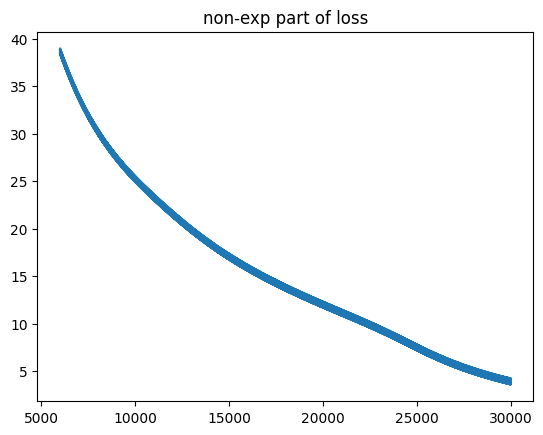

Function custom_tucker time:  0:04:49.785122
score: 4.202162748097835

iter59, params: (30000, 0.001, (0.6, 0.9), 1e-09, 0)
iter 3000 loss 54.86844201391405
iter 6000 loss 34.16574177635496
iter 9000 loss 25.449284090858132
iter 12000 loss 19.56979626014417
iter 15000 loss 15.798737590073431
iter 18000 loss 11.717151008947322
iter 21000 loss 8.68072902713606
iter 24000 loss 6.35578376371165
iter 27000 loss 4.81612414787837
iter 30000 loss 3.3663986409728235


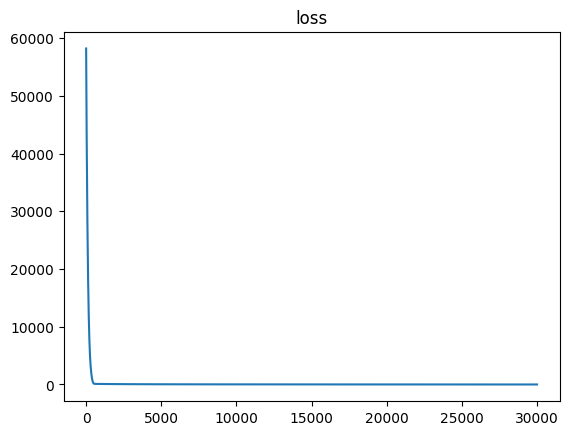

final loss 3.3701201517458315


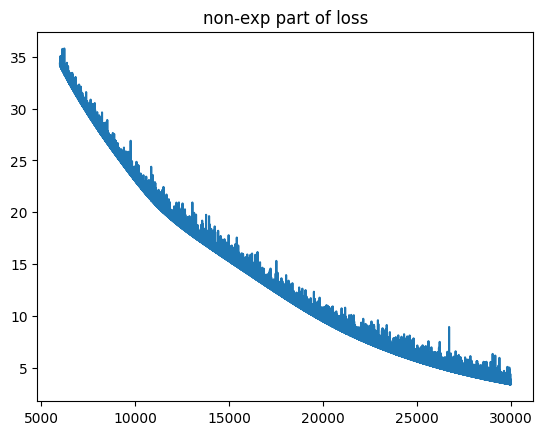

Function custom_tucker time:  0:04:34.798361
score: 3.3701201517458315

iter60, params: (30000, 0.001, (0.9, 0.3), 1e-09, 0)
iter 3000 loss 96.42652496136601
iter 6000 loss 94.78331802849134
iter 9000 loss 92.20500053674637
iter 12000 loss 83.46494734649522
iter 15000 loss 72.57159823231947
iter 18000 loss 61.953265165752214
iter 21000 loss 51.9400031717389
iter 24000 loss 51.31362671296702
iter 27000 loss 46.84495781907788
iter 30000 loss 38.80229774563715


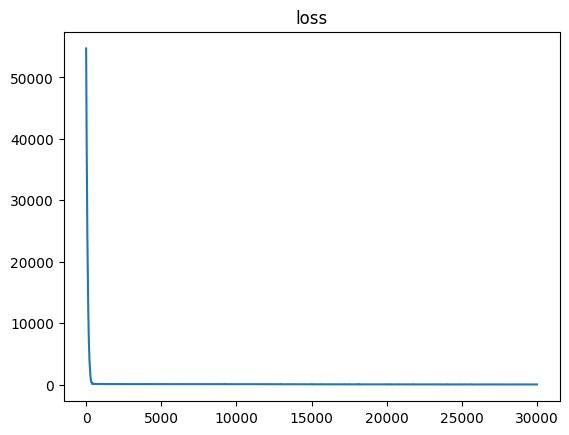

final loss 43.13080969893389


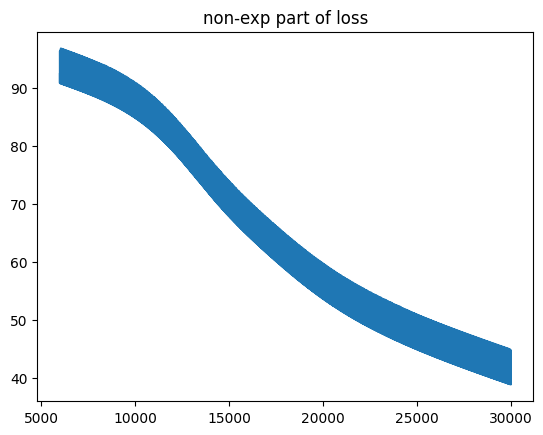

Function custom_tucker time:  0:04:33.565982
score: 43.1308096989339

iter61, params: (30000, 0.001, (0.9, 0.6), 1e-09, 0)
iter 3000 loss 35.309239748109015
iter 6000 loss 8.611070895934775
iter 9000 loss 2.2126847028960235
iter 12000 loss 1.0965147888551114


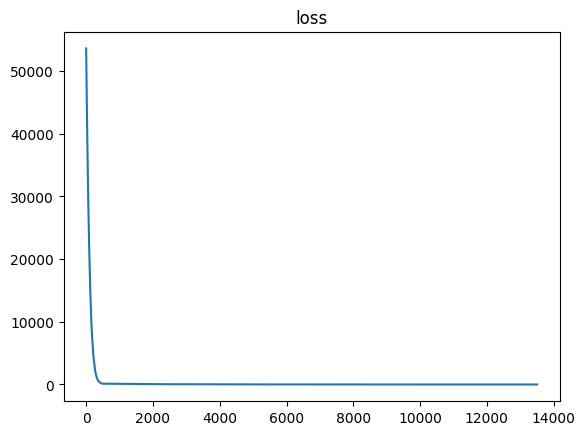

final loss 0.49945495861635403


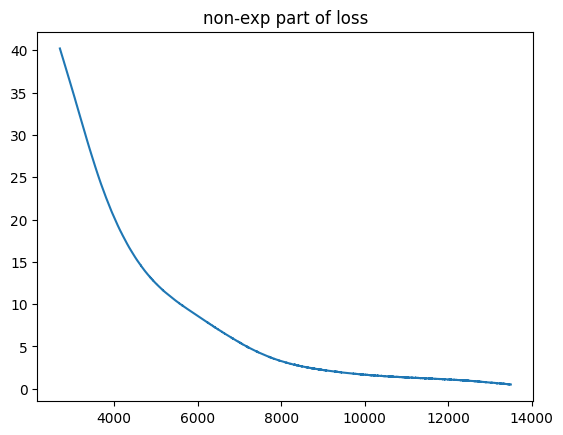

Function custom_tucker time:  0:02:06.735117
score: 0.5010732073633144

iter62, params: (30000, 0.001, (0.9, 0.9), 1e-09, 0)
iter 3000 loss 20.775604848152547
iter 6000 loss 4.1674681551649915
iter 9000 loss 0.7442707788634223


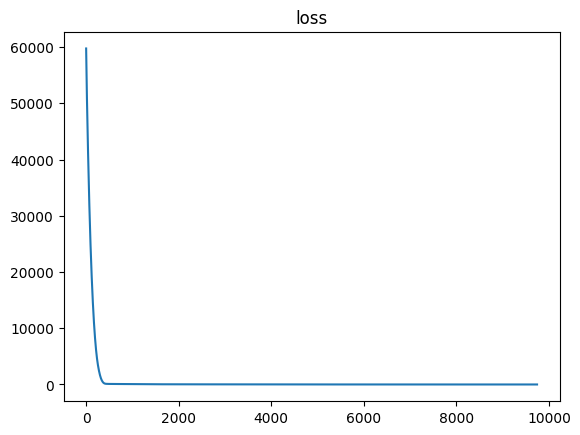

final loss 0.4983001034468876


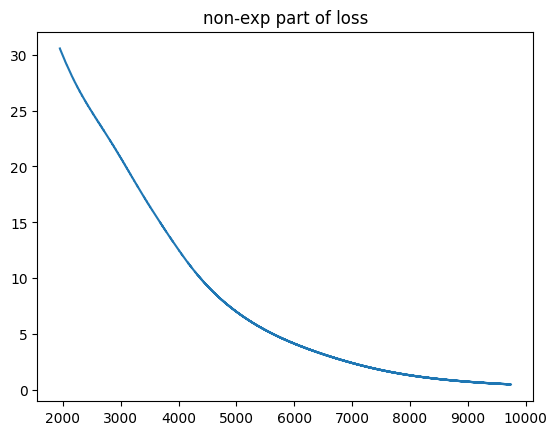

Function custom_tucker time:  0:01:30.236397
score: 0.5085472914663709

iter63, params: (30000, 0.0005, (0.3, 0.3), 1e-09, 0)
iter 3000 loss 78.35953952927679
iter 6000 loss 54.36682231013044
iter 9000 loss 41.332755203939534
iter 12000 loss 32.86017099829491
iter 15000 loss 27.171987531949082
iter 18000 loss 24.35791257202843
iter 21000 loss 20.841087242479368
iter 24000 loss 18.73779088331717
iter 27000 loss 16.83003028278712
iter 30000 loss 15.232941942278174


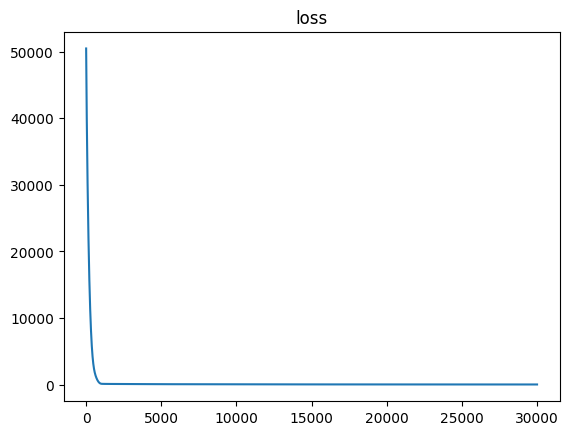

final loss 15.70005022012985


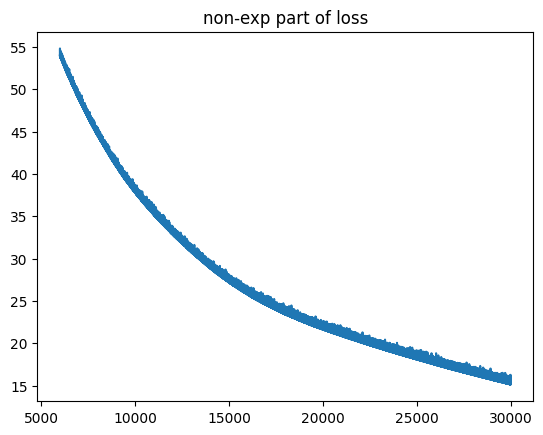

Function custom_tucker time:  0:04:37.561413
score: 15.700050220129842

iter64, params: (30000, 0.0005, (0.3, 0.6), 1e-09, 0)
iter 3000 loss 83.37556035659948
iter 6000 loss 59.040432339561136
iter 9000 loss 47.761695375190804
iter 12000 loss 40.902294534410146
iter 15000 loss 36.2009572037454
iter 18000 loss 31.77380721686808
iter 21000 loss 27.121365415785313
iter 24000 loss 22.54866886678412
iter 27000 loss 18.856626531886857
iter 30000 loss 16.378661082483877


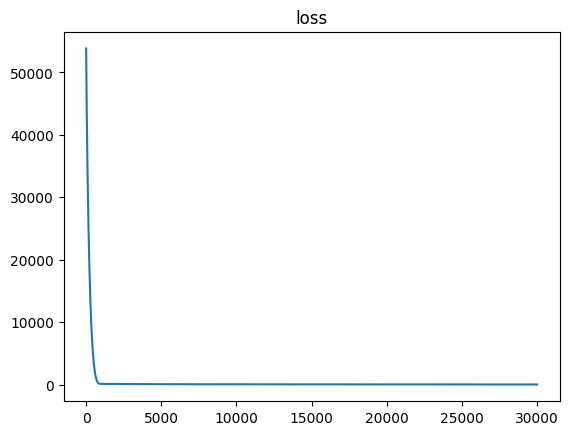

final loss 16.298446497829605


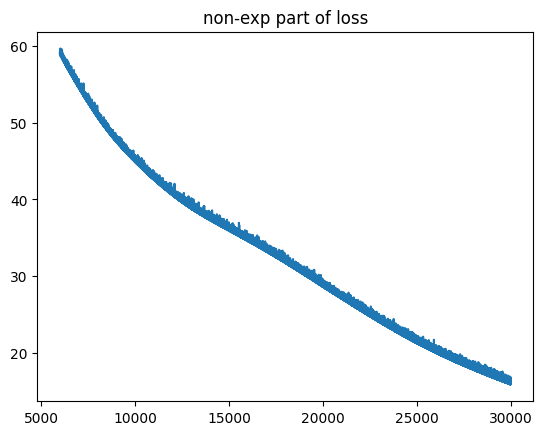

Function custom_tucker time:  0:04:35.080019
score: 16.298446497829605

iter65, params: (30000, 0.0005, (0.3, 0.9), 1e-09, 0)
iter 3000 loss 89.18873982790397
iter 6000 loss 67.95452673956666
iter 9000 loss 53.88455362126346
iter 12000 loss 44.35758227095007
iter 15000 loss 38.78096732201899
iter 18000 loss 31.9661613244807
iter 21000 loss 26.498880203614533
iter 24000 loss 23.024278710740337
iter 27000 loss 20.424089445856275
iter 30000 loss 17.984271898086355


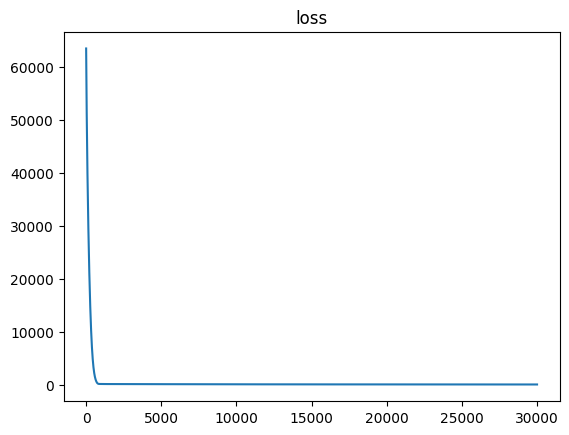

final loss 17.988717600977047


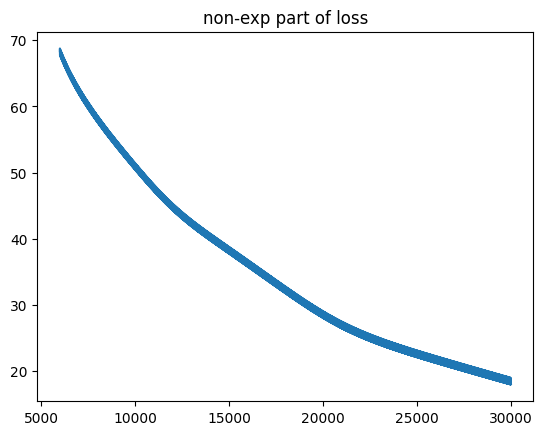

Function custom_tucker time:  0:04:36.068531
score: 17.988717600977058

iter66, params: (30000, 0.0005, (0.6, 0.3), 1e-09, 0)
iter 3000 loss 71.69079108347518
iter 6000 loss 47.21408545726251
iter 9000 loss 35.17782339889338
iter 12000 loss 28.58736860282483
iter 15000 loss 23.417559050577445
iter 18000 loss 19.252980918961562
iter 21000 loss 16.250361845507435
iter 24000 loss 13.911688275938117
iter 27000 loss 11.995077488020874
iter 30000 loss 10.244372075078342


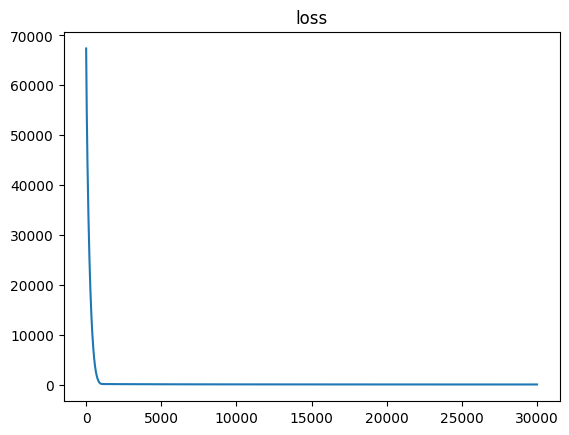

final loss 10.295937067307605


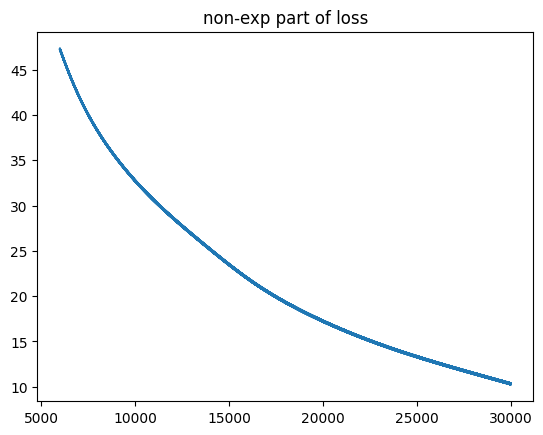

Function custom_tucker time:  0:04:37.693159
score: 10.295937067307603

iter67, params: (30000, 0.0005, (0.6, 0.6), 1e-09, 0)
iter 3000 loss 60.42041684598559
iter 6000 loss 36.295314322996425
iter 9000 loss 27.662299429999273
iter 12000 loss 22.380055175824566
iter 15000 loss 16.972641908646004
iter 18000 loss 11.77093450901704
iter 21000 loss 8.759355585726126
iter 24000 loss 6.536822625597617
iter 27000 loss 4.967536602073688
iter 30000 loss 3.862096664320502


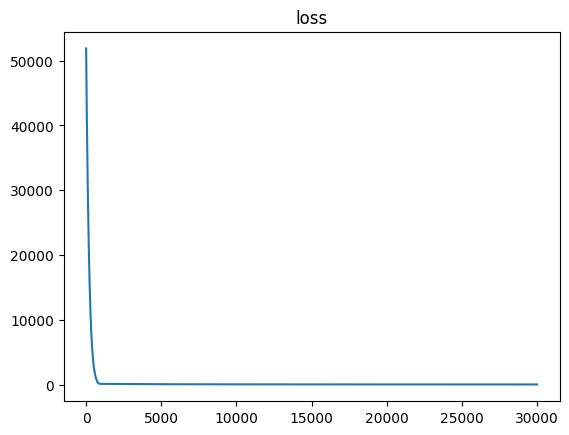

final loss 3.8568118245640894


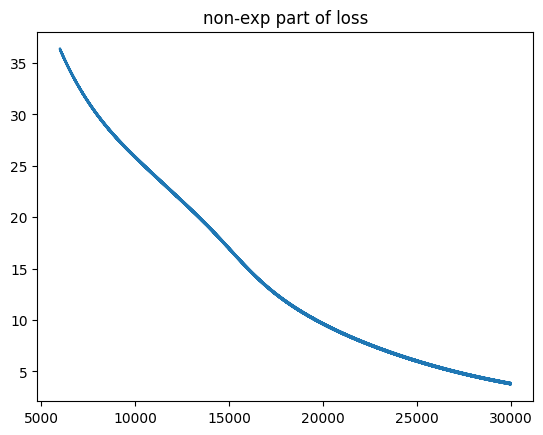

Function custom_tucker time:  0:04:37.904400
score: 3.8568118245640886

iter68, params: (30000, 0.0005, (0.6, 0.9), 1e-09, 0)
iter 3000 loss 67.37752483140866
iter 6000 loss 39.032693878394475
iter 9000 loss 28.52837295991984
iter 12000 loss 21.159940329849523
iter 15000 loss 16.052241362280466
iter 18000 loss 11.843413181660567
iter 21000 loss 8.690868767644876
iter 24000 loss 6.6842702351131305
iter 27000 loss 4.83472735032283
iter 30000 loss 3.4096620940937292


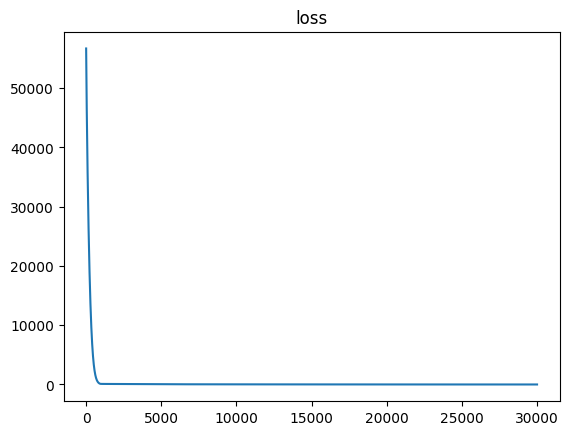

final loss 3.416683902422911


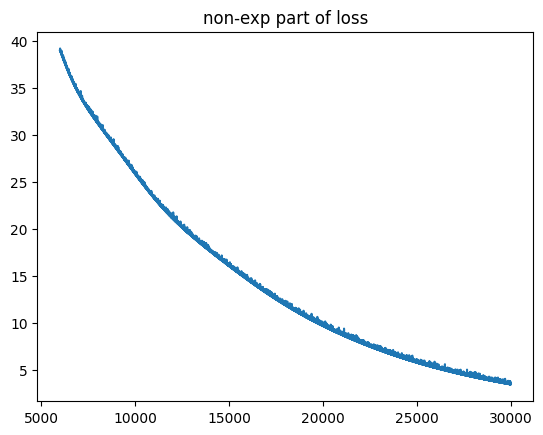

Function custom_tucker time:  0:04:34.213565
score: 3.4166839024229088

iter69, params: (30000, 0.0005, (0.9, 0.3), 1e-09, 0)
iter 3000 loss 96.55817764227356
iter 6000 loss 90.83203619526672
iter 9000 loss 82.37555493646246
iter 12000 loss 70.83600033574703
iter 15000 loss 62.20261040127095
iter 18000 loss 53.704767594759524
iter 21000 loss 47.890406800917326
iter 24000 loss 44.555827798232855
iter 27000 loss 39.163696461746284
iter 30000 loss 35.8608070053938


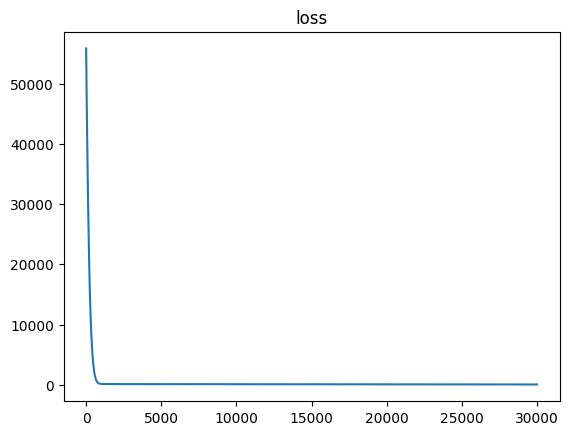

final loss 36.75184150121541


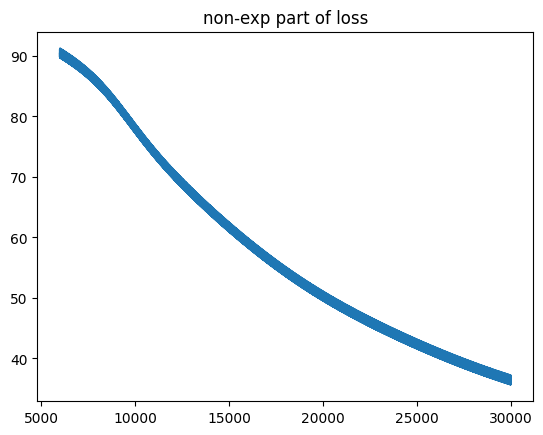

Function custom_tucker time:  0:04:36.895599
score: 36.75184150121542

iter70, params: (30000, 0.0005, (0.9, 0.6), 1e-09, 0)
iter 3000 loss 73.68324124042987
iter 6000 loss 26.711036649902166
iter 9000 loss 5.697290535904643
iter 12000 loss 0.6484574935247521


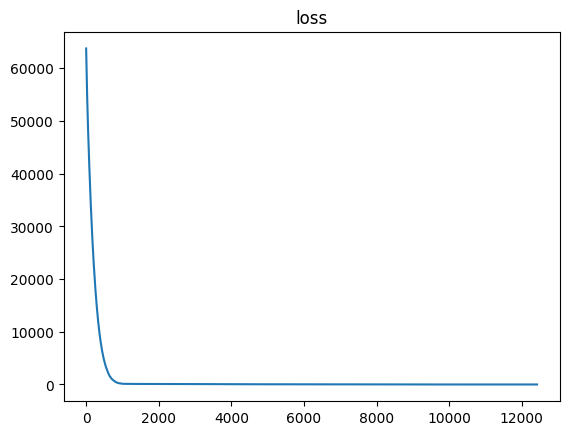

final loss 0.49994248756937093


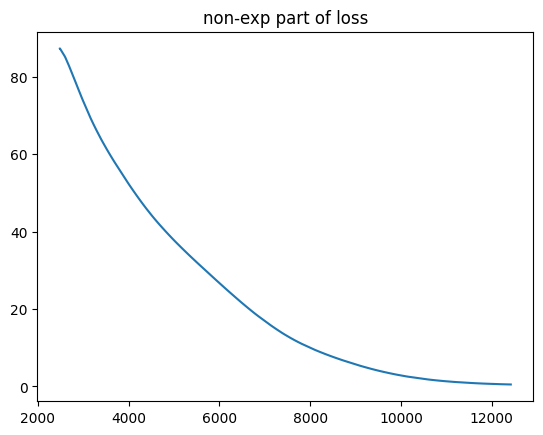

Function custom_tucker time:  0:01:55.599480
score: 0.4990166851572094

iter71, params: (30000, 0.0005, (0.9, 0.9), 1e-09, 0)
iter 3000 loss 28.00045006351153
iter 6000 loss 8.413042240249453
iter 9000 loss 2.1016682638865256
iter 12000 loss 0.7173977293043697


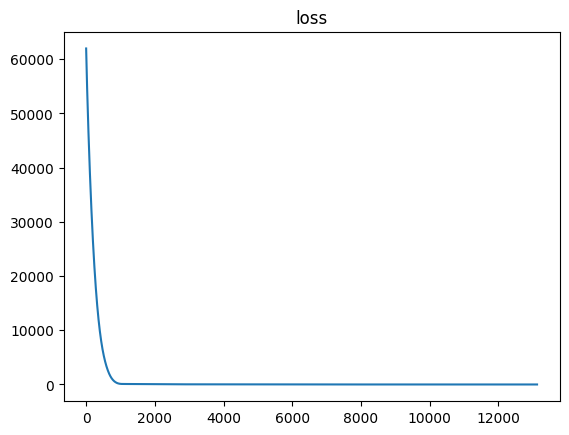

final loss 0.499242475041986


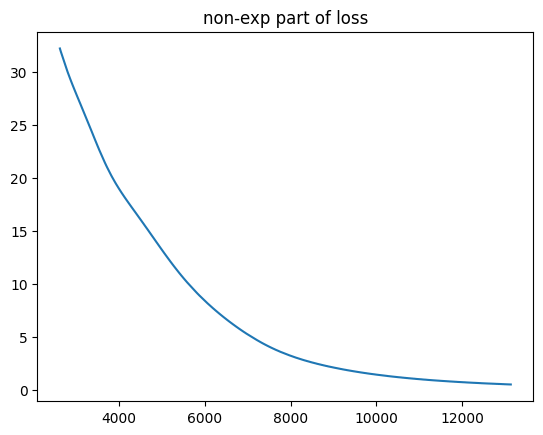

Function custom_tucker time:  0:02:00.395621
score: 0.5014149290791953

iter72, params: (30000, 0.0001, (0.3, 0.3), 1e-09, 0)
iter 3000 loss 1309.1702031003067
iter 6000 loss 85.6388831280887
iter 9000 loss 60.85837929052555
iter 12000 loss 43.97661395296618
iter 15000 loss 35.47059886824034
iter 18000 loss 29.55313180279097
iter 21000 loss 24.301868630155056
iter 24000 loss 20.010116323862768
iter 27000 loss 17.13005553298979
iter 30000 loss 14.831326799397615


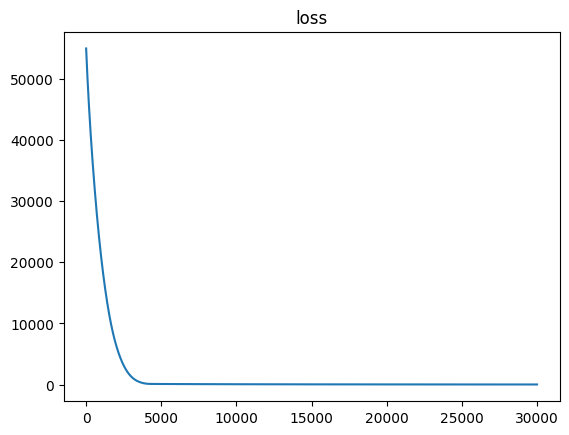

final loss 14.839688556481727


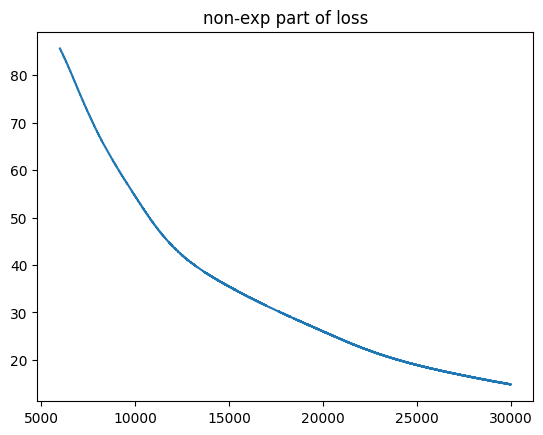

Function custom_tucker time:  0:04:44.763064
score: 14.839688556481722

iter73, params: (30000, 0.0001, (0.3, 0.6), 1e-09, 0)
iter 3000 loss 2520.4750869867844
iter 6000 loss 87.26811049998771
iter 9000 loss 66.2097349512893
iter 12000 loss 50.218889722043194
iter 15000 loss 40.5594607822256
iter 18000 loss 34.36755180432939
iter 21000 loss 30.687772752124033
iter 24000 loss 27.385669854162828
iter 27000 loss 24.107363086542676
iter 30000 loss 20.810266459805714


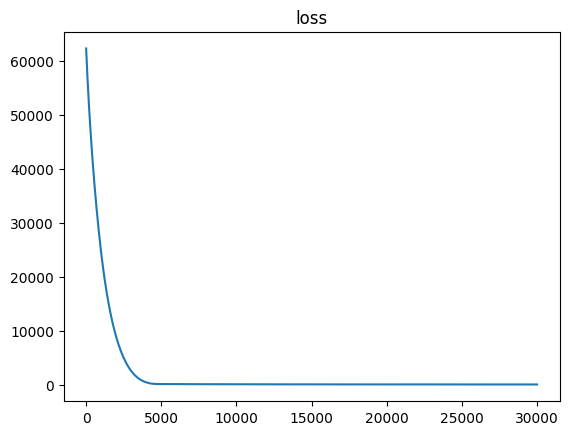

final loss 20.810552329102066


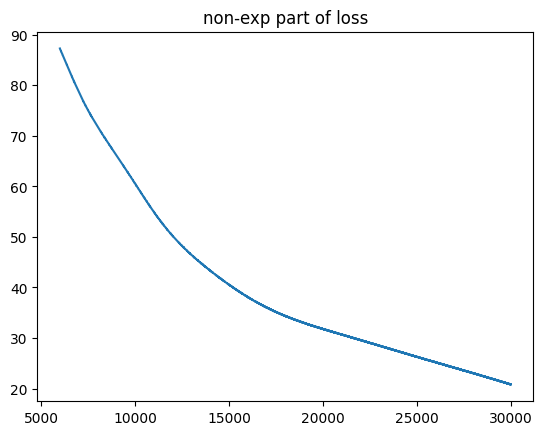

Function custom_tucker time:  0:04:53.429195
score: 20.810552329102073

iter74, params: (30000, 0.0001, (0.3, 0.9), 1e-09, 0)
iter 3000 loss 2252.5148567229667
iter 6000 loss 90.92486096471127
iter 9000 loss 71.78875381382717
iter 12000 loss 52.777435697140746
iter 15000 loss 42.11286095418788
iter 18000 loss 34.765130039198496
iter 21000 loss 29.506611425257056
iter 24000 loss 24.770395560926804
iter 27000 loss 21.13912161365218
iter 30000 loss 18.193293671638703


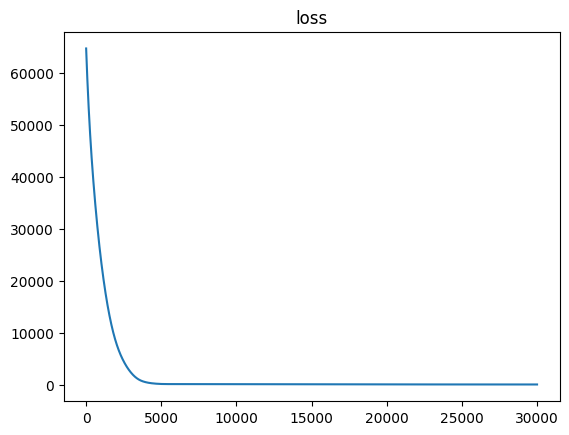

final loss 18.19544784724226


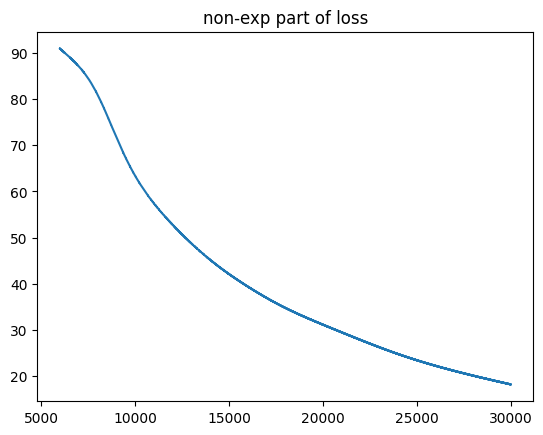

Function custom_tucker time:  0:04:36.180542
score: 18.195447847242264

iter75, params: (30000, 0.0001, (0.6, 0.3), 1e-09, 0)
iter 3000 loss 893.411576802251
iter 6000 loss 82.70067685807894
iter 9000 loss 57.00392204999438
iter 12000 loss 41.0795608734754
iter 15000 loss 34.23166761133067
iter 18000 loss 29.909392187471344
iter 21000 loss 26.136368626832635
iter 24000 loss 22.436720030947775
iter 27000 loss 18.873895511405877
iter 30000 loss 16.324933366217554


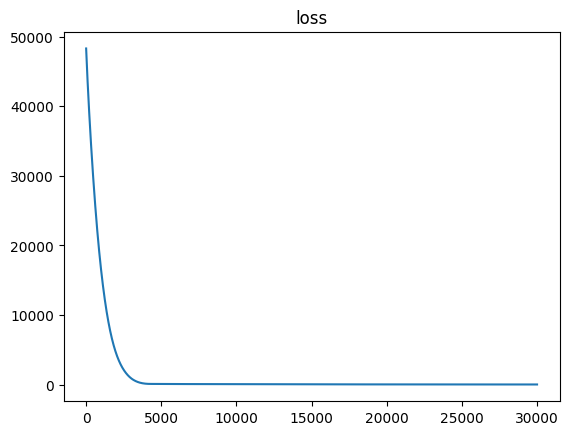

final loss 16.33794914217114


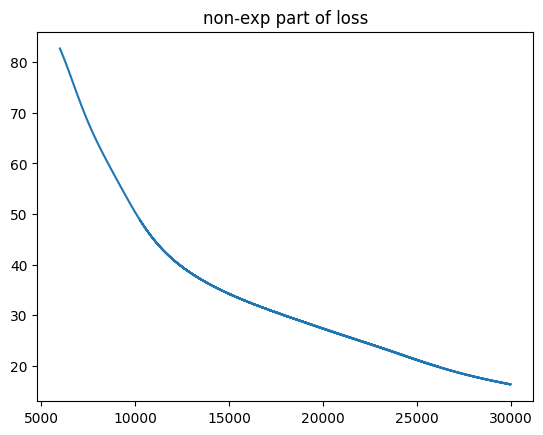

Function custom_tucker time:  0:04:37.109832
score: 16.33794914217113

iter76, params: (30000, 0.0001, (0.6, 0.6), 1e-09, 0)
iter 3000 loss 2618.082286468764
iter 6000 loss 74.5418512142195
iter 9000 loss 41.939294213178236
iter 12000 loss 29.131644198327518
iter 15000 loss 19.901654131225833
iter 18000 loss 14.665675746587453
iter 21000 loss 10.282655121658461
iter 24000 loss 7.1980840026724335
iter 27000 loss 5.023200943150381
iter 30000 loss 3.413369303184602


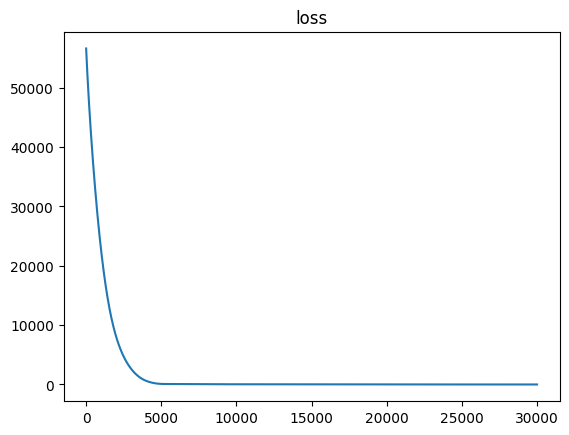

final loss 3.410509779313645


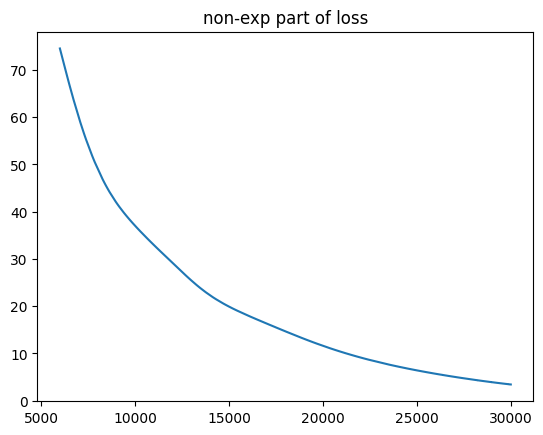

Function custom_tucker time:  0:04:35.270752
score: 3.4105097793136463

iter77, params: (30000, 0.0001, (0.6, 0.9), 1e-09, 0)
iter 3000 loss 664.8043635304695
iter 6000 loss 75.55969563144686
iter 9000 loss 45.501195597347824
iter 12000 loss 30.133835452310144
iter 15000 loss 23.024764266583677
iter 18000 loss 17.807616421899457
iter 21000 loss 13.701573151796522
iter 24000 loss 9.905262289531908
iter 27000 loss 6.971727913984314
iter 30000 loss 5.019266734851815


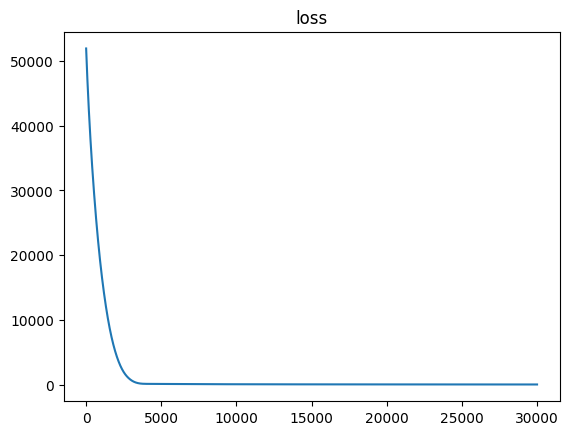

final loss 5.018966927161907


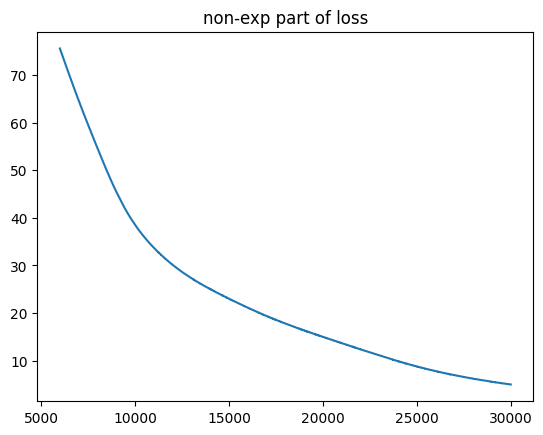

Function custom_tucker time:  0:04:38.774214
score: 5.018966927161908

iter78, params: (30000, 0.0001, (0.9, 0.3), 1e-09, 0)
iter 3000 loss 3065.840788327446
iter 6000 loss 105.4723200015267
iter 9000 loss 90.28011244778733
iter 12000 loss 79.10890773939039
iter 15000 loss 71.2256345795296
iter 18000 loss 66.3297439781404
iter 21000 loss 60.85175502126298
iter 24000 loss 55.88431668740813
iter 27000 loss 51.72843907615629
iter 30000 loss 47.617850173304895


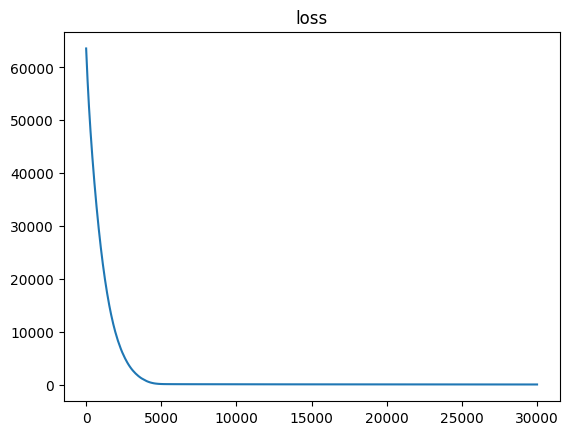

final loss 47.589935998935324


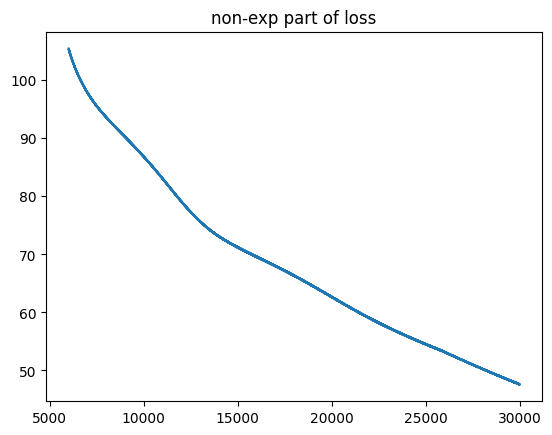

Function custom_tucker time:  0:04:37.192118
score: 47.58993599893535

iter79, params: (30000, 0.0001, (0.9, 0.6), 1e-09, 0)
iter 3000 loss 1331.7015510724154
iter 6000 loss 97.3025992830436
iter 9000 loss 83.5548930124093
iter 12000 loss 67.3604620166609
iter 15000 loss 54.7623364684939
iter 18000 loss 45.0377583898166
iter 21000 loss 37.50206721458321
iter 24000 loss 30.893654054087808
iter 27000 loss 25.35706230833453
iter 30000 loss 20.29366141869689


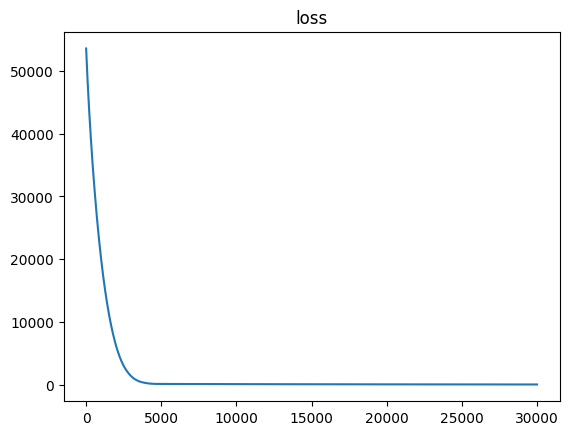

final loss 20.288645230264738


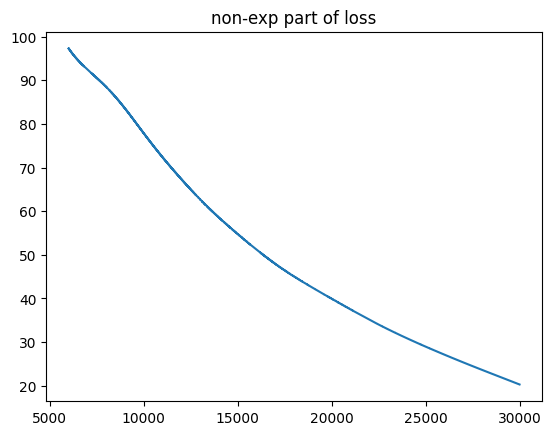

Function custom_tucker time:  0:04:35.896948
score: 20.288645230264734

iter80, params: (30000, 0.0001, (0.9, 0.9), 1e-09, 0)
iter 3000 loss 2357.2012387770183
iter 6000 loss 85.3656005007492
iter 9000 loss 39.045585162218785
iter 12000 loss 19.731814789746224
iter 15000 loss 9.722655938229972
iter 18000 loss 4.338285155423503
iter 21000 loss 1.548646890340418
iter 24000 loss 0.533532356113382


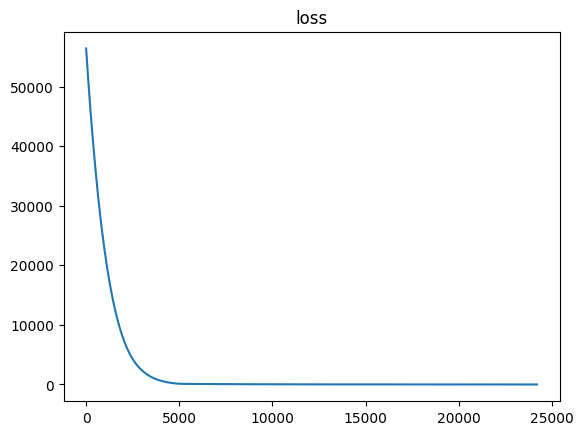

final loss 0.4998807057934784


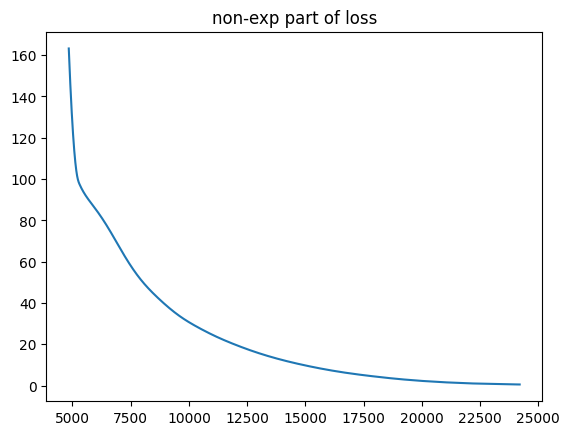

Function custom_tucker time:  0:03:43.313391
score: 0.4997315109777684

iter81, params: (40000, 0.001, (0.3, 0.3), 1e-09, 0)
iter 4000 loss 73.73018428091697
iter 8000 loss 51.978271761740565
iter 12000 loss 38.30841852306229
iter 16000 loss 28.884380753733048
iter 20000 loss 23.860962073384503
iter 24000 loss 19.692587113861983
iter 28000 loss 16.654487163286085
iter 32000 loss 13.80057035468559
iter 36000 loss 11.757952145516063
iter 40000 loss 11.335538477609264


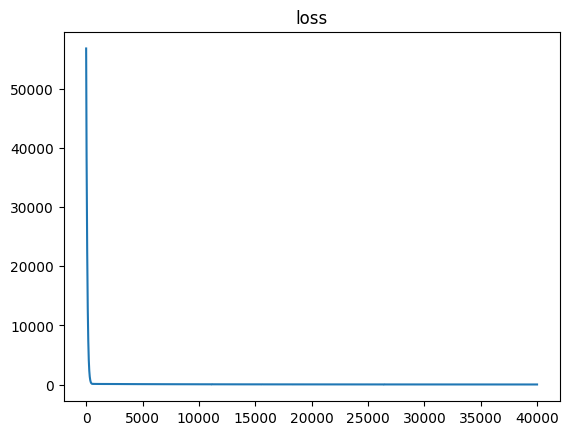

final loss 10.091572178577026


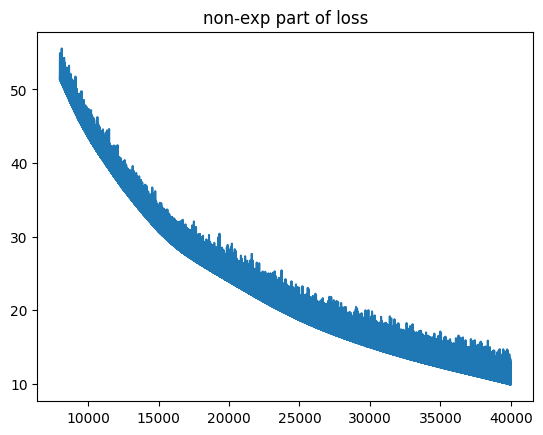

Function custom_tucker time:  0:06:20.649589
score: 10.091572178577026

iter82, params: (40000, 0.001, (0.3, 0.6), 1e-09, 0)
iter 4000 loss 80.0172181051209
iter 8000 loss 50.394038367436806
iter 12000 loss 38.554743372025165
iter 16000 loss 33.0875748072271
iter 20000 loss 25.662770696947973
iter 24000 loss 22.574079837901753
iter 28000 loss 19.484810534468426
iter 32000 loss 17.808441784434994
iter 36000 loss 12.743920873446141
iter 40000 loss 11.886489073831155


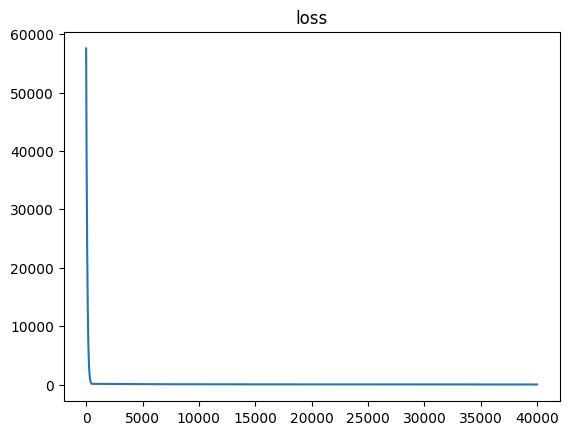

final loss 10.960814215500106


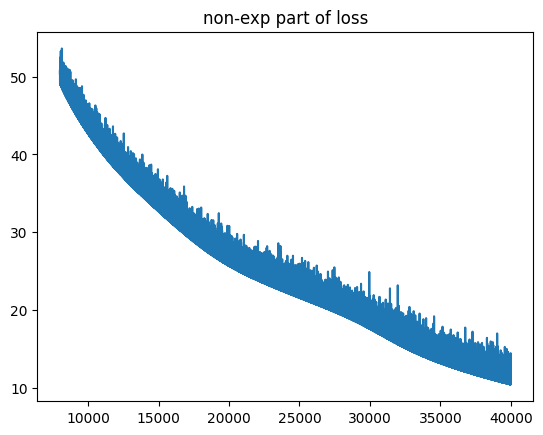

Function custom_tucker time:  0:06:31.830755
score: 10.960814215500113

iter83, params: (40000, 0.001, (0.3, 0.9), 1e-09, 0)
iter 4000 loss 76.74159945212202
iter 8000 loss 55.131722472924885
iter 12000 loss 43.90121462874922
iter 16000 loss 35.70565748830676
iter 20000 loss 29.51308018050489
iter 24000 loss 23.583604392304853
iter 28000 loss 18.683949523246596
iter 32000 loss 15.356616729791384
iter 36000 loss 12.890932401707898
iter 40000 loss 10.841619205863228


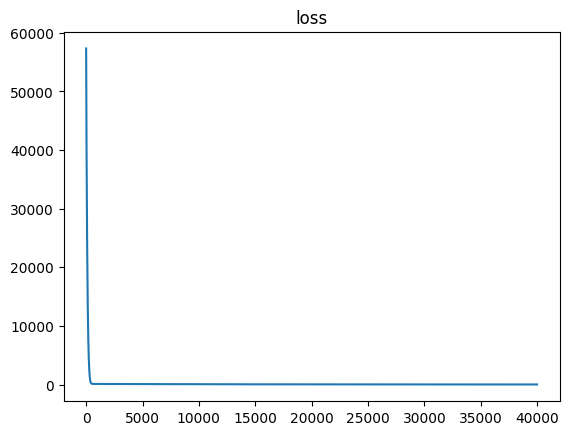

final loss 10.840466094539426


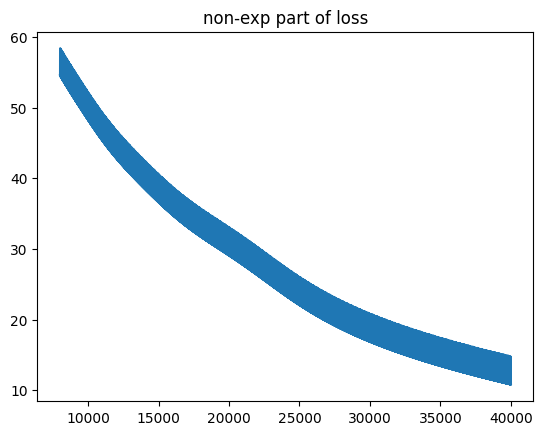

Function custom_tucker time:  0:06:29.496615
score: 10.84046609453943

iter84, params: (40000, 0.001, (0.6, 0.3), 1e-09, 0)
iter 4000 loss 57.44022664361109
iter 8000 loss 35.4767294574869
iter 12000 loss 25.40085796323201
iter 16000 loss 21.09161848391213
iter 20000 loss 16.442424702158288
iter 24000 loss 11.154027526608353
iter 28000 loss 7.777710116663367
iter 32000 loss 5.803509334587188
iter 36000 loss 3.7808921787804786
iter 40000 loss 3.0234095764948417


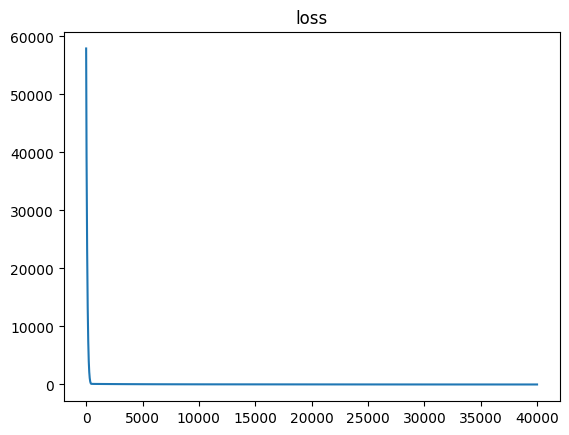

final loss 3.35131737960146


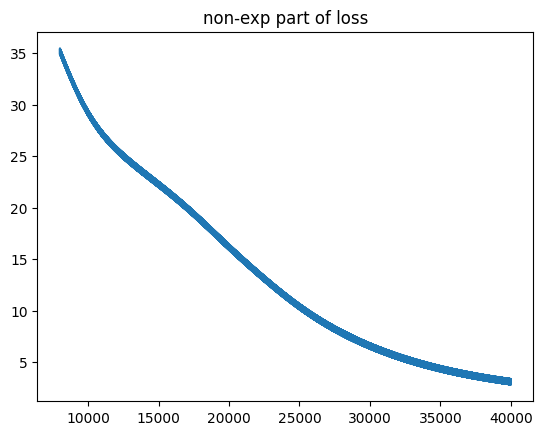

Function custom_tucker time:  0:06:09.664402
score: 3.3513173796014626

iter85, params: (40000, 0.001, (0.6, 0.6), 1e-09, 0)
iter 4000 loss 55.622461605107695
iter 8000 loss 32.30106399856662
iter 12000 loss 21.44938078518185
iter 16000 loss 15.639084507045222
iter 20000 loss 11.302362095827023
iter 24000 loss 7.30018075458892
iter 28000 loss 4.417379776723391
iter 32000 loss 2.583602444134481
iter 36000 loss 1.7863280462304634
iter 40000 loss 0.8684670112175465


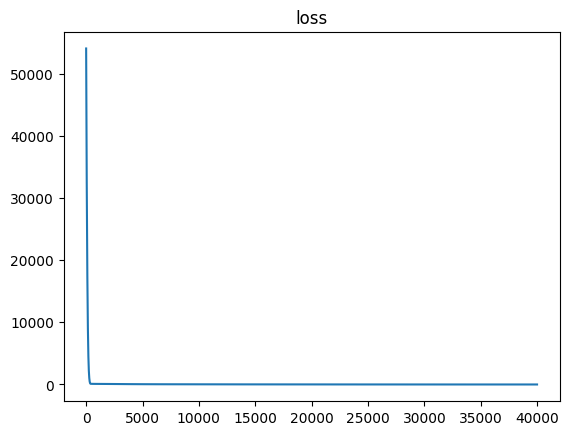

final loss 0.8286712845579544


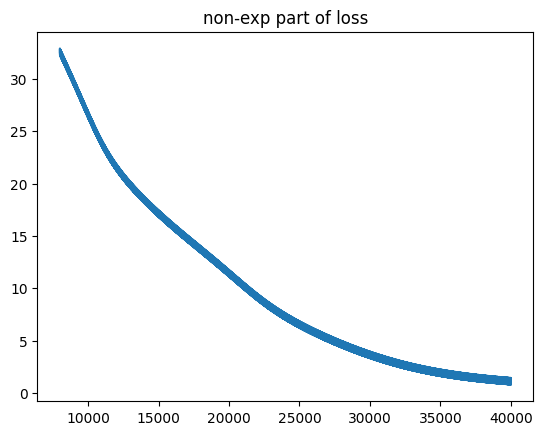

Function custom_tucker time:  0:06:17.095020
score: 0.8286712845579546

iter86, params: (40000, 0.001, (0.6, 0.9), 1e-09, 0)
iter 4000 loss 47.568817357217235
iter 8000 loss 27.869146909382014
iter 12000 loss 19.28845678275878
iter 16000 loss 13.399173136423341
iter 20000 loss 9.747892555647956
iter 24000 loss 6.19275607484145
iter 28000 loss 3.4375732420880185
iter 32000 loss 2.425690028760925
iter 36000 loss 1.2199847239972397
iter 40000 loss 0.7078731376749664


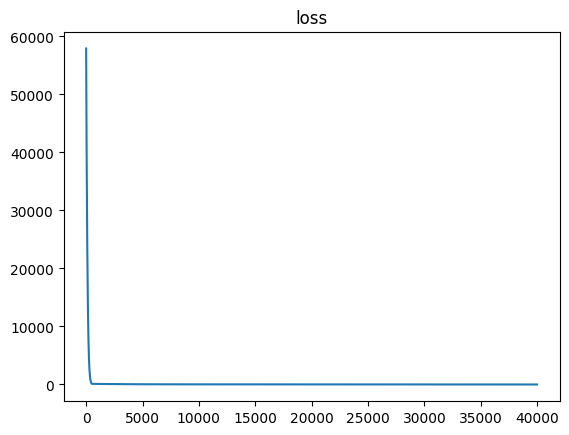

final loss 0.7256087411554245


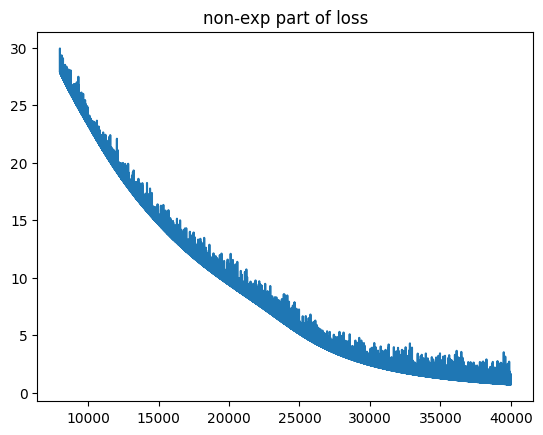

Function custom_tucker time:  0:06:10.276917
score: 0.7256087411554246

iter87, params: (40000, 0.001, (0.9, 0.3), 1e-09, 0)
iter 4000 loss 98.58297591346196
iter 8000 loss 91.21346556311269
iter 12000 loss 77.8196224792833
iter 16000 loss 64.04405094139526
iter 20000 loss 55.82043589908246
iter 24000 loss 50.569267719625536
iter 28000 loss 42.221174008850184
iter 32000 loss 38.348078890859576
iter 36000 loss 30.537299944052325
iter 40000 loss 30.305456501234392


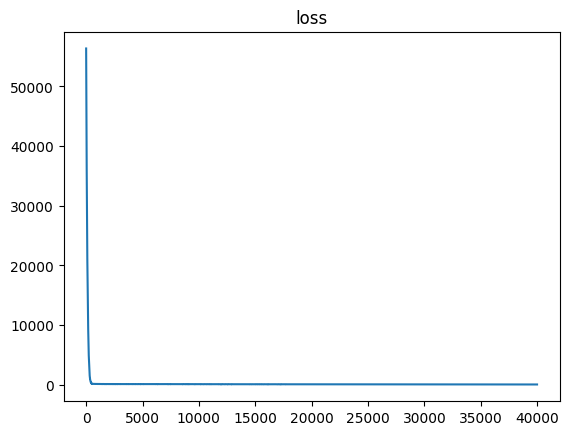

final loss 28.32848916249866


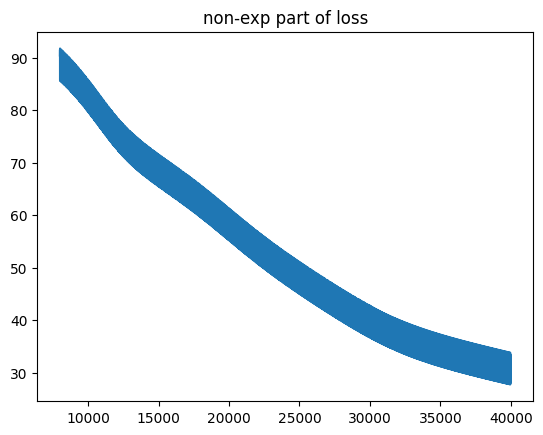

Function custom_tucker time:  0:06:11.900360
score: 28.328489162498624

iter88, params: (40000, 0.001, (0.9, 0.6), 1e-09, 0)
iter 4000 loss 26.356672962417957
iter 8000 loss 3.17925973200278


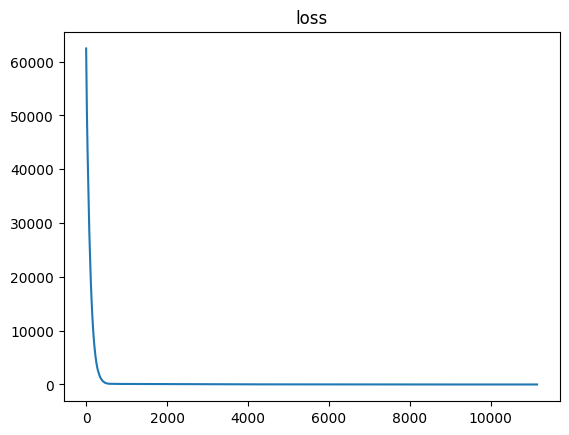

final loss 0.49984390706975845


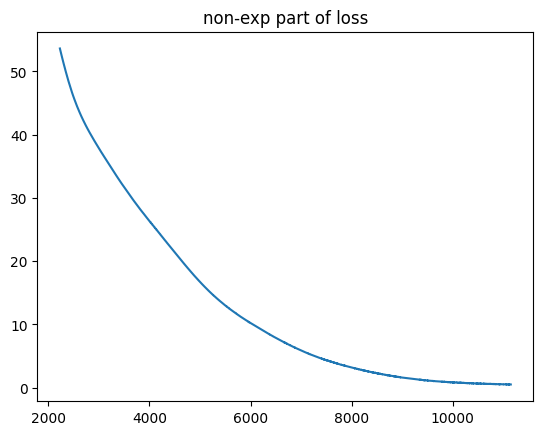

Function custom_tucker time:  0:01:46.458195
score: 0.4973348605377944

iter89, params: (40000, 0.001, (0.9, 0.9), 1e-09, 0)
iter 4000 loss 12.570719411923418
iter 8000 loss 1.2382540385431065


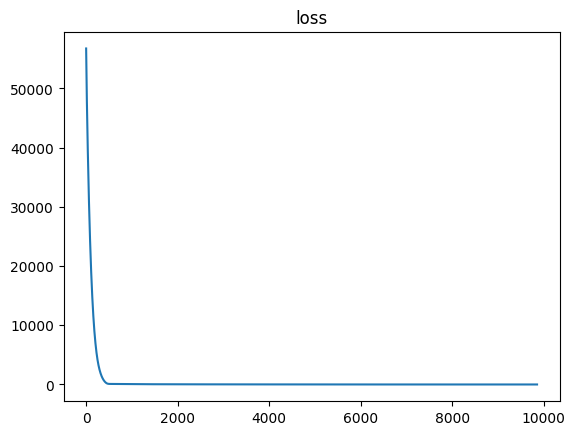

final loss 0.49879478885296047


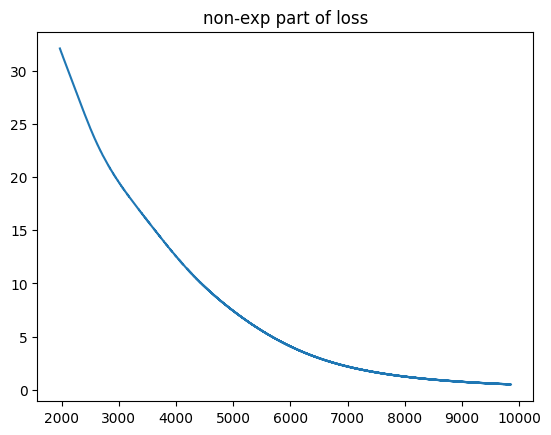

Function custom_tucker time:  0:01:31.416267
score: 0.5076797702304846

iter90, params: (40000, 0.0005, (0.3, 0.3), 1e-09, 0)
iter 4000 loss 77.2288614683417
iter 8000 loss 50.363217833723866
iter 12000 loss 37.80192927695396
iter 16000 loss 31.59686540648773
iter 20000 loss 25.636420475791343
iter 24000 loss 19.929750711936503
iter 28000 loss 16.65644977986626
iter 32000 loss 13.532939450470398
iter 36000 loss 11.76560140056975
iter 40000 loss 9.406052922173949


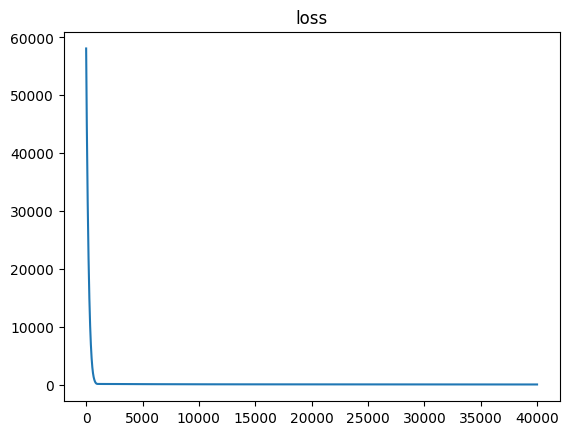

final loss 10.371517234880184


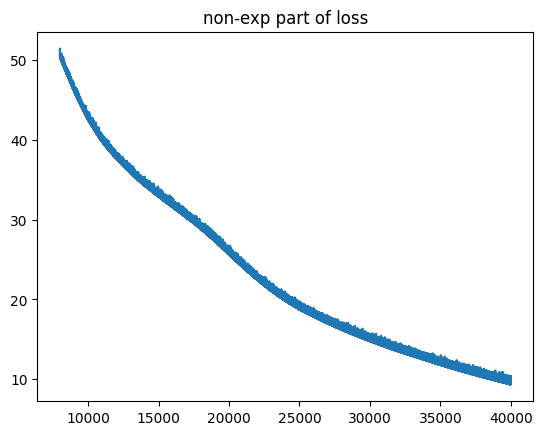

Function custom_tucker time:  0:06:12.005678
score: 10.371517234880178

iter91, params: (40000, 0.0005, (0.3, 0.6), 1e-09, 0)
iter 4000 loss 73.5475517978192
iter 8000 loss 49.26486853803594
iter 12000 loss 37.12932717666398
iter 16000 loss 31.02247763472543
iter 20000 loss 25.969533592551475
iter 24000 loss 22.281211925222294
iter 28000 loss 18.911959651708525
iter 32000 loss 16.09780364856363
iter 36000 loss 13.709097258540686
iter 40000 loss 11.574643133684424


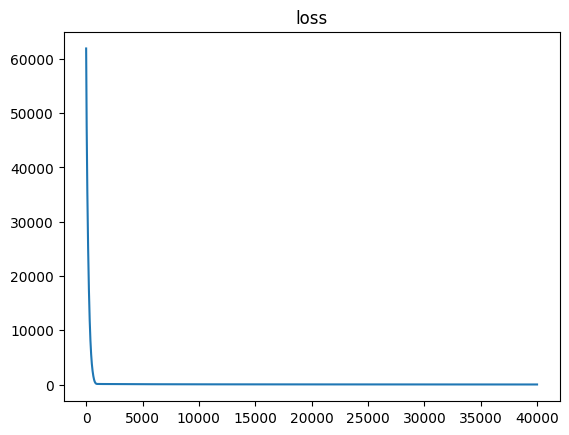

final loss 11.557729582372087


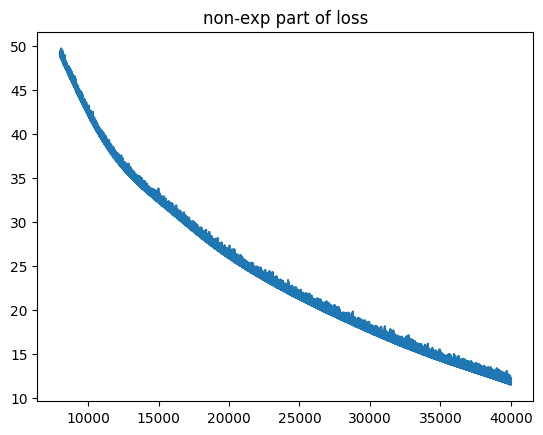

Function custom_tucker time:  0:06:08.004134
score: 11.557729582372094

iter92, params: (40000, 0.0005, (0.3, 0.9), 1e-09, 0)
iter 4000 loss 76.22887594990335
iter 8000 loss 55.514856195218016
iter 12000 loss 41.03024473248877
iter 16000 loss 31.34936053013156
iter 20000 loss 24.35222537655161
iter 24000 loss 20.230115782138846
iter 28000 loss 17.279626747934255
iter 32000 loss 14.579881340271244
iter 36000 loss 12.008372583275666
iter 40000 loss 9.83794293118906


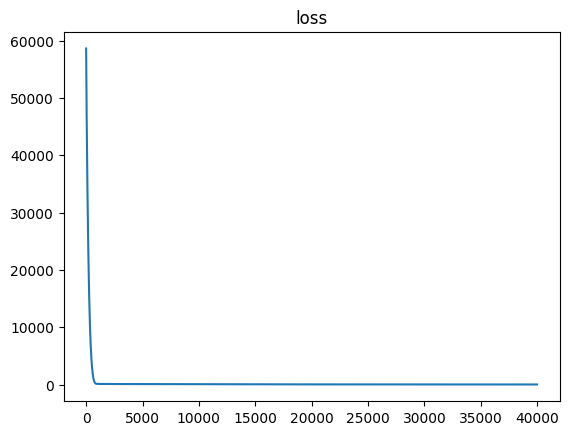

final loss 9.484896141810419


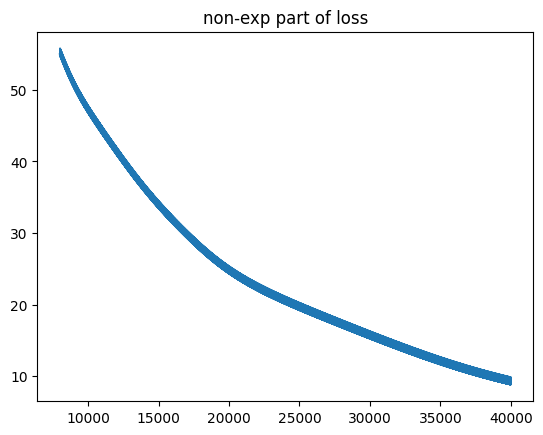

Function custom_tucker time:  0:06:08.175740
score: 9.48489614181042

iter93, params: (40000, 0.0005, (0.6, 0.3), 1e-09, 0)
iter 4000 loss 58.90853147029811
iter 8000 loss 38.57500180908662
iter 12000 loss 30.234690156672226
iter 16000 loss 24.092647492343648
iter 20000 loss 17.12553202126443
iter 24000 loss 12.283481979595832
iter 28000 loss 8.841955881578656
iter 32000 loss 6.430215947111307
iter 36000 loss 4.444064414057711
iter 40000 loss 3.114959208031611


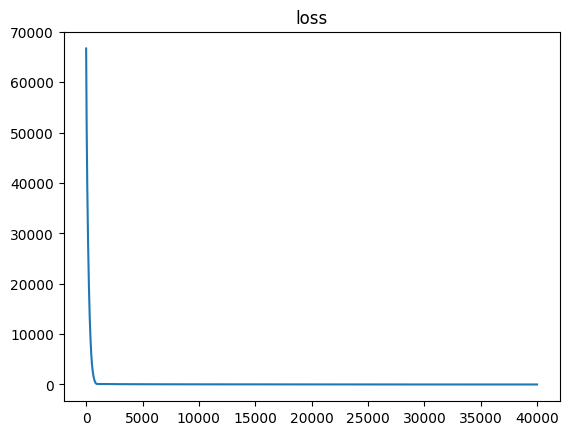

final loss 3.1984864208487376


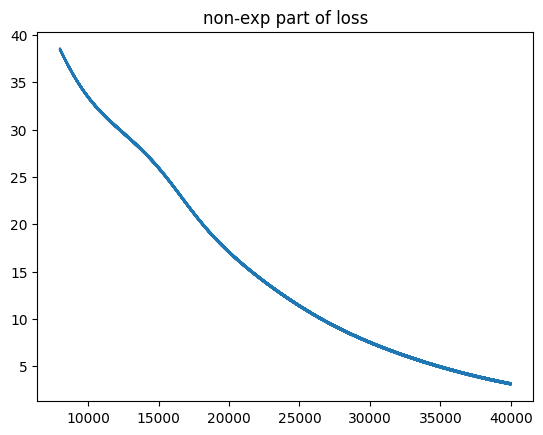

Function custom_tucker time:  0:06:08.328590
score: 3.1984864208487376

iter94, params: (40000, 0.0005, (0.6, 0.6), 1e-09, 0)
iter 4000 loss 52.17782194581977
iter 8000 loss 32.78616964616075
iter 12000 loss 22.59661469718563
iter 16000 loss 16.656865538659922
iter 20000 loss 11.471930415169124
iter 24000 loss 7.627705611100018
iter 28000 loss 5.176236169441006
iter 32000 loss 3.29276464534401
iter 36000 loss 2.093700058168549
iter 40000 loss 1.2958519280356164


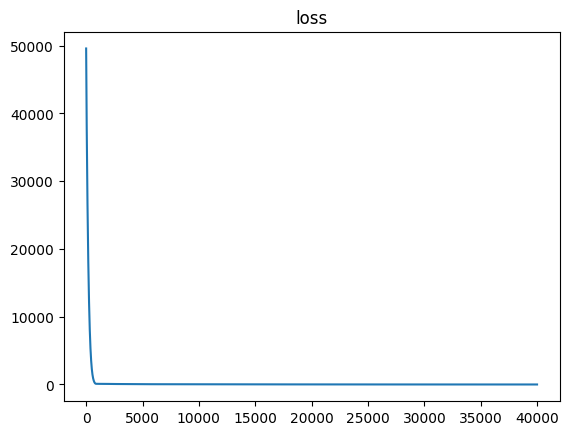

final loss 1.2987632067048969


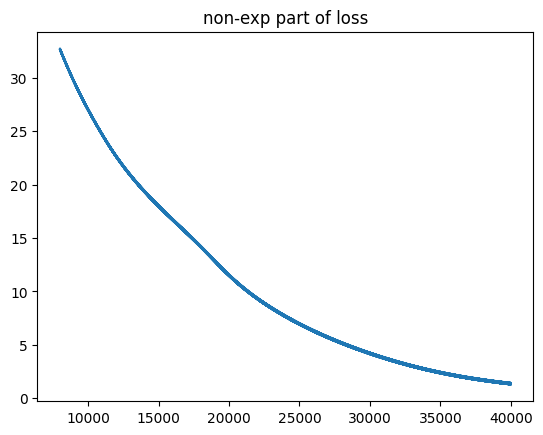

Function custom_tucker time:  0:06:07.475899
score: 1.2987632067048978

iter95, params: (40000, 0.0005, (0.6, 0.9), 1e-09, 0)
iter 4000 loss 51.65248271118873
iter 8000 loss 33.02674594187974
iter 12000 loss 23.208895801202893
iter 16000 loss 15.416536739844611
iter 20000 loss 9.599243267289879
iter 24000 loss 6.203911285223917
iter 28000 loss 4.204290326343882
iter 32000 loss 2.5733841928073473
iter 36000 loss 1.530541868609022
iter 40000 loss 0.9550127389320924


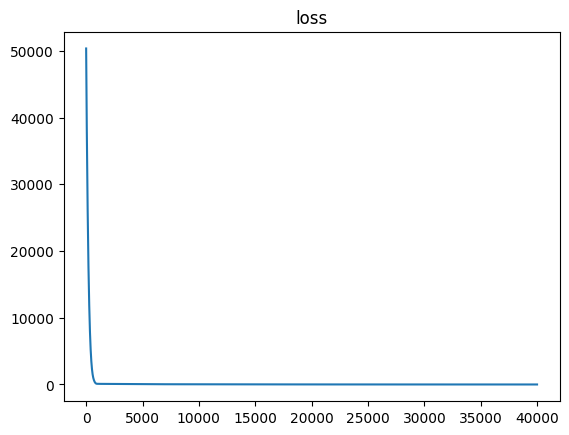

final loss 1.0121878313580606


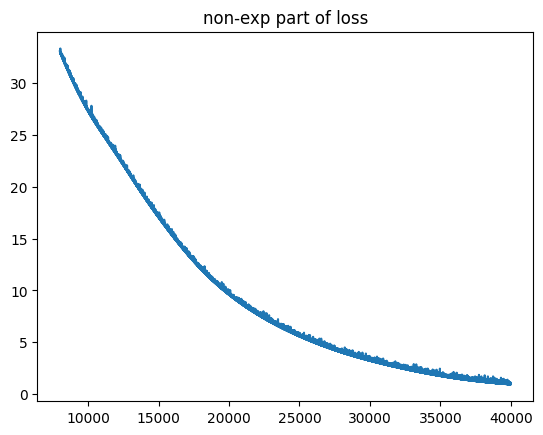

Function custom_tucker time:  0:06:12.853585
score: 1.0121878313580612

iter96, params: (40000, 0.0005, (0.9, 0.3), 1e-09, 0)
iter 4000 loss 94.72341334354897
iter 8000 loss 85.55939640824718
iter 12000 loss 72.18790826713624
iter 16000 loss 61.837308267052215
iter 20000 loss 51.580064862523
iter 24000 loss 46.15505636178057
iter 28000 loss 41.170752475760025
iter 32000 loss 35.787304519658036
iter 36000 loss 32.54556444148161
iter 40000 loss 29.36307202945815


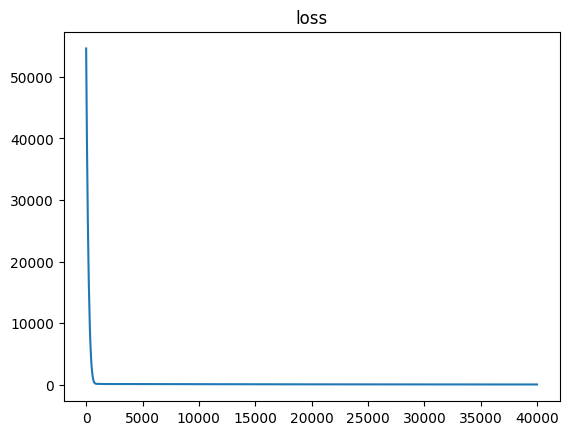

final loss 28.891745271060074


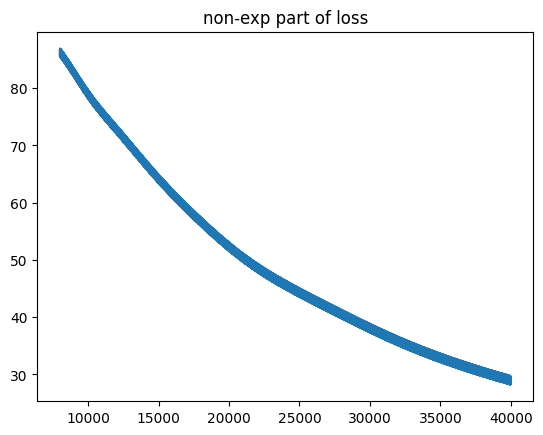

Function custom_tucker time:  0:06:08.224706
score: 28.8917452710601

iter97, params: (40000, 0.0005, (0.9, 0.6), 1e-09, 0)
iter 4000 loss 55.78142294611016
iter 8000 loss 10.440375581734736
iter 12000 loss 0.8104562031918775


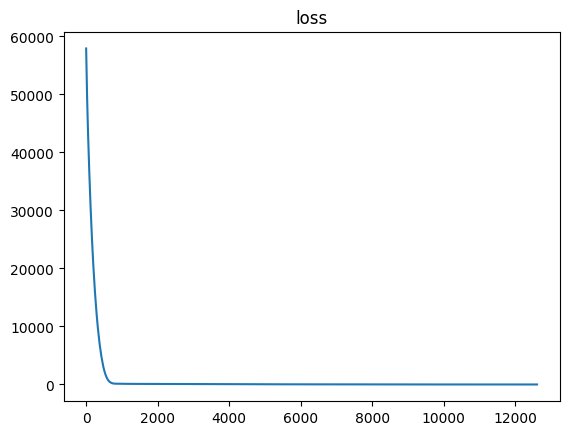

final loss 0.49953101273059775


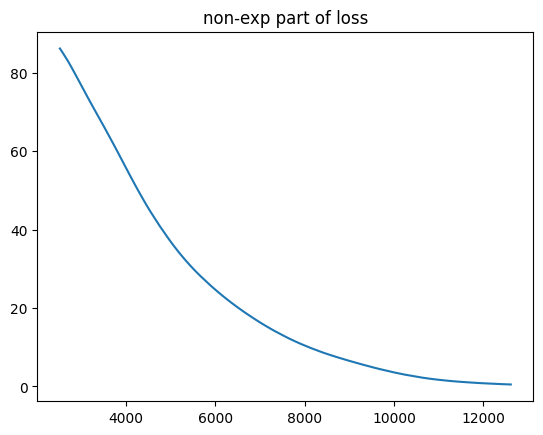

Function custom_tucker time:  0:02:04.263771
score: 0.5012261793703666

iter98, params: (40000, 0.0005, (0.9, 0.9), 1e-09, 0)
iter 4000 loss 15.778862089659915
iter 8000 loss 2.4769613968557
iter 12000 loss 0.5239761343164453


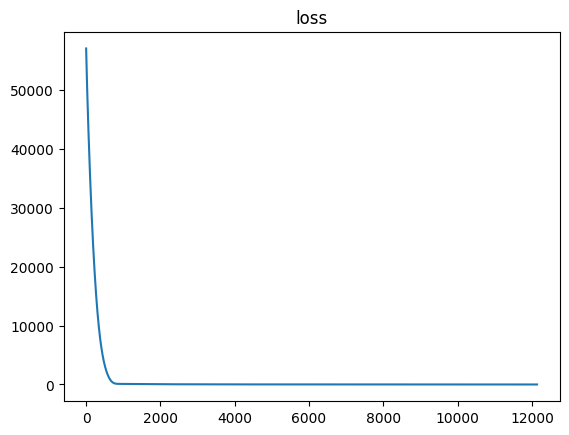

final loss 0.4993122808088274


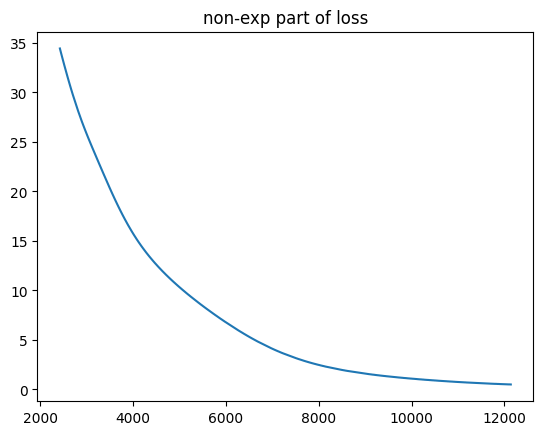

Function custom_tucker time:  0:01:52.542930
score: 0.501450819893188

iter99, params: (40000, 0.0001, (0.3, 0.3), 1e-09, 0)
iter 4000 loss 103.45786040060106
iter 8000 loss 65.04976984117339
iter 12000 loss 41.71222938788532
iter 16000 loss 31.681563252847745
iter 20000 loss 25.740297172024718
iter 24000 loss 21.00764029754123
iter 28000 loss 16.5323473850578
iter 32000 loss 12.891437998817926
iter 36000 loss 10.191633208382097
iter 40000 loss 8.170332357185826


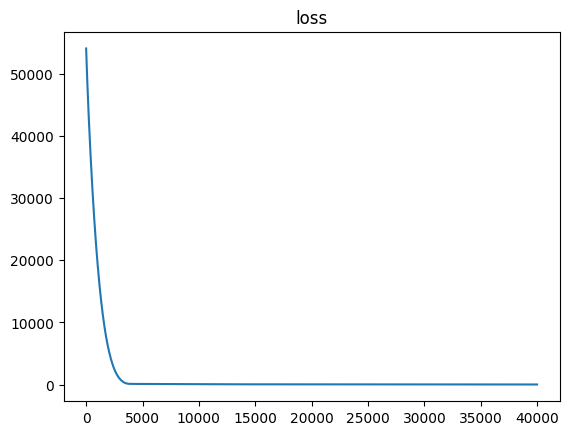

final loss 8.151678658018685


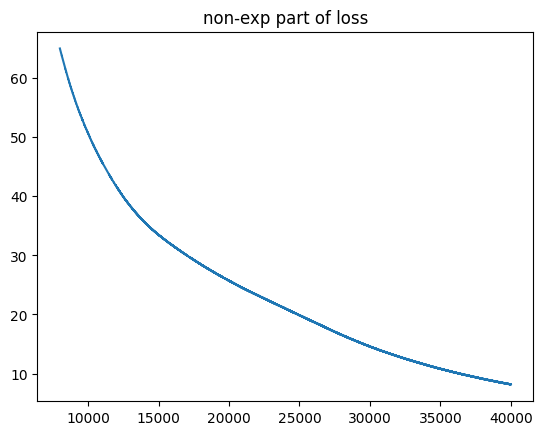

Function custom_tucker time:  0:06:10.074637
score: 8.151678658018685

iter100, params: (40000, 0.0001, (0.3, 0.6), 1e-09, 0)
iter 4000 loss 102.31825333020532
iter 8000 loss 71.12086864186753
iter 12000 loss 48.55975088184904
iter 16000 loss 36.23031293490797
iter 20000 loss 28.639087741192103
iter 24000 loss 23.511600159296687
iter 28000 loss 19.717553709461015
iter 32000 loss 16.711599117507543
iter 36000 loss 14.063887042015585
iter 40000 loss 11.535902356151883


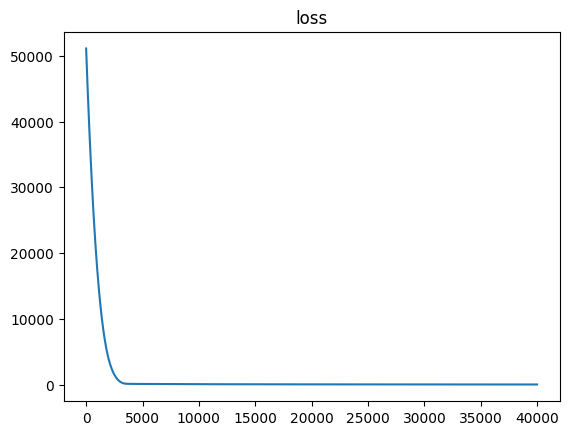

final loss 11.53476280921678


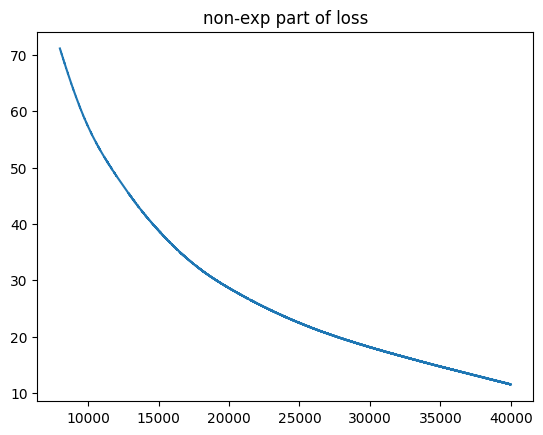

Function custom_tucker time:  0:06:24.950658
score: 11.534762809216778

iter101, params: (40000, 0.0001, (0.3, 0.9), 1e-09, 0)
iter 4000 loss 165.57959067541404
iter 8000 loss 69.99589322491855
iter 12000 loss 45.14191713757969
iter 16000 loss 34.02278699510469
iter 20000 loss 27.474581985508006
iter 24000 loss 22.355104003499985
iter 28000 loss 18.609041431892063
iter 32000 loss 15.242295976452436
iter 36000 loss 12.496807315258314
iter 40000 loss 10.277819465298299


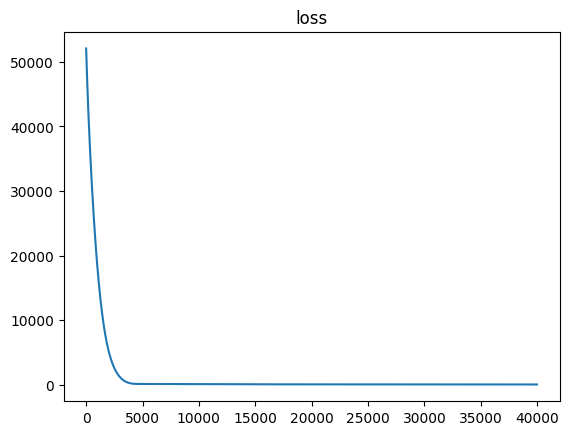

final loss 10.277344323962215


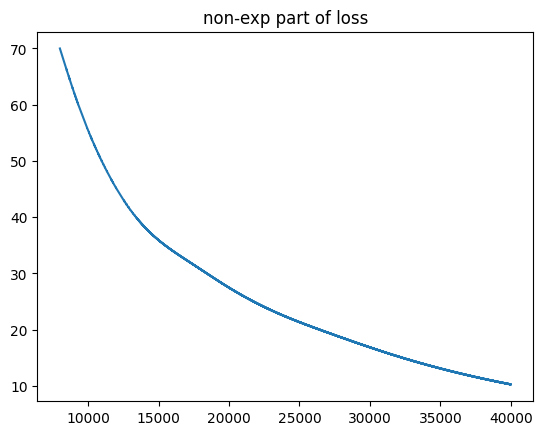

Function custom_tucker time:  0:06:14.212678
score: 10.277344323962222

iter102, params: (40000, 0.0001, (0.6, 0.3), 1e-09, 0)
iter 4000 loss 590.7829269199733
iter 8000 loss 68.02105111913556
iter 12000 loss 44.7245545667907
iter 16000 loss 35.0149852388479
iter 20000 loss 28.169704061343996
iter 24000 loss 24.46753432570683
iter 28000 loss 21.51242672830782
iter 32000 loss 18.861409657088306
iter 36000 loss 16.389714928774502
iter 40000 loss 14.143905768604466


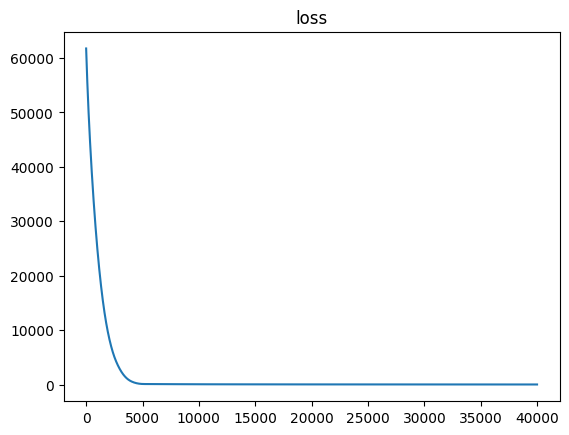

final loss 14.159057554826731


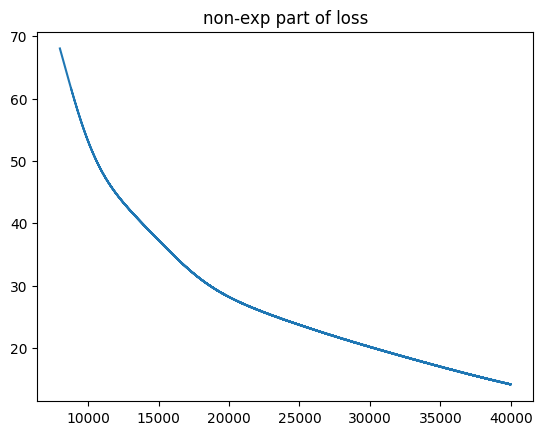

Function custom_tucker time:  0:06:10.027244
score: 14.159057554826724

iter103, params: (40000, 0.0001, (0.6, 0.6), 1e-09, 0)
iter 4000 loss 551.2627509286801
iter 8000 loss 56.41894460594744
iter 12000 loss 34.51537732023316
iter 16000 loss 23.118290947203914
iter 20000 loss 15.972363794485837
iter 24000 loss 11.42828732645702
iter 28000 loss 8.284247229387331
iter 32000 loss 5.929749461068131
iter 36000 loss 4.301119207745639
iter 40000 loss 3.1915256936998975


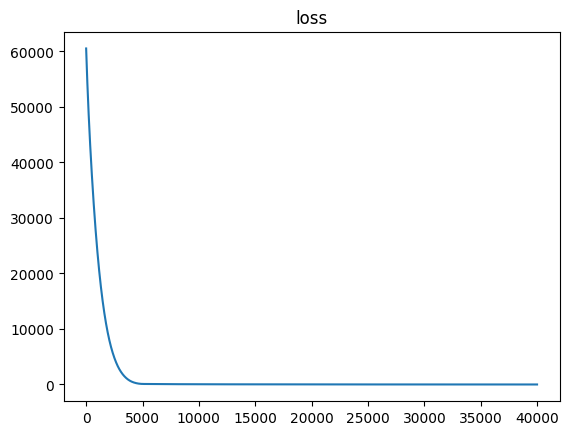

final loss 3.1933332133736885


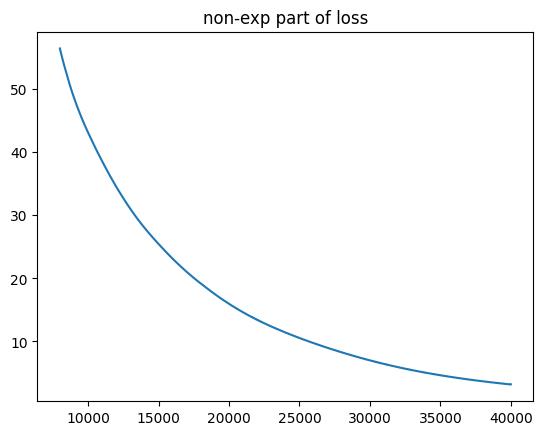

Function custom_tucker time:  0:06:06.162768
score: 3.1933332133736907

iter104, params: (40000, 0.0001, (0.6, 0.9), 1e-09, 0)
iter 4000 loss 139.7314022038936
iter 8000 loss 57.39688429546046
iter 12000 loss 33.086459319247616
iter 16000 loss 23.334768342558412
iter 20000 loss 16.658389962867766
iter 24000 loss 11.774790611700313
iter 28000 loss 6.99312629826423
iter 32000 loss 4.196378026309816
iter 36000 loss 2.564844456711974
iter 40000 loss 1.447551354824462


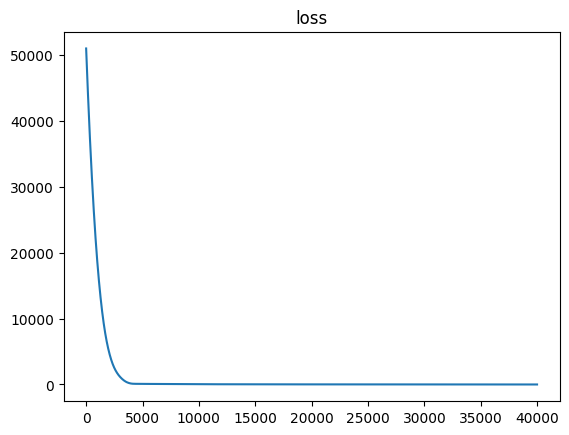

final loss 1.4476887750378047


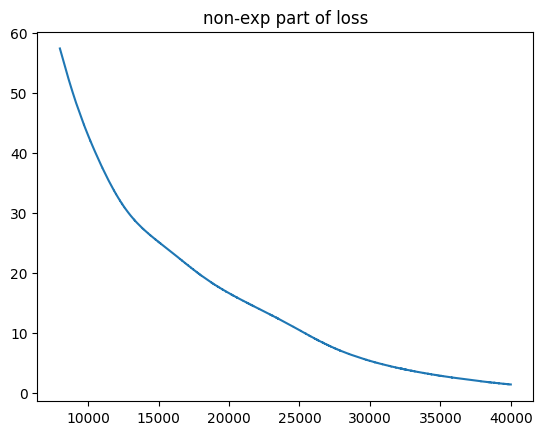

Function custom_tucker time:  0:06:27.437913
score: 1.4476887750378036

iter105, params: (40000, 0.0001, (0.9, 0.3), 1e-09, 0)
iter 4000 loss 332.76977081473535
iter 8000 loss 93.78851174084687
iter 12000 loss 80.98956093440559
iter 16000 loss 69.39094070098875
iter 20000 loss 61.276842414867986
iter 24000 loss 55.18864271524501
iter 28000 loss 50.19773405953859
iter 32000 loss 45.24469574789929
iter 36000 loss 40.38641419245846
iter 40000 loss 36.211694643758776


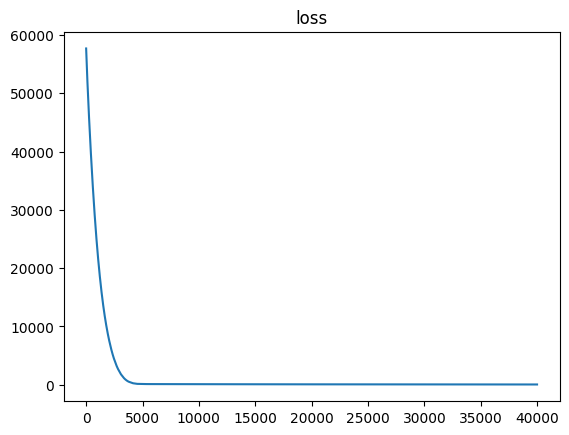

final loss 36.184310640213646


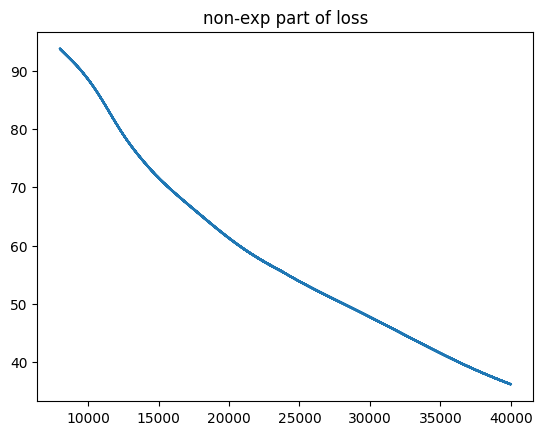

Function custom_tucker time:  0:06:06.444944
score: 36.184310640213646

iter106, params: (40000, 0.0001, (0.9, 0.6), 1e-09, 0)
iter 4000 loss 198.40312452015567
iter 8000 loss 87.87980610682328
iter 12000 loss 66.96729909579061
iter 16000 loss 51.244527652811456
iter 20000 loss 38.548829365073054
iter 24000 loss 30.138450924128264
iter 28000 loss 23.568500171700975
iter 32000 loss 18.2328186648953
iter 36000 loss 13.012981123936894
iter 40000 loss 8.664727600844799


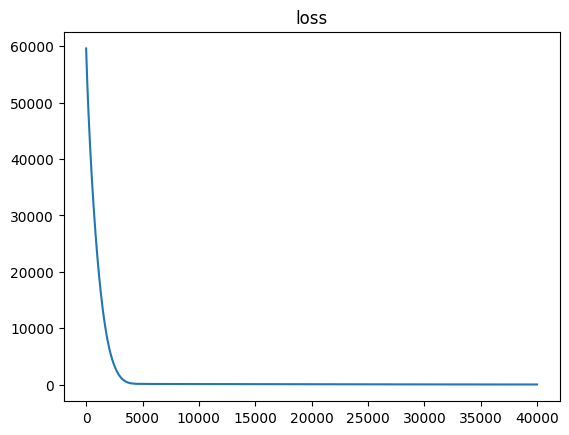

final loss 8.665586995442785


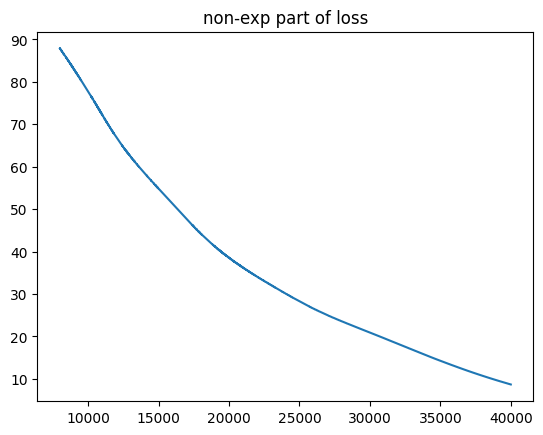

Function custom_tucker time:  0:06:10.087128
score: 8.665586995442778

iter107, params: (40000, 0.0001, (0.9, 0.9), 1e-09, 0)
iter 4000 loss 389.1964577867973
iter 8000 loss 45.52234114867584
iter 12000 loss 16.7746973825441
iter 16000 loss 5.1849524827892575
iter 20000 loss 1.1077003531296077


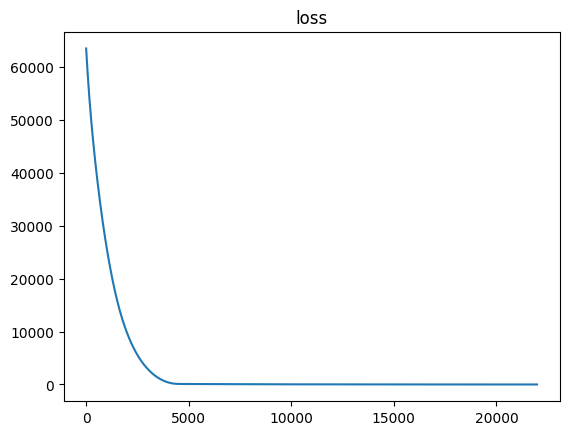

final loss 0.49997301649932185


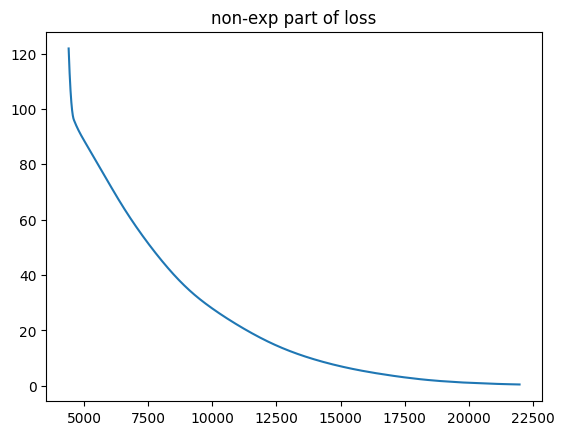

Function custom_tucker time:  0:03:20.312192
score: 0.4998806452086706

iter108, params: (50000, 0.001, (0.3, 0.3), 1e-09, 0)
iter 5000 loss 82.67690752624773
iter 10000 loss 53.981017829489964
iter 15000 loss 38.9267137831386
iter 20000 loss 31.32133261777246
iter 25000 loss 23.25732262007954
iter 30000 loss 17.321837106137295
iter 35000 loss 13.711606567298388
iter 40000 loss 9.095375886329759
iter 45000 loss 5.651675289324121
iter 50000 loss 5.8968750593159935


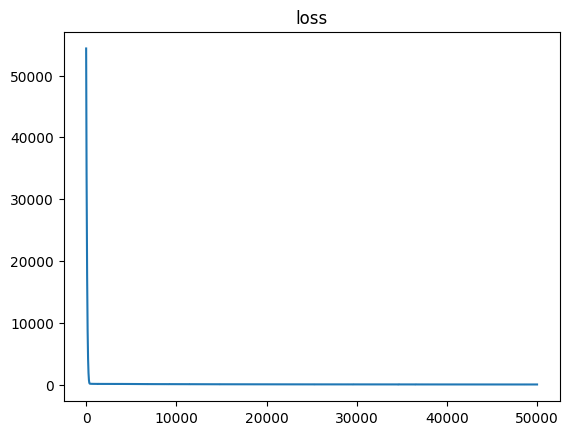

final loss 4.666181986349749


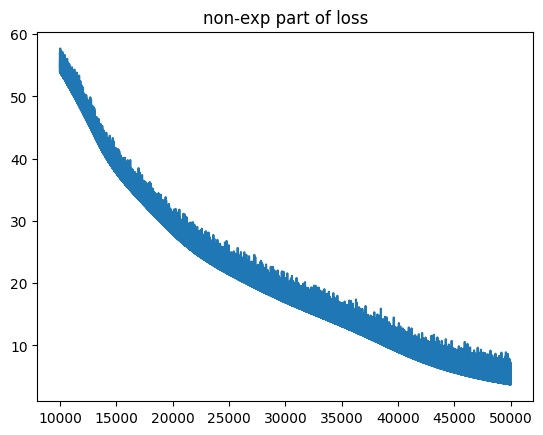

Function custom_tucker time:  0:07:40.874100
score: 4.666181986349756

iter109, params: (50000, 0.001, (0.3, 0.6), 1e-09, 0)
iter 5000 loss 73.92838575061651
iter 10000 loss 48.45549085203331
iter 15000 loss 37.48097681789684
iter 20000 loss 28.35458444996792
iter 25000 loss 23.188642949410845
iter 30000 loss 22.560240155725133
iter 35000 loss 15.165630188116793
iter 40000 loss 12.15464155478642
iter 45000 loss 9.64438198211395
iter 50000 loss 7.194291755659233


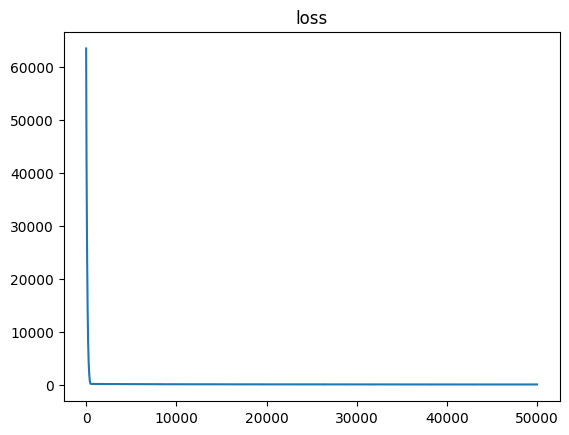

final loss 10.249773103521528


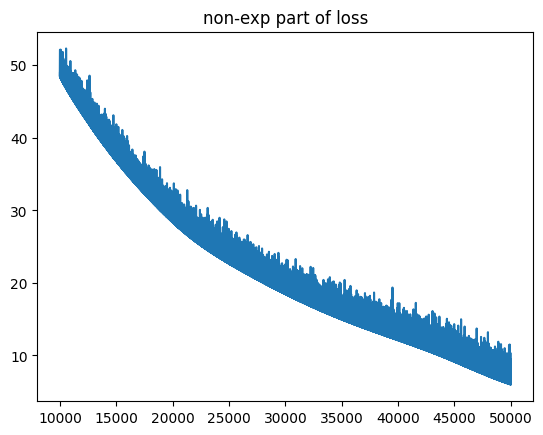

Function custom_tucker time:  0:07:40.791091
score: 10.24977310352153

iter110, params: (50000, 0.001, (0.3, 0.9), 1e-09, 0)
iter 5000 loss 75.48920194241713
iter 10000 loss 45.663793061642764
iter 15000 loss 35.755312032373695
iter 20000 loss 28.26924770461425
iter 25000 loss 21.981786963181765
iter 30000 loss 16.523735222472556
iter 35000 loss 12.838504125706363
iter 40000 loss 10.172734458039733
iter 45000 loss 9.206365372978947
iter 50000 loss 8.650128354817504


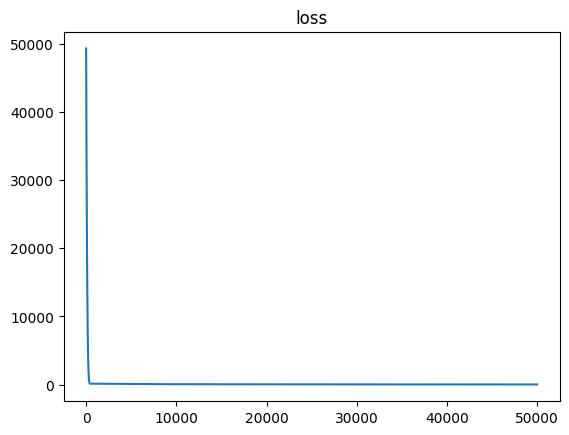

final loss 6.8227271470542


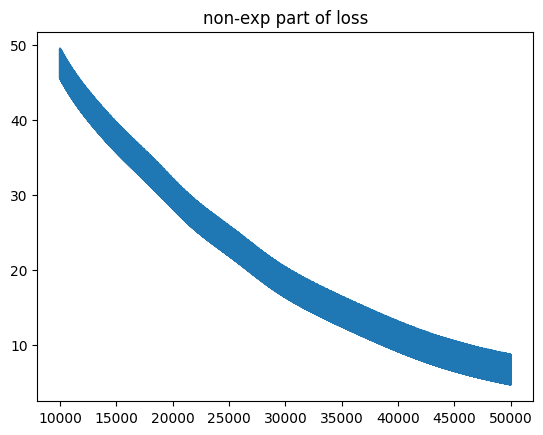

Function custom_tucker time:  0:07:40.472951
score: 6.822727147054194

iter111, params: (50000, 0.001, (0.6, 0.3), 1e-09, 0)
iter 5000 loss 48.043970726305204
iter 10000 loss 29.19030281493781
iter 15000 loss 21.83518410079542
iter 20000 loss 15.318647812631037
iter 25000 loss 11.236624423236597
iter 30000 loss 8.40177044586223
iter 35000 loss 4.613576108792694
iter 40000 loss 2.6073934618167445
iter 45000 loss 2.1975494892631438
iter 50000 loss 1.3233200851202613


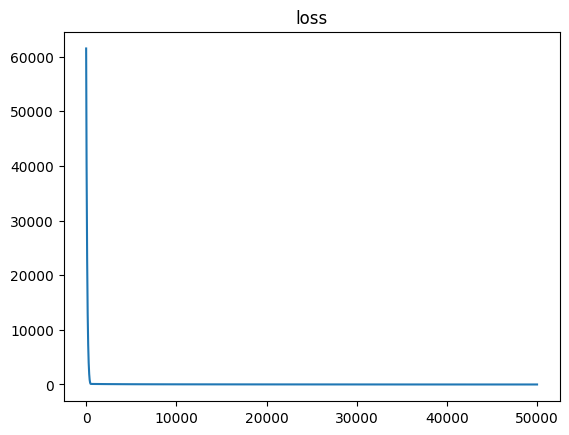

final loss 1.6443654939716053


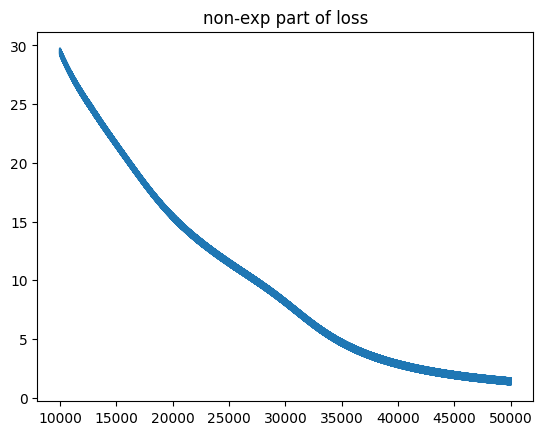

Function custom_tucker time:  0:07:38.158852
score: 1.6443654939716057

iter112, params: (50000, 0.001, (0.6, 0.6), 1e-09, 0)
iter 5000 loss 45.5026624089096
iter 10000 loss 29.079155951210964
iter 15000 loss 18.702258734898933
iter 20000 loss 11.924818421536873
iter 25000 loss 7.266530987316349
iter 30000 loss 4.475589875363838
iter 35000 loss 2.827207944731917
iter 40000 loss 2.2520713214332173
iter 45000 loss 1.7485125248053086
iter 50000 loss 1.4647996456868517


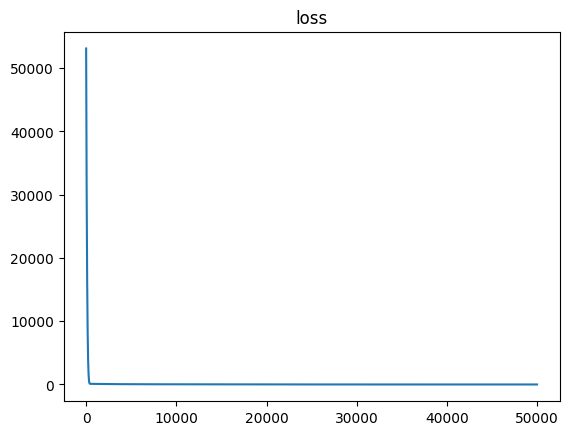

final loss 1.5263896159355976


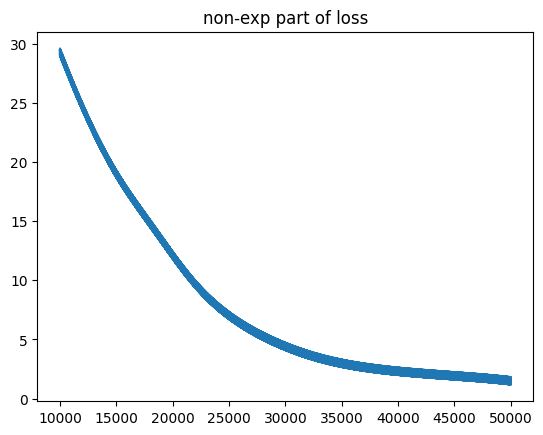

Function custom_tucker time:  0:07:41.628179
score: 1.5263896159355979

iter113, params: (50000, 0.001, (0.6, 0.9), 1e-09, 0)
iter 5000 loss 45.47747226951073
iter 10000 loss 26.2569466233568
iter 15000 loss 16.502862917283675
iter 20000 loss 9.522521384046621
iter 25000 loss 5.308718652903697
iter 30000 loss 2.1951624558812264
iter 35000 loss 0.9203166374749655


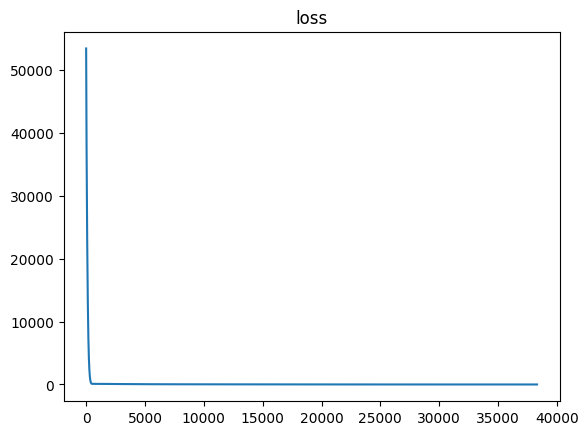

final loss 0.49922249192975493


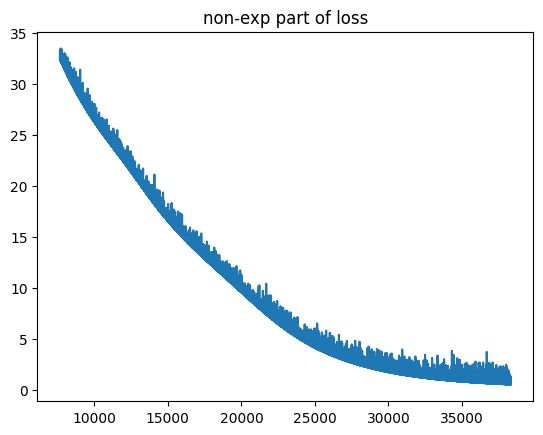

Function custom_tucker time:  0:05:51.949078
score: 0.5032484697326614

iter114, params: (50000, 0.001, (0.9, 0.3), 1e-09, 0)
iter 5000 loss 93.56480462075633
iter 10000 loss 74.12511671451342
iter 15000 loss 60.17419727383334
iter 20000 loss 54.040711115116856
iter 25000 loss 44.936404854354265
iter 30000 loss 41.401633222495555
iter 35000 loss 31.64144112206962
iter 40000 loss 31.434683256673406
iter 45000 loss 29.90393748862125
iter 50000 loss 20.81909158343676


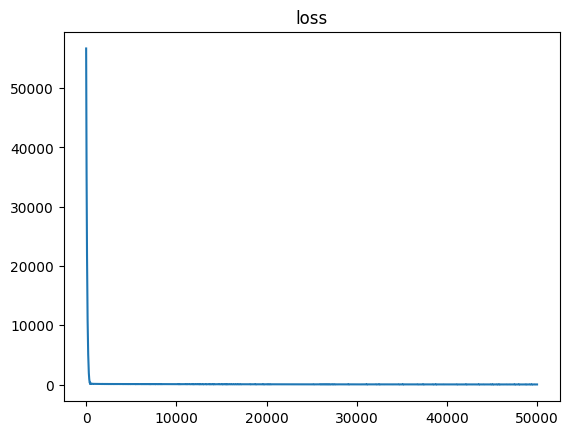

final loss 25.16720067028318


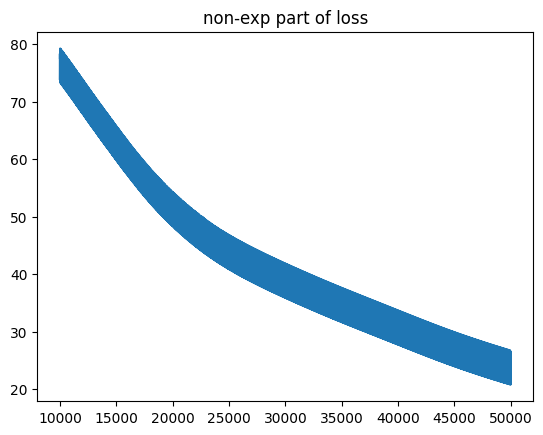

Function custom_tucker time:  0:07:42.154486
score: 25.167200670283194

iter115, params: (50000, 0.001, (0.9, 0.6), 1e-09, 0)
iter 5000 loss 12.903325876032834
iter 10000 loss 0.8189083400266759


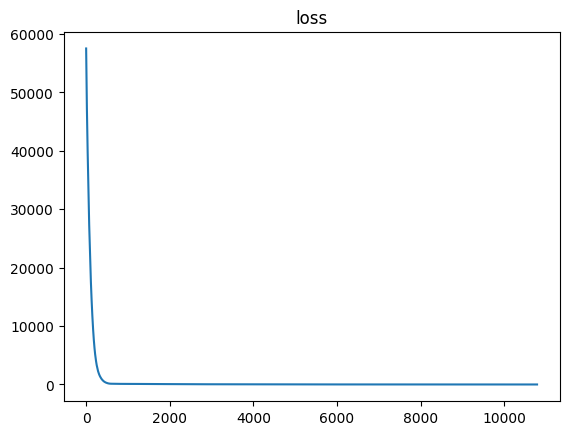

final loss 0.49641450010529603


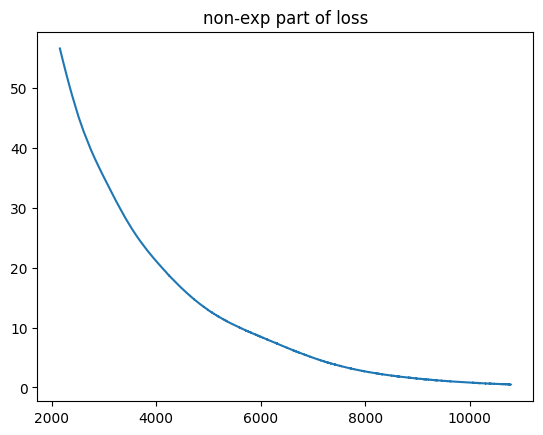

Function custom_tucker time:  0:01:40.210475
score: 0.4967885913763346

iter116, params: (50000, 0.001, (0.9, 0.9), 1e-09, 0)
iter 5000 loss 9.859472633181506
iter 10000 loss 0.6882546208697344


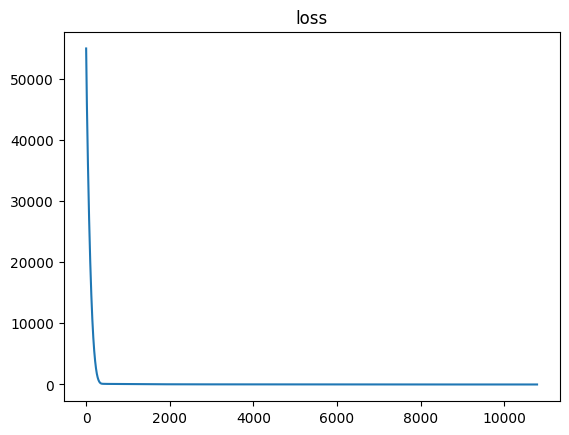

final loss 0.49917441015052766


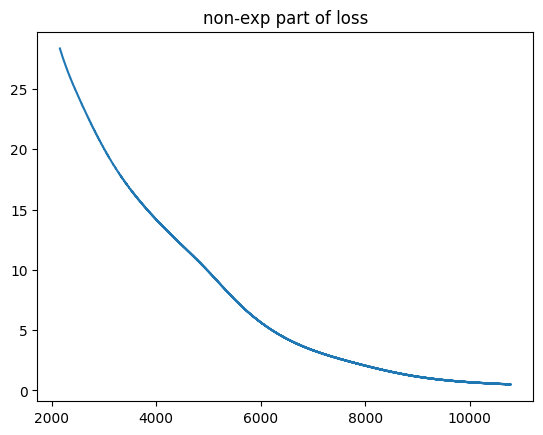

Function custom_tucker time:  0:01:40.520771
score: 0.5093590875764064

iter117, params: (50000, 0.0005, (0.3, 0.3), 1e-09, 0)
iter 5000 loss 66.78728889126099
iter 10000 loss 41.081210265864364
iter 15000 loss 31.72840047546473
iter 20000 loss 24.84689574278158
iter 25000 loss 20.046943654432326
iter 30000 loss 15.483393673529573
iter 35000 loss 11.26320514826619
iter 40000 loss 8.327155141944841
iter 45000 loss 6.349689536799071
iter 50000 loss 4.551538414746652


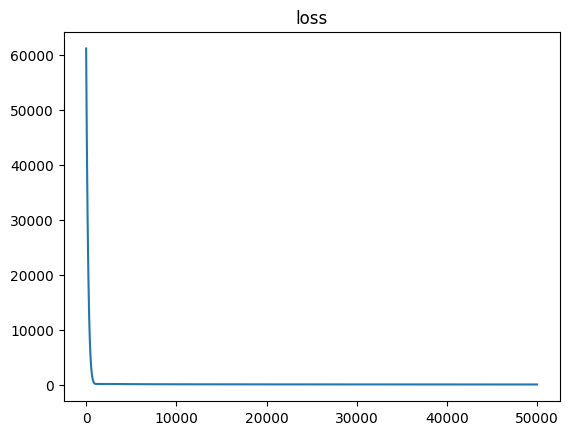

final loss 4.552276346785795


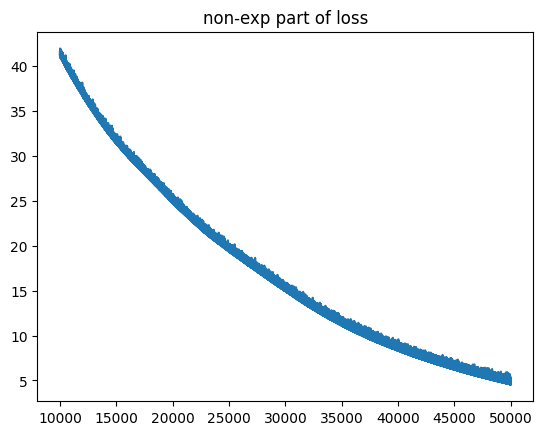

Function custom_tucker time:  0:07:37.503094
score: 4.552276346785792

iter118, params: (50000, 0.0005, (0.3, 0.6), 1e-09, 0)
iter 5000 loss 74.10764391947225
iter 10000 loss 52.25809206584155
iter 15000 loss 35.65087627094578
iter 20000 loss 27.33896343184698
iter 25000 loss 21.41135837798059
iter 30000 loss 16.687162765896392
iter 35000 loss 13.05288408437406
iter 40000 loss 9.574877932723203
iter 45000 loss 6.936674273945765
iter 50000 loss 5.643306273754833


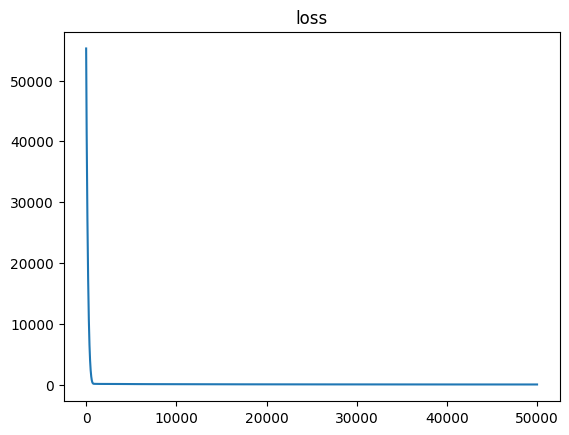

final loss 5.327748073138488


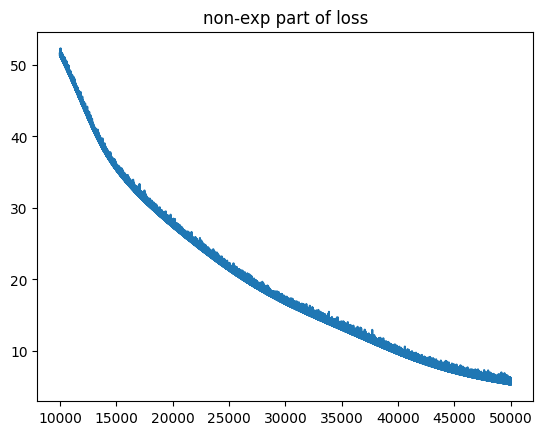

Function custom_tucker time:  0:07:42.122419
score: 5.327748073138494

iter119, params: (50000, 0.0005, (0.3, 0.9), 1e-09, 0)
iter 5000 loss 65.02382982898898
iter 10000 loss 46.45412168015374
iter 15000 loss 32.161851833743256
iter 20000 loss 24.460631352867885
iter 25000 loss 20.053589410133302
iter 30000 loss 16.67446445023936
iter 35000 loss 13.455444828914674
iter 40000 loss 10.815385467537158
iter 45000 loss 8.827421189463765
iter 50000 loss 7.235720569304525


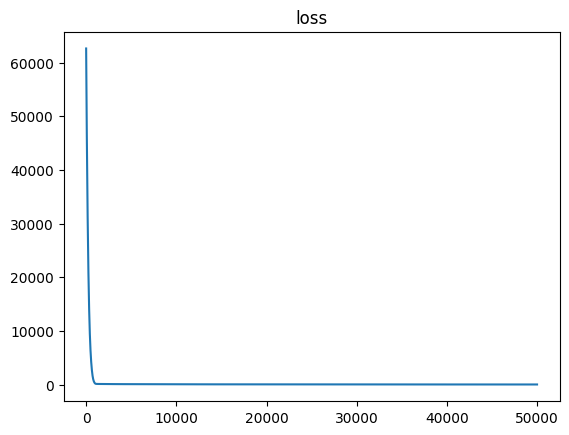

final loss 7.235124401769005


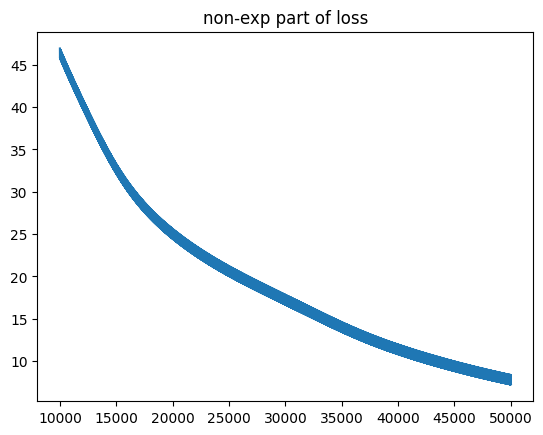

Function custom_tucker time:  0:07:38.356373
score: 7.235124401769005

iter120, params: (50000, 0.0005, (0.6, 0.3), 1e-09, 0)
iter 5000 loss 53.99202315949452
iter 10000 loss 33.367448292407055
iter 15000 loss 21.82497373192359
iter 20000 loss 15.600475269512472
iter 25000 loss 11.512847764068733
iter 30000 loss 8.322501970956026
iter 35000 loss 5.272014791993557
iter 40000 loss 3.375622566767539
iter 45000 loss 2.097213952630783
iter 50000 loss 1.27193405568958


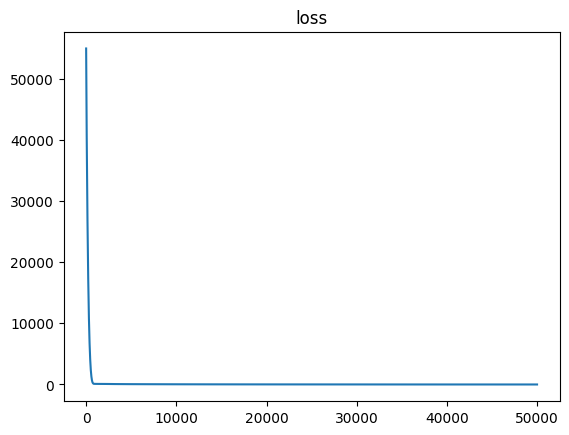

final loss 1.1400077731176217


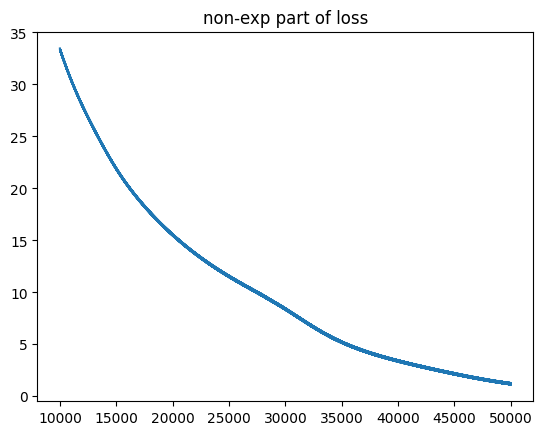

Function custom_tucker time:  0:07:38.291404
score: 1.140007773117621

iter121, params: (50000, 0.0005, (0.6, 0.6), 1e-09, 0)
iter 5000 loss 45.54887840349346
iter 10000 loss 26.151855291229417
iter 15000 loss 17.94615264188757
iter 20000 loss 11.967935641446708
iter 25000 loss 7.748225868139472
iter 30000 loss 5.1589659628819575
iter 35000 loss 3.408635698228246
iter 40000 loss 2.3641204393084623
iter 45000 loss 1.5371129710352678
iter 50000 loss 0.9986178575514758


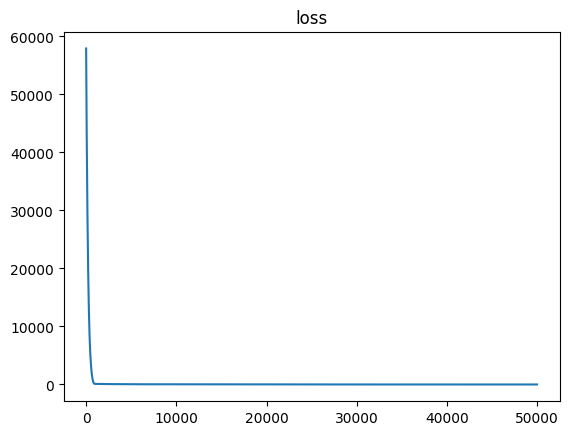

final loss 1.0681234354965092


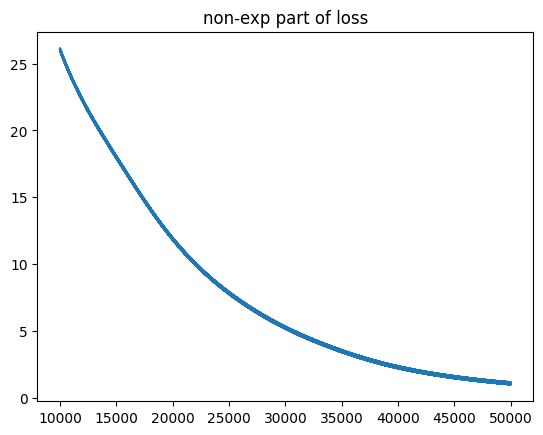

Function custom_tucker time:  0:07:36.371837
score: 1.068123435496508

iter122, params: (50000, 0.0005, (0.6, 0.9), 1e-09, 0)
iter 5000 loss 45.71810908646953
iter 10000 loss 30.84753469106598
iter 15000 loss 20.403643503526908
iter 20000 loss 13.420340015334014
iter 25000 loss 7.994120117145752
iter 30000 loss 4.5181836937144135
iter 35000 loss 2.698449906122612
iter 40000 loss 1.6207183500534457
iter 45000 loss 0.8775581678373148
iter 50000 loss 0.8889147785990837


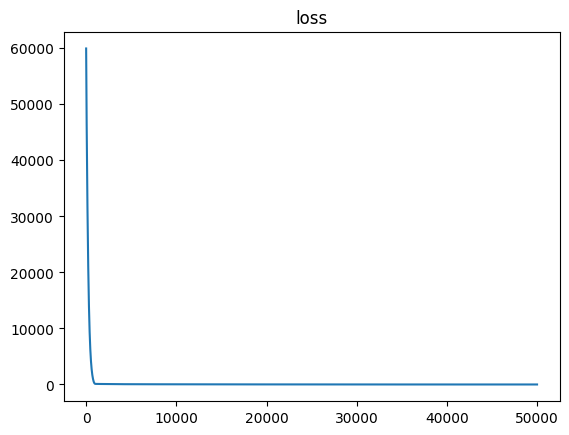

final loss 0.7263636914123831


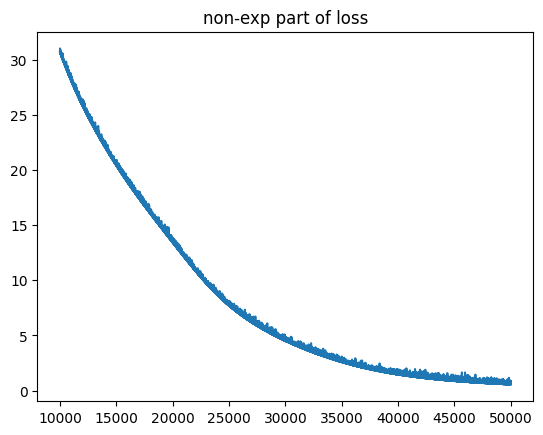

Function custom_tucker time:  0:07:38.883722
score: 0.7263636914123831

iter123, params: (50000, 0.0005, (0.9, 0.3), 1e-09, 0)
iter 5000 loss 93.01942621281225
iter 10000 loss 85.75379308377462
iter 15000 loss 67.54101170636267
iter 20000 loss 52.70602746153434
iter 25000 loss 43.0804512978437
iter 30000 loss 38.121158121948255
iter 35000 loss 32.935596191695275
iter 40000 loss 31.51197169877308
iter 45000 loss 27.82824272912776
iter 50000 loss 26.03695644186263


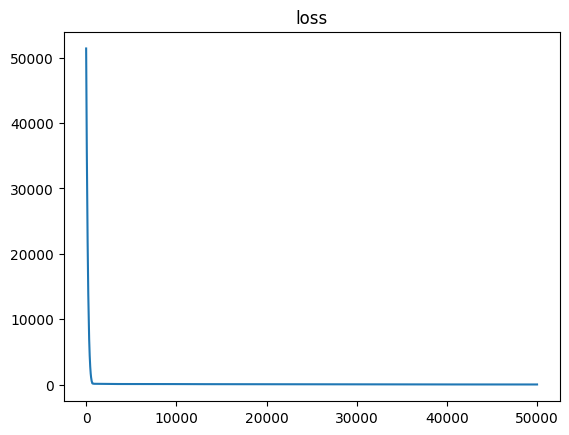

final loss 26.291096079272023


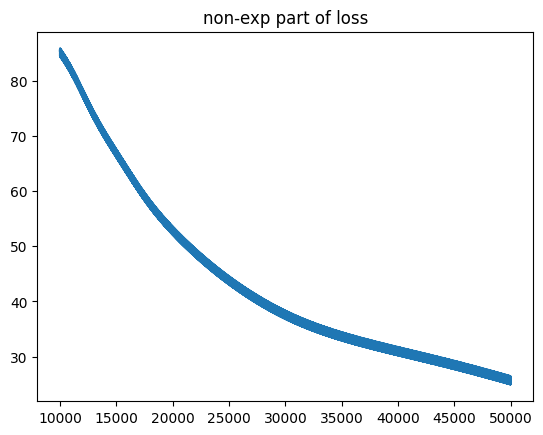

Function custom_tucker time:  0:07:38.622795
score: 26.29109607927203

iter124, params: (50000, 0.0005, (0.9, 0.6), 1e-09, 0)
iter 5000 loss 38.66093858618982
iter 10000 loss 5.051241499898138


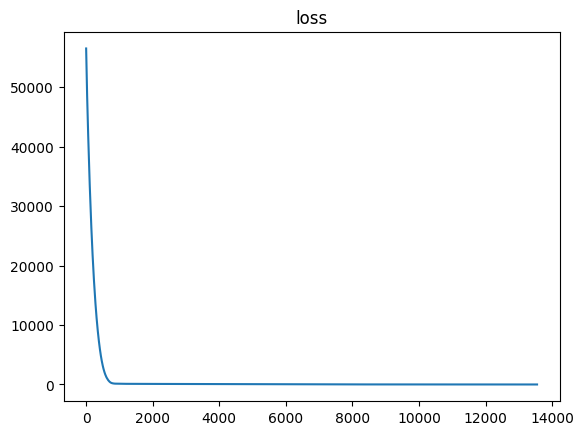

final loss 0.4994979935429331


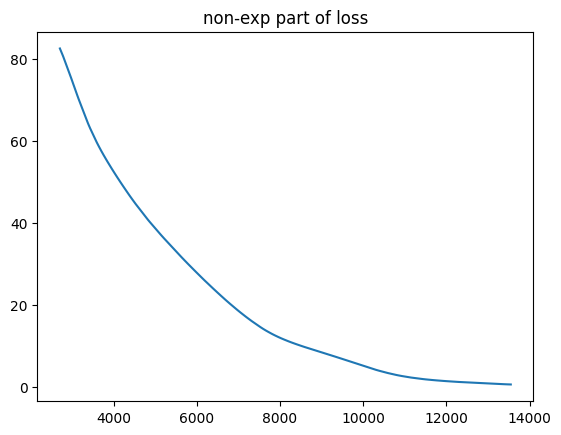

Function custom_tucker time:  0:02:04.179481
score: 0.5024190492843674

iter125, params: (50000, 0.0005, (0.9, 0.9), 1e-09, 0)
iter 5000 loss 10.985028292560004
iter 10000 loss 0.5658688847688941


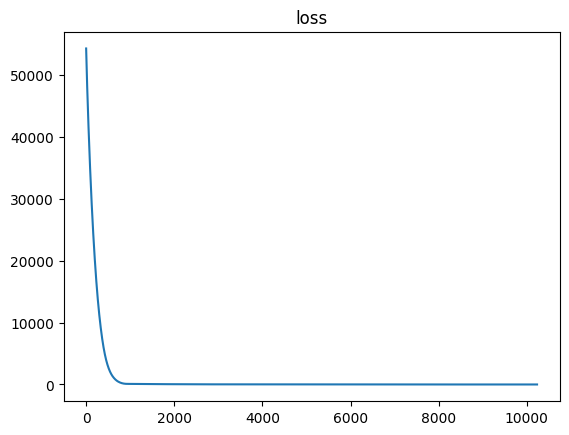

final loss 0.4999429437480771


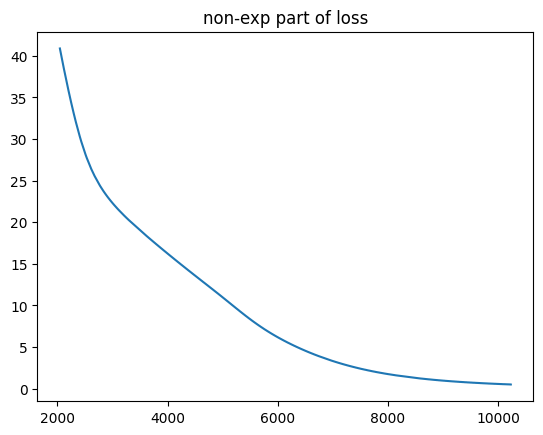

Function custom_tucker time:  0:01:33.202148
score: 0.5022168116018079

iter126, params: (50000, 0.0001, (0.3, 0.3), 1e-09, 0)
iter 5000 loss 106.81245345395136
iter 10000 loss 52.65744083258295
iter 15000 loss 32.063799112082414
iter 20000 loss 26.09637526581599
iter 25000 loss 21.92655448803354
iter 30000 loss 18.122836562027423
iter 35000 loss 14.599936346206768
iter 40000 loss 11.75473907631788
iter 45000 loss 9.598873307592676
iter 50000 loss 7.855494692474187


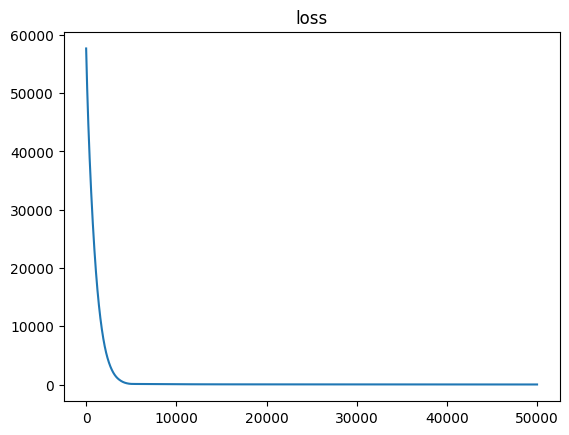

final loss 7.839934482466089


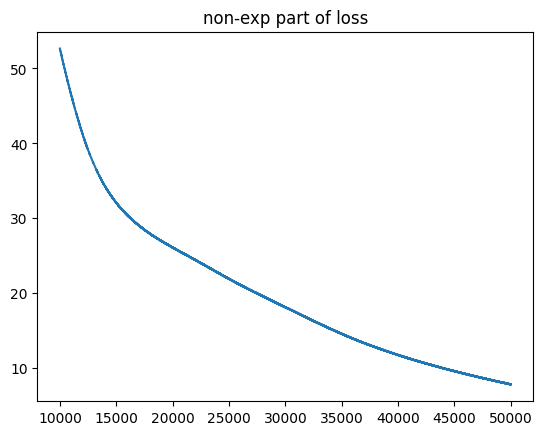

Function custom_tucker time:  0:07:39.384802
score: 7.839934482466087

iter127, params: (50000, 0.0001, (0.3, 0.6), 1e-09, 0)
iter 5000 loss 93.1218976604598
iter 10000 loss 57.10897800352023
iter 15000 loss 40.01775137674233
iter 20000 loss 31.119632762942672
iter 25000 loss 23.467855273243398
iter 30000 loss 18.931142645170688
iter 35000 loss 15.632303718904753
iter 40000 loss 12.489253564469216
iter 45000 loss 9.35273323953755
iter 50000 loss 6.937092253646243


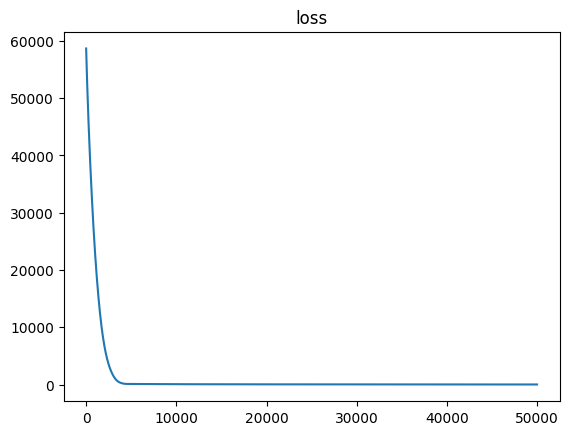

final loss 6.938765490251314


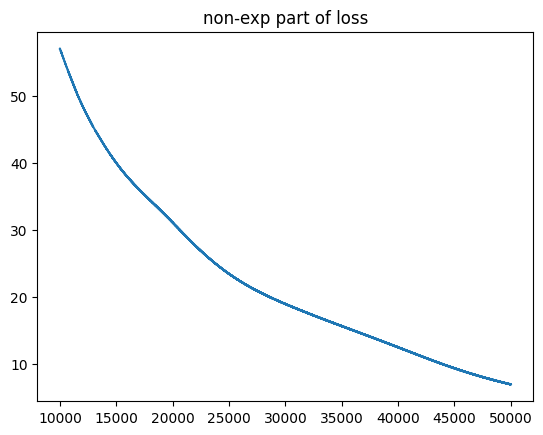

Function custom_tucker time:  0:07:41.667518
score: 6.938765490251306

iter128, params: (50000, 0.0001, (0.3, 0.9), 1e-09, 0)
iter 5000 loss 94.69299620558516
iter 10000 loss 62.22618530524488
iter 15000 loss 40.94622159192162
iter 20000 loss 26.51365915506031
iter 25000 loss 20.873342573046042
iter 30000 loss 17.383851877086776
iter 35000 loss 14.49073846698716
iter 40000 loss 12.013001556127533
iter 45000 loss 9.799549666720035
iter 50000 loss 7.607933151605274


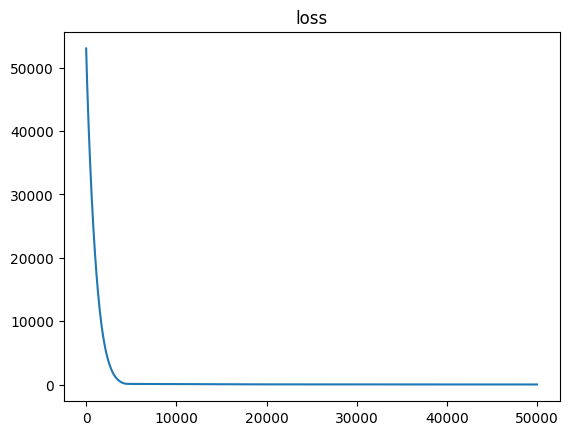

final loss 7.608754405006163


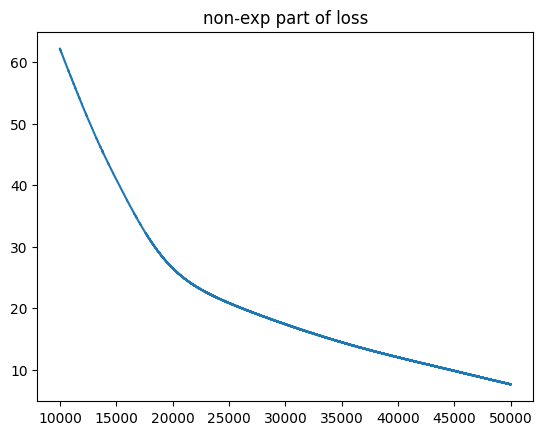

Function custom_tucker time:  0:08:09.657970
score: 7.608754405006164

iter129, params: (50000, 0.0001, (0.6, 0.3), 1e-09, 0)
iter 5000 loss 94.517741329152
iter 10000 loss 60.49721930132942
iter 15000 loss 39.988272414785236
iter 20000 loss 31.703278491028254
iter 25000 loss 24.94710414352344
iter 30000 loss 20.289012732135028
iter 35000 loss 17.39165687802508
iter 40000 loss 14.949284410042514
iter 45000 loss 12.519016224350695
iter 50000 loss 9.920920234065404


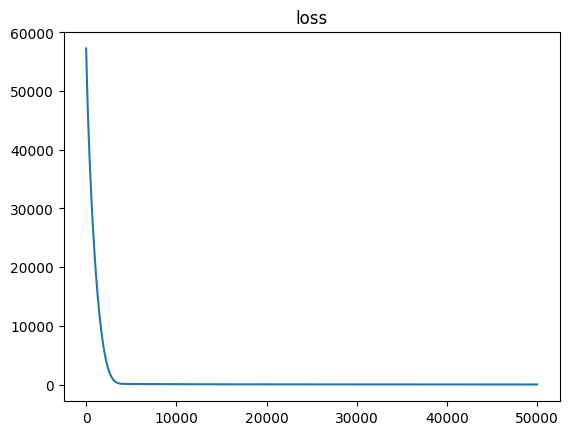

final loss 9.906036954671555


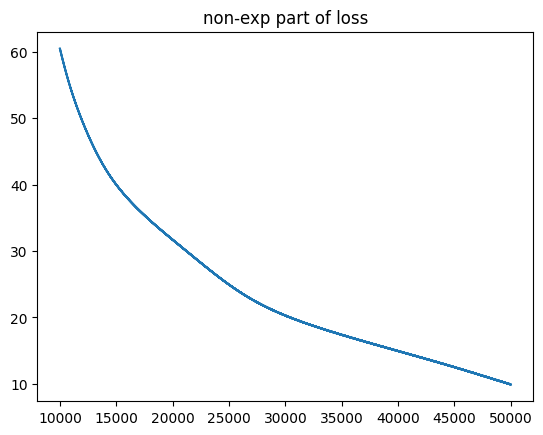

Function custom_tucker time:  0:07:43.739762
score: 9.906036954671556

iter130, params: (50000, 0.0001, (0.6, 0.6), 1e-09, 0)
iter 5000 loss 88.89839204174264
iter 10000 loss 37.694797449556816
iter 15000 loss 21.23080549671866
iter 20000 loss 12.935790154447982
iter 25000 loss 7.900958255128527
iter 30000 loss 4.79242638633307
iter 35000 loss 2.8367156668857585
iter 40000 loss 1.7310481946974658
iter 45000 loss 1.1109466083231236
iter 50000 loss 0.767051438628369


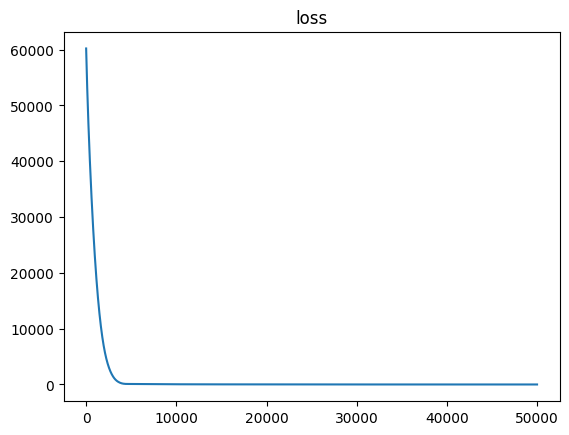

final loss 0.7690650823719568


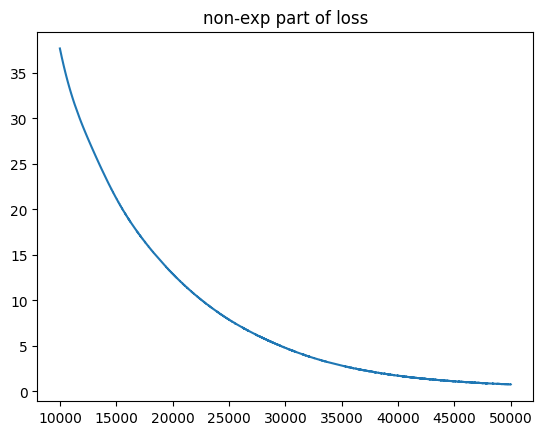

Function custom_tucker time:  0:07:37.798650
score: 0.7690650823719565

iter131, params: (50000, 0.0001, (0.6, 0.9), 1e-09, 0)
iter 5000 loss 87.3963007259119
iter 10000 loss 40.818393603960494
iter 15000 loss 22.646707289855797
iter 20000 loss 14.717690266382041
iter 25000 loss 8.96217659691468
iter 30000 loss 5.107074815211116
iter 35000 loss 2.765382039211652
iter 40000 loss 1.480639279899164
iter 45000 loss 0.8826076918787885
iter 50000 loss 0.5751493633084156


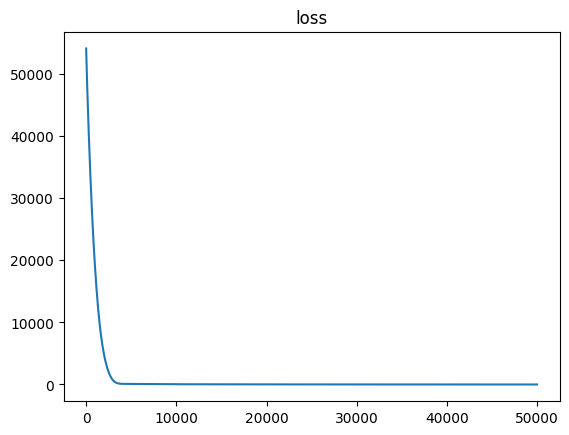

final loss 0.5696410617034307


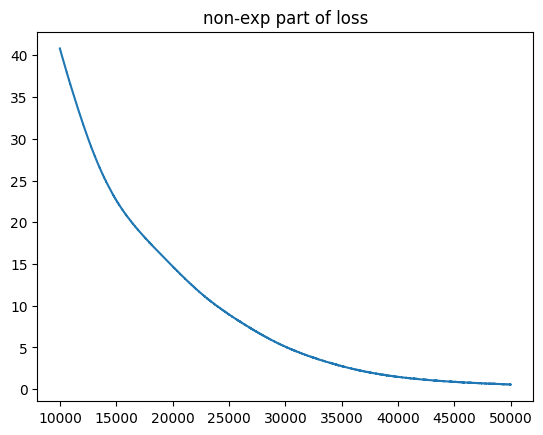

Function custom_tucker time:  0:08:10.468228
score: 0.5696410617034304

iter132, params: (50000, 0.0001, (0.9, 0.3), 1e-09, 0)
iter 5000 loss 105.6066791401676
iter 10000 loss 91.39499013265167
iter 15000 loss 80.04066293923893
iter 20000 loss 69.85064118088268
iter 25000 loss 60.701321284971634
iter 30000 loss 50.67226021597818
iter 35000 loss 43.674293785445506
iter 40000 loss 39.12322781952683
iter 45000 loss 35.15321409170578
iter 50000 loss 31.184033825219835


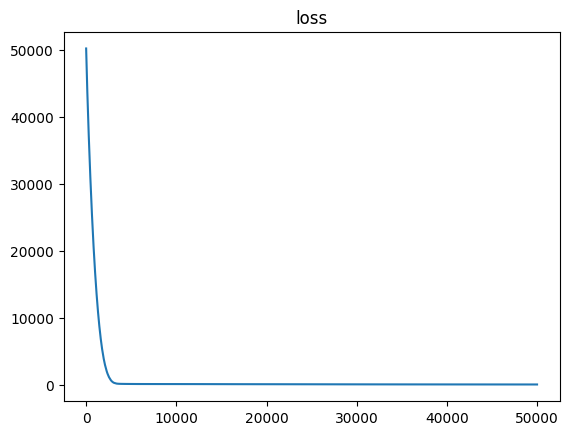

final loss 31.22698847635612


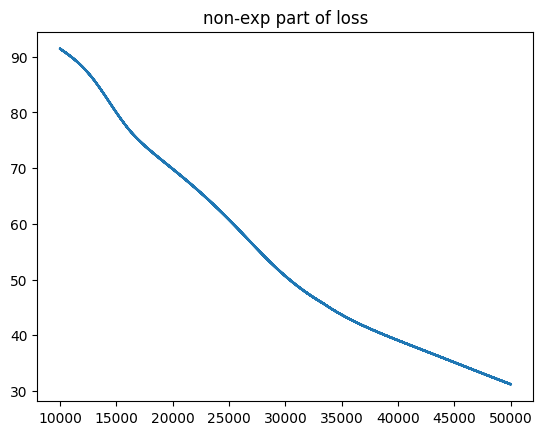

Function custom_tucker time:  0:07:39.437468
score: 31.22698847635613

iter133, params: (50000, 0.0001, (0.9, 0.6), 1e-09, 0)
iter 5000 loss 109.8446540521191
iter 10000 loss 77.4432743180323
iter 15000 loss 54.17527466356555
iter 20000 loss 38.06991604788735
iter 25000 loss 29.715492518123497
iter 30000 loss 22.051287858321025
iter 35000 loss 14.386032899125489
iter 40000 loss 8.274568685993348
iter 45000 loss 3.961542747682316


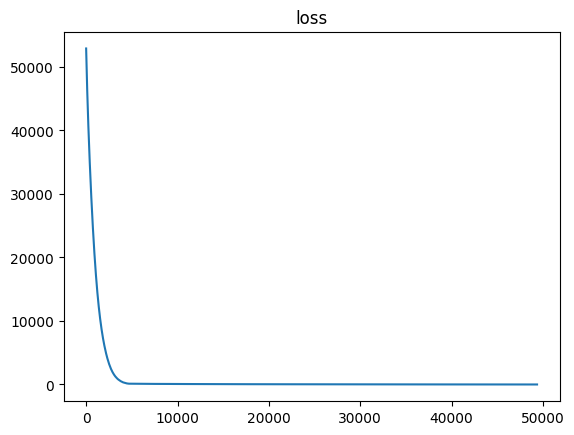

final loss 0.49976676650345514


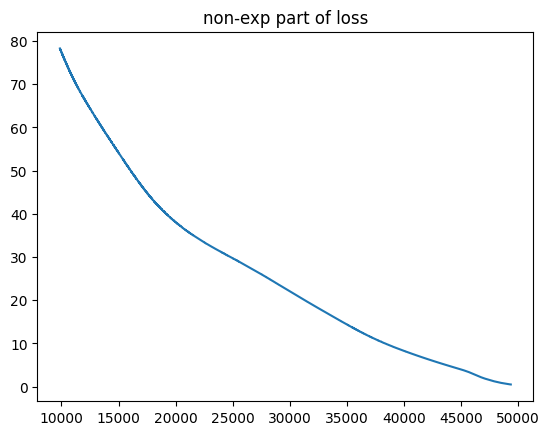

Function custom_tucker time:  0:07:35.676775
score: 0.4994456492151047

iter134, params: (50000, 0.0001, (0.9, 0.9), 1e-09, 0)
iter 5000 loss 84.15746246819732
iter 10000 loss 24.570390301479986
iter 15000 loss 6.07062564730039
iter 20000 loss 0.9817150863625265


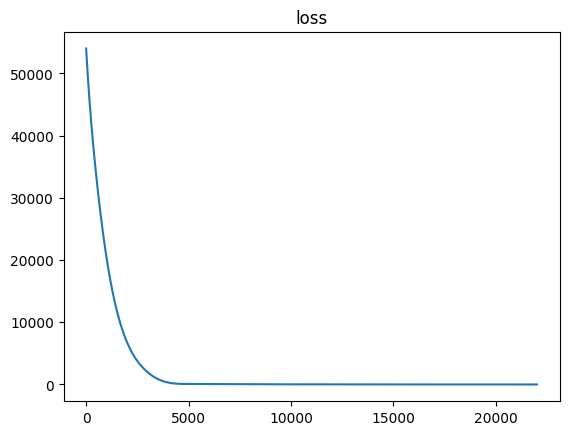

final loss 0.49997301091976737


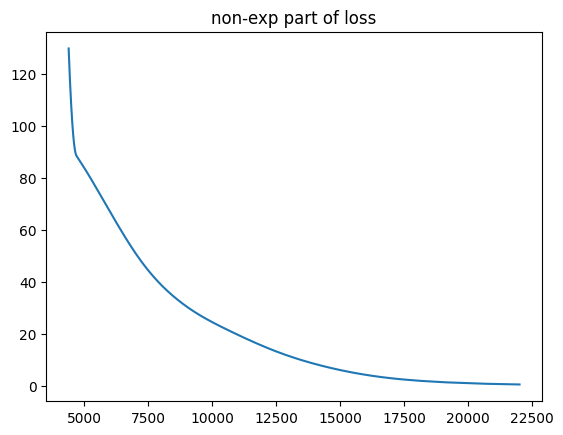

Function custom_tucker time:  0:03:19.295601
score: 0.4997296784296426


In [105]:
best_tucker_mse = 1000000
best_params = [0, {'lr': 0, 'betas': None, 'eps': 0, 'weight_decay': 0}]

for i, param in enumerate(params):
    print(f"iter{i}, params: {param}")
    start_time = datetime.now()
    G_t, U_t = custom_tucker(data, r=(10, 20, 30), iter_num = param[0], device=device, opt=optim.Adam, opt_params={'lr': param[1], 'betas': param[2], 'eps': param[3], 'weight_decay': param[4]})
    score = ((data.numpy() - repair_tensor(G_t, U_t).detach().numpy()) ** 2).mean()
    print("Function {} time: ".format(custom_tucker.__name__), datetime.now() - start_time)
    print(f"score: {score}\n")
    
    if score < best_tucker_mse:
        best_params = [param[0], {'lr': param[1], 'betas': param[2], 'eps': param[3], 'weight_decay': param[4]}]
        best_tucker_mse = score

In [107]:
print(best_tucker_mse)
best_params

0.4967885913763346


[50000, {'lr': 0.001, 'betas': (0.9, 0.6), 'eps': 1e-09, 'weight_decay': 0}]

## 5 Приведите сравнение скорости работы и ошибки восстановления методом из пакета и реализованного градиентного
Сравнение может считаться ± объективным с размером выборки от 10.

In [108]:
mean_time_package = []
mean_mse_package = []
mean_time_custom = []
mean_mse_custom = []

iter 5000 loss 45.50252339774979
iter 10000 loss 27.14238043245402
iter 15000 loss 23.085295657820414
iter 20000 loss 22.309080266023507
iter 25000 loss 21.5765878310296
iter 30000 loss 20.721504222757925
iter 35000 loss 20.592127243542397
iter 40000 loss 20.525975407647792
iter 45000 loss 20.48378165044833
iter 50000 loss 20.462060038974535


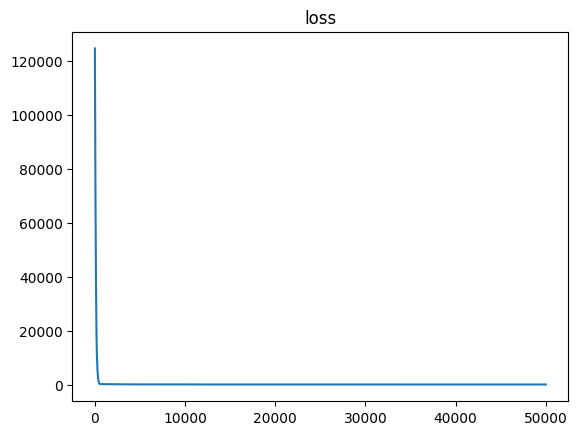

final loss 20.457380211174343


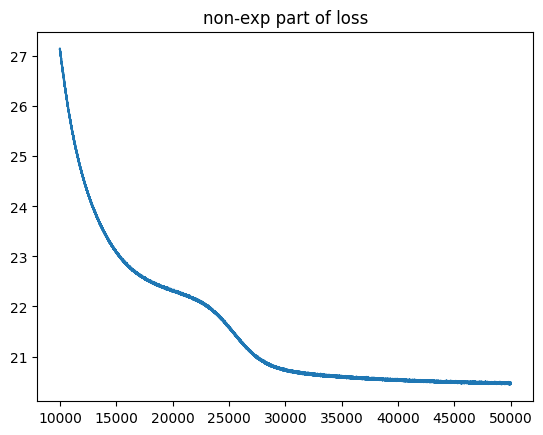

0 iter done
iter 5000 loss 11.781809307270843
iter 10000 loss 10.189797716867032
iter 15000 loss 10.17258938232412
iter 20000 loss 10.161914828749923
iter 25000 loss 10.166375360419664
iter 30000 loss 10.166340694874265
iter 35000 loss 10.170783617932608
iter 40000 loss 10.17034535399037
iter 45000 loss 10.164538838444168
iter 50000 loss 10.167822675479778


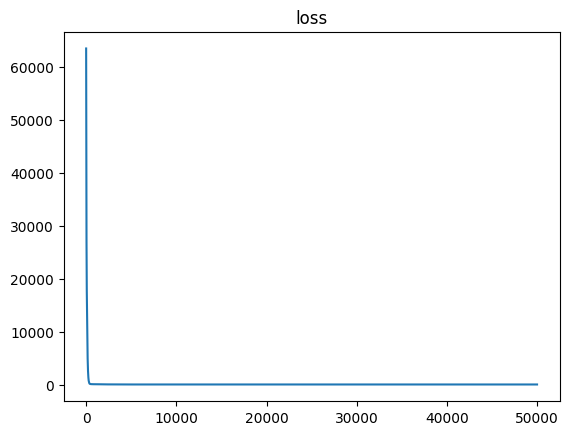

final loss 10.164011762566332


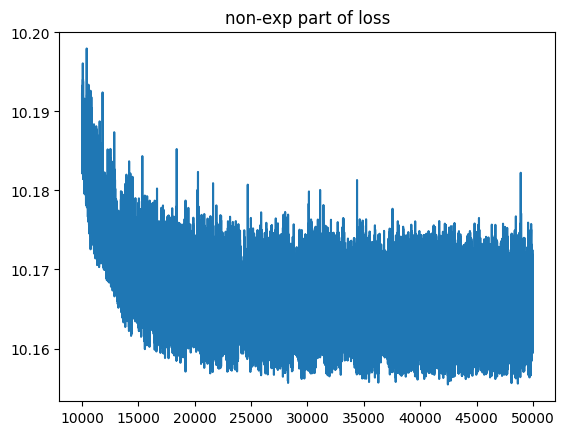

1 iter done
iter 5000 loss 4.018963391265898


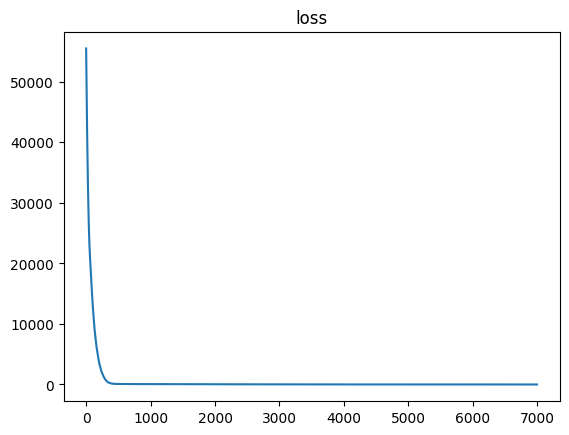

final loss 0.499208991409662


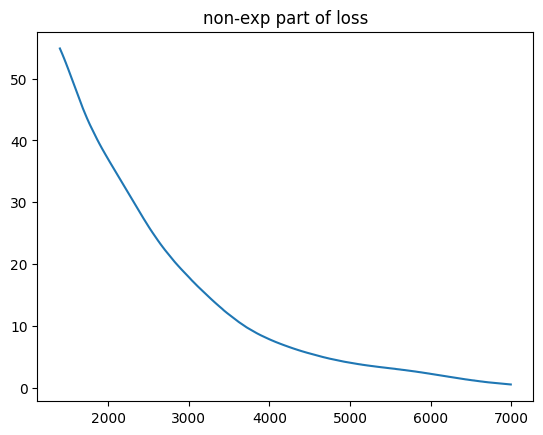

2 iter done
iter 5000 loss 193.46588224358814
iter 10000 loss 136.4365291150449
iter 15000 loss 116.50331576677033
iter 20000 loss 107.4797486617326
iter 25000 loss 103.60956504260413
iter 30000 loss 101.97208078544865
iter 35000 loss 101.22701290019911
iter 40000 loss 100.77323826709373
iter 45000 loss 100.62503941573375
iter 50000 loss 100.58312667591392


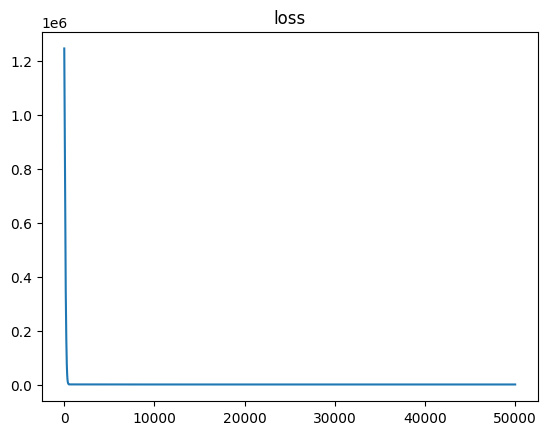

final loss 100.53900588853755


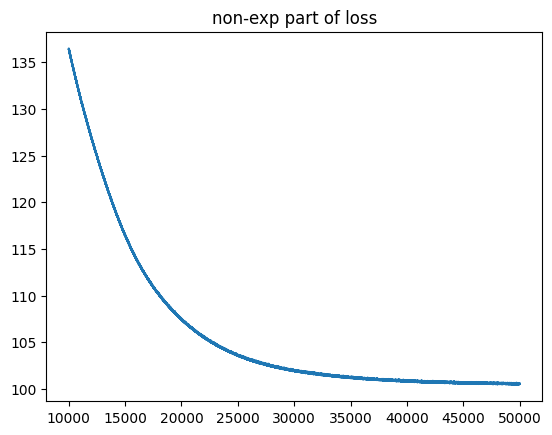

3 iter done
iter 5000 loss 155.84366172632713
iter 10000 loss 99.86812785674383
iter 15000 loss 85.84031591001849
iter 20000 loss 81.21756651945302
iter 25000 loss 79.42844113494364
iter 30000 loss 78.67896615198427
iter 35000 loss 78.26839479567829
iter 40000 loss 78.05324070147871
iter 45000 loss 77.79093943939864
iter 50000 loss 77.55304800019925


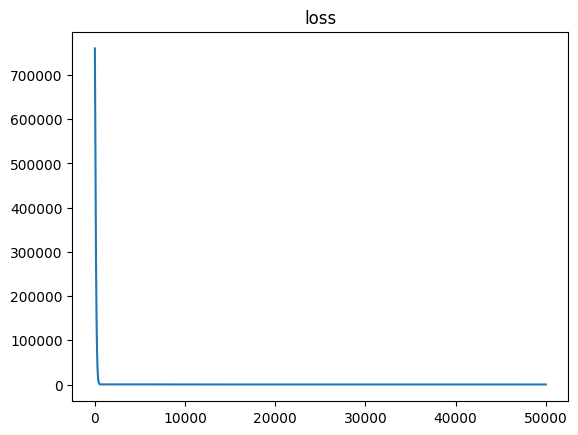

final loss 77.56017519934461


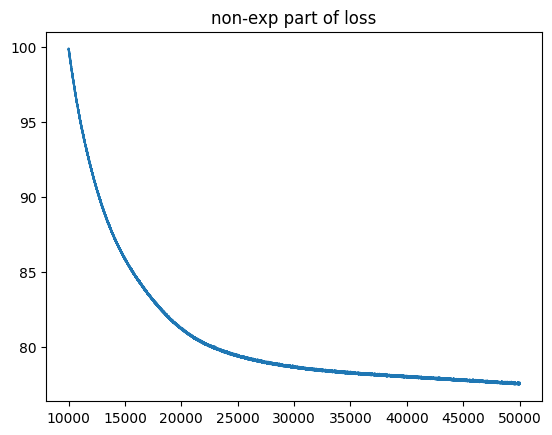

4 iter done
iter 5000 loss 28.03285455638716
iter 10000 loss 17.229611331796765
iter 15000 loss 16.5230197839128
iter 20000 loss 16.409544265513933
iter 25000 loss 16.374232823421078
iter 30000 loss 16.355706212379754
iter 35000 loss 16.3363235993761
iter 40000 loss 16.331416696585197
iter 45000 loss 16.31700085036214
iter 50000 loss 16.304076526929105


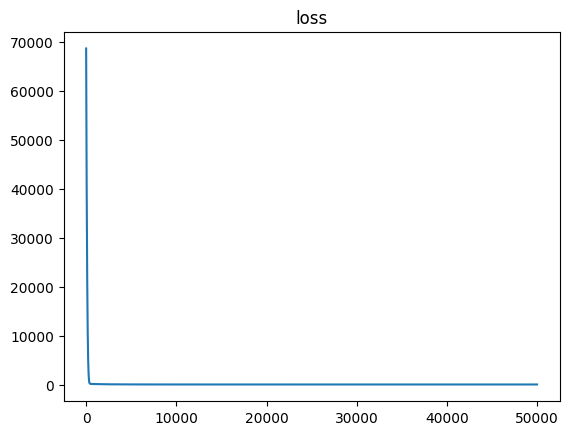

final loss 16.30555637264139


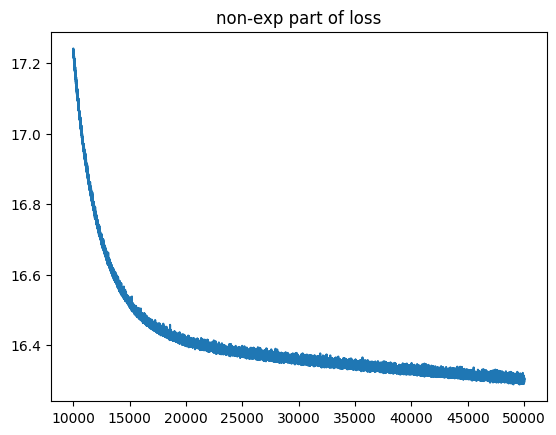

5 iter done
iter 5000 loss 19.52143217770959
iter 10000 loss 14.50298065740702
iter 15000 loss 14.024532456225902
iter 20000 loss 13.953457746690864
iter 25000 loss 13.928223562601705
iter 30000 loss 13.907283109313925
iter 35000 loss 13.902821633328337
iter 40000 loss 13.903946733064815
iter 45000 loss 13.904114271062861
iter 50000 loss 13.89853910079172


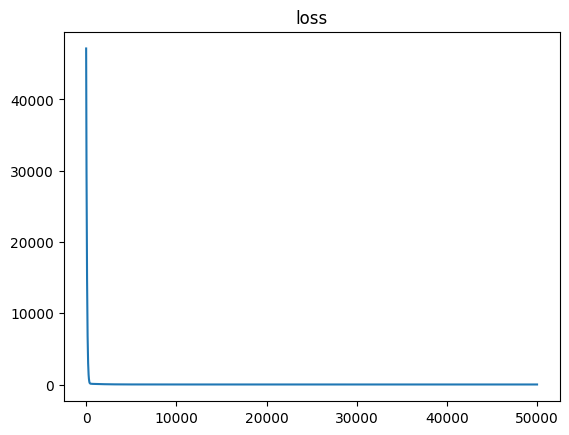

final loss 13.900303433381564


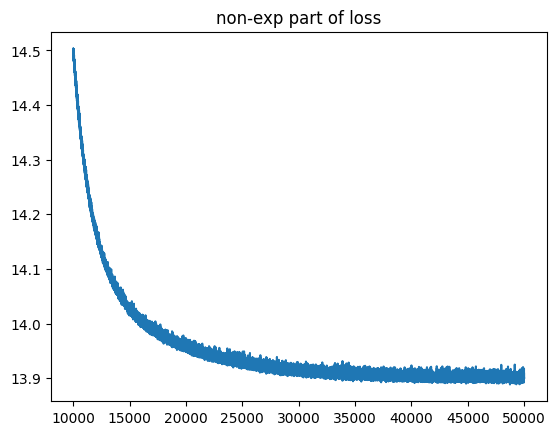

6 iter done
iter 5000 loss 8.841539602856233
iter 10000 loss 7.015750062303704
iter 15000 loss 6.943745967465137
iter 20000 loss 6.945362126550543
iter 25000 loss 6.939036060804828
iter 30000 loss 6.938379360164599
iter 35000 loss 6.940600284279051
iter 40000 loss 6.941348265489473
iter 45000 loss 6.94745993143341
iter 50000 loss 6.93841741099357


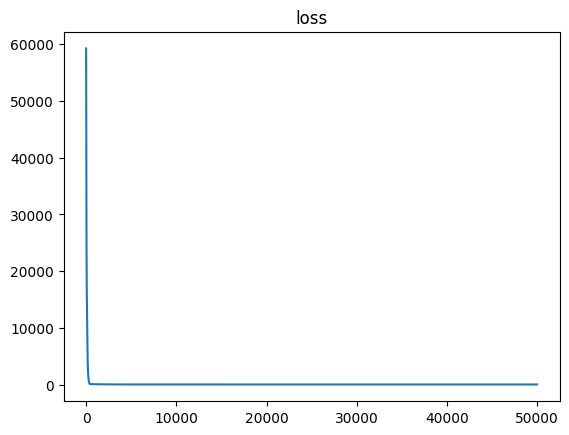

final loss 6.94023979956064


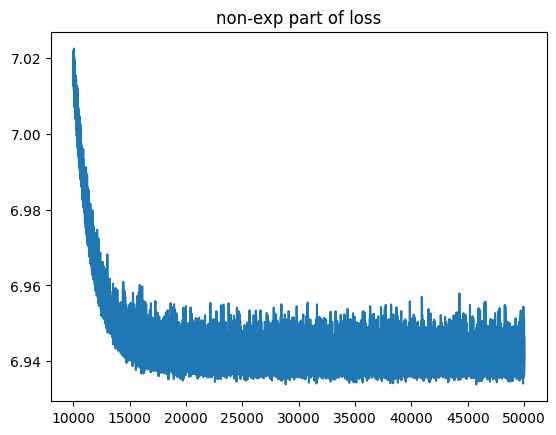

7 iter done
iter 5000 loss 33.98252520153935
iter 10000 loss 26.94039702900992
iter 15000 loss 26.037785700292904
iter 20000 loss 25.812429991742714
iter 25000 loss 25.736817007020182
iter 30000 loss 25.701270103459684
iter 35000 loss 25.679110793724178
iter 40000 loss 25.67877107708898
iter 45000 loss 25.651995302090793
iter 50000 loss 25.652297758788418


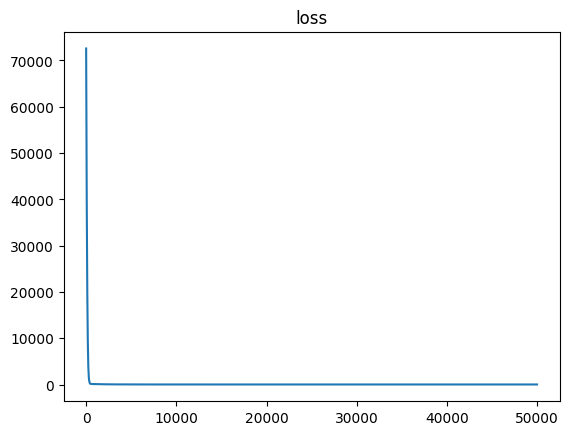

final loss 25.654543171564093


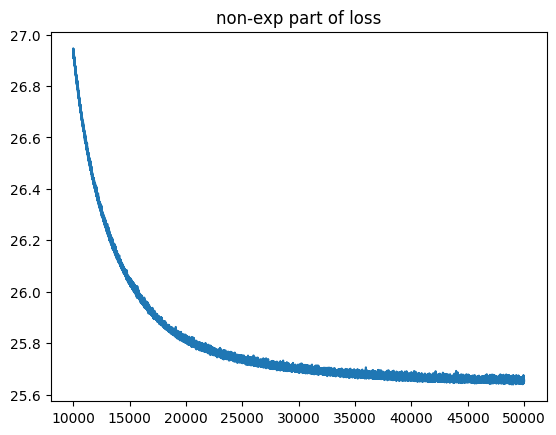

8 iter done
iter 5000 loss 30.273901637744213
iter 10000 loss 23.84275419377012
iter 15000 loss 23.645542403470102
iter 20000 loss 23.63351954356941
iter 25000 loss 23.640065279482116
iter 30000 loss 23.649425174542706
iter 35000 loss 23.635948960853774
iter 40000 loss 23.633109839211773
iter 45000 loss 23.637498718276273
iter 50000 loss 23.654056211193105


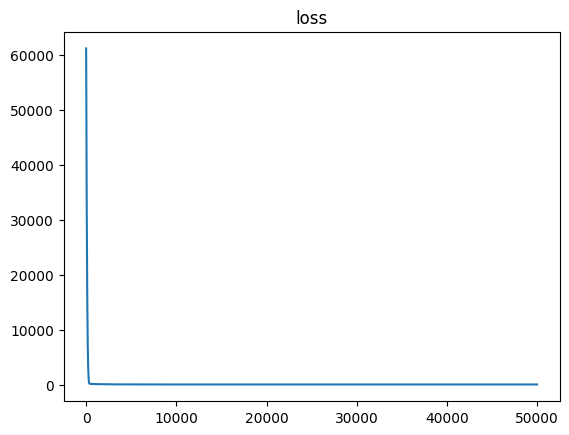

final loss 23.630219999279944


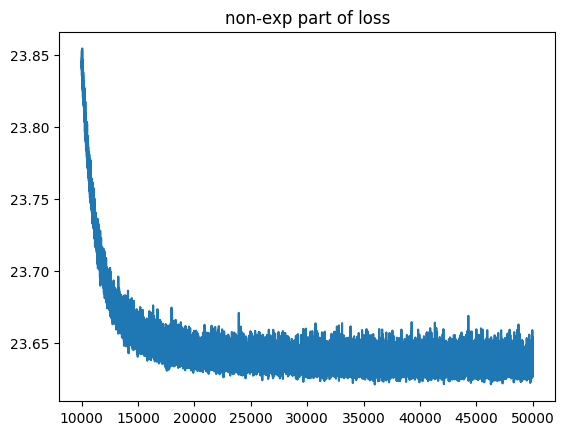

9 iter done


In [111]:
for i in range(10):
    ranks = (10 + random.randint(0, 20), 10 + random.randint(0, 20), 10 + random.randint(0, 20))
    tensor, U, G = get_tensor(r=ranks)

    start_package_time = datetime.now()
    decomp = tucker(tensor.numpy(), ranks)
    mean_time_package.append((datetime.now() - start_package_time).total_seconds())
    
    comp = repair_tensor(torch.Tensor(decomp.core), [torch.Tensor(factor.T) for factor in decomp.factors])
    mean_mse_package.append(((tensor.numpy() - comp.numpy())**2).mean())
    
    start_custom_time = datetime.now()
    G_t, U_t = custom_tucker(tensor, r=ranks, iter_num = best_params[0], device=device, opt=optim.Adam, opt_params=best_params[1])
    mean_time_custom.append((datetime.now() - start_custom_time).total_seconds())
    mean_mse_custom.append(((tensor.numpy() - repair_tensor(G_t, U_t).detach().numpy()) ** 2).mean())

    print(f"{i} iter done")

In [129]:
mean_time_package

[0.701021,
 1.049586,
 0.652996,
 0.708181,
 0.802416,
 0.766316,
 0.652588,
 0.677026,
 0.690823,
 0.690231]

In [134]:
mean_time_custom

[453.171195,
 455.598195,
 73.177379,
 457.036645,
 456.910216,
 459.023536,
 480.605032,
 478.490652,
 476.6274,
 457.237136]

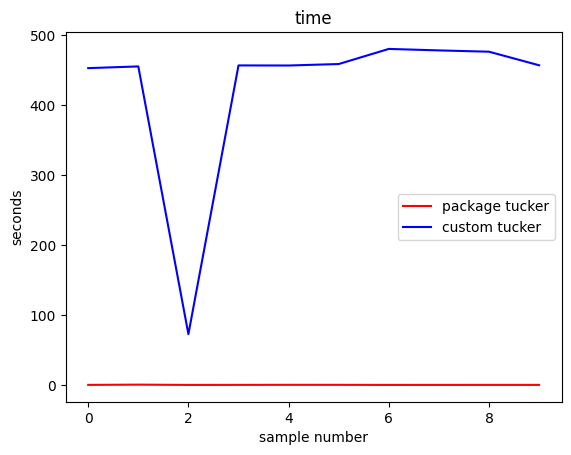

In [136]:
plt.plot(range(10), mean_time_package, color="red", label='package tucker')
plt.plot(range(10), mean_time_custom, color="blue", label='custom tucker')
plt.xlabel('sample number')
plt.ylabel('seconds')
plt.title('time')
plt.legend()
plt.show()

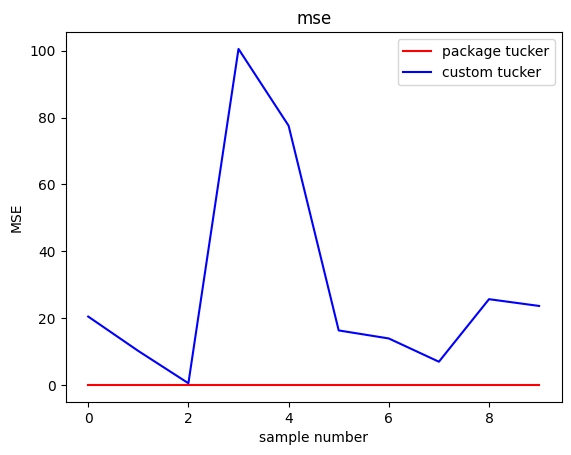

In [137]:
plt.plot(range(10), mean_mse_package, color="red", label='package tucker')
plt.plot(range(10), mean_mse_custom, color="blue", label='custom tucker')
plt.xlabel('sample number')
plt.ylabel('MSE')
plt.title('mse')
plt.legend()
plt.show()

In [138]:
print(f"mean package tucker time {sum(mean_time_package) / len(mean_time_package)} seconds")
print(f"mean custom tucker time {sum(mean_time_custom) / len(mean_time_custom)} seconds")
print(f"mean package tucker mse {sum(mean_mse_package) / len(mean_mse_package)}")
print(f"mean custom tucker mse {sum(mean_mse_custom) / len(mean_mse_custom)}")

mean package tucker time 0.7391184 seconds
mean custom tucker time 424.7877385999999 seconds
mean package tucker mse 3.204486739415794e-08
mean custom tucker mse 29.565204159822674
